In [1]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Default Parameters

In [2]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'HalfCheetahAdv-v1'

layer_size = tuple([64,64])
step_size = 0.02
gae_lambda = 0.95
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 7.0

In [4]:
adv_strengths = []
for i in range(0, int(adv_fraction)+1, 1):
    adv_strengths.append(i)

In [5]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [6]:
filepath = 'results/Cheetah/env-HalfCheetahAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.02_lam0.95_95277.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-25 10:47:38,114] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Train Loop

In [7]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'static_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)    

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Loops through adversary strength levels
    n_loopsize = int(n_itr/len(adv_strengths))
    for adv_index, adv_strength in enumerate(adv_strengths):
        
        env = normalize(GymEnv(env_name, adv_strength))
        
        ## Optimizer for the Protagonist ##
        pro_algo = TRPO(
            env=env,
            pro_policy=pro_policy,
            adv_policy=adv_policy,
            pro_baseline=pro_baseline,
            adv_baseline=adv_baseline,
            batch_size=batch_size,
            max_path_length=path_length,
            n_itr=n_pro_itr,
            discount=0.995,
            gae_lambda=gae_lambda,
            step_size=step_size,
            is_protagonist=True
        )
        
        logger.log('\n\nAdversarial Level: {} Adversarial Strength: {}\n'.format(adv_index, adv_strength))
        
        ## Beginning alternating optimization ##
        for ni in range(n_loopsize):
            logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni+n_loopsize*adv_index,))

            ## Train Protagonist
            pro_algo.train()
            pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
            logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))

            ## Test the learnt policies
            const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
            rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
            step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
            rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
            adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

            if ni%afterRender==0 and ifRender==True:
                test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

            if ni!=0 and ni%save_every==0:
                ## SAVING CHECKPOINT INFO ##
                pickle.dump({'args': args,
                             'pro_policy': pro_policy,
                             'adv_policy': adv_policy,
                             'zero_test': [const_testing_rews],
                             'rand_test': [rand_testing_rews],
                             'step_test': [step_testing_rews],
                             'rand_step_test': [rand_step_testing_rews],
                             'iter_save': ni,
                             'exp_save': ne,
                             'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni+n_loopsize*adv_index)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-25 10:47:40.191045 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 10:47:40,192] Making new env: HalfCheetahAdv-v1


2018-01-25 10:47:40.739572 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 10:47:40,743] Making new env: HalfCheetahAdv-v1


2018-01-25 10:47:54.673882 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 10:47:54,675] Making new env: HalfCheetahAdv-v1


2018-01-25 10:47:54.683072 EST | Populating workers...
2018-01-25 10:47:54.686245 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 10:47:54.686245 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 10:47:54.686285 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 10:47:54.686285 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 10:47:54,688] Making new env: HalfCheetahAdv-v1
[2018-01-25 10:47:54,688] Making new env: HalfCheetahAdv-v1
[2018-01-25 10:47:54,688] Making new env: HalfCheetahAdv-v1
[2018-01-25 10:47:54,689] Making new env: HalfCheetahAdv-v1


2018-01-25 10:47:55.023389 EST | Populated
2018-01-25 10:47:55.142245 EST | 

Adversarial Level: 0 Adversarial Strength: 0

2018-01-25 10:47:55.142991 EST | 

Experiment: 0 Iteration: 0

2018-01-25 10:47:55.143789 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 10:48:01.001486 EST | fitting baseline...
2018-01-25 10:48:01.022005 EST | fitted
=: Compiling function f_loss
done in 0.290 seconds
=: Compiling function constraint
done in 0.145 seconds
2018-01-25 10:48:01.777781 EST | computing loss before
2018-01-25 10:48:01.956755 EST | performing update
2018-01-25 10:48:01.959497 EST | computing descent direction
=: Compiling function f_grad
done in 0.610 seconds
=: Compiling function f_Hx_plain
done in 1.664 seconds
2018-01-25 10:48:08.343108 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.405 seconds
2018-01-25 10:48:08.925299 EST | backtrack iters: 0
2018-01-25 10:48:08.926469 EST | computing loss after
2018-01-25 10:48:08.927487 EST | optimization finished
2018-01-25 10:48:09.307651 EST | Protag Reward: -380.0563707757652
2018-01-25 10:48:19.619430 EST | 

Experiment: 0 Iteration: 1

2018-01-25 10:48:19.620355 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:48:23.362290 EST | fitting baseline...
2018-01-25 10:48:23.389337 EST | fitted
2018-01-25 10:48:23.810616 EST | computing loss before
2018-01-25 10:48:24.010426 EST | performing update
2018-01-25 10:48:24.012194 EST | computing descent direction
2018-01-25 10:48:28.156761 EST | descent direction computed
2018-01-25 10:48:28.373697 EST | backtrack iters: 0
2018-01-25 10:48:28.374894 EST | computing loss after
2018-01-25 10:48:28.375828 EST | optimization finished
2018-01-25 10:48:28.769374 EST | Protag Reward: -357.6996399444216
2018-01-25 10:48:41.877227 EST | 

Experiment: 0 Iteration: 2

2018-01-25 10:48:41.878232 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:48:46.938975 EST | fitting baseline...
2018-01-25 10:48:46.958340 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:48:47.404762 EST | computing loss before
2018-01-25 10:48:47.611210 EST | performing update
2018-01-25 10:48:47.614132 EST | computing descent direction
2018-01-25 10:48:52.605173 EST | descent direction computed
2018-01-25 10:48:52.896341 EST | backtrack iters: 0
2018-01-25 10:48:52.897449 EST | computing loss after
2018-01-25 10:48:52.898534 EST | optimization finished
2018-01-25 10:48:53.284057 EST | Protag Reward: -390.8288950559436
2018-01-25 10:49:02.349290 EST | 

Experiment: 0 Iteration: 3

2018-01-25 10:49:02.350348 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:49:06.189204 EST | fitting baseline...
2018-01-25 10:49:06.210323 EST | fitted



Total time elapsed: 00:00:03


2018-01-25 10:49:06.639380 EST | computing loss before
2018-01-25 10:49:06.871472 EST | performing update
2018-01-25 10:49:06.874355 EST | computing descent direction
2018-01-25 10:49:12.141020 EST | descent direction computed
2018-01-25 10:49:12.324199 EST | backtrack iters: 0
2018-01-25 10:49:12.327133 EST | computing loss after
2018-01-25 10:49:12.329978 EST | optimization finished
2018-01-25 10:49:12.757271 EST | Protag Reward: -362.660769289172
2018-01-25 10:49:24.612778 EST | 

Experiment: 0 Iteration: 4

2018-01-25 10:49:24.613713 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:49:29.371390 EST | fitting baseline...
2018-01-25 10:49:29.388443 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:49:29.808848 EST | computing loss before
2018-01-25 10:49:29.993457 EST | performing update
2018-01-25 10:49:29.996342 EST | computing descent direction
2018-01-25 10:49:33.934915 EST | descent direction computed
2018-01-25 10:49:34.371977 EST | backtrack iters: 1
2018-01-25 10:49:34.375306 EST | computing loss after
2018-01-25 10:49:34.378706 EST | optimization finished
2018-01-25 10:49:34.800940 EST | Protag Reward: -321.8542818306341
2018-01-25 10:49:43.540311 EST | 

Experiment: 0 Iteration: 5

2018-01-25 10:49:43.541209 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:49:47.172629 EST | fitting baseline...
2018-01-25 10:49:47.199464 EST | fitted
2018-01-25 10:49:47.645659 EST | computing loss before
2018-01-25 10:49:47.871055 EST | performing update
2018-01-25 10:49:47.872405 EST | computing descent direction
2018-01-25 10:49:51.625389 EST | descent direction computed
2018-01-25 10:49:51.844716 EST | backtrack iters: 0
2018-01-25 10:49:51.847766 EST | computing loss after
2018-01-25 10:49:51.849062 EST | optimization finished
2018-01-25 10:49:52.277672 EST | Protag Reward: -352.04667419497537
2018-01-25 10:50:00.793842 EST | 

Experiment: 0 Iteration: 6

2018-01-25 10:50:00.794885 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:50:04.727390 EST | fitting baseline...
2018-01-25 10:50:04.747105 EST | fitted
2018-01-25 10:50:05.194008 EST | computing loss before
2018-01-25 10:50:05.400034 EST | performing update
2018-01-25 10:50:05.402428 EST | computing descent direction
2018-01-25 10:50:09.236949 EST | descent direction computed
2018-01-25 10:50:09.447194 EST | backtrack iters: 0
2018-01-25 10:50:09.460316 EST | computing loss after
2018-01-25 10:50:09.461232 EST | optimization finished
2018-01-25 10:50:09.870765 EST | Protag Reward: -341.07031849520905
2018-01-25 10:50:18.553581 EST | 

Experiment: 0 Iteration: 7

2018-01-25 10:50:18.554510 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:50:23.327709 EST | fitting baseline...
2018-01-25 10:50:23.348022 EST | fitted
2018-01-25 10:50:23.749373 EST | computing loss before
2018-01-25 10:50:23.954170 EST | performing update
2018-01-25 10:50:23.956955 EST | computing descent direction
2018-01-25 10:50:28.883626 EST | descent direction computed
2018-01-25 10:50:29.078789 EST | backtrack iters: 0
2018-01-25 10:50:29.081653 EST | computing loss after
2018-01-25 10:50:29.084313 EST | optimization finished
2018-01-25 10:50:29.906539 EST | Protag Reward: -344.4706120972407
2018-01-25 10:50:39.556707 EST | 

Experiment: 0 Iteration: 8

2018-01-25 10:50:39.557616 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:50:44.425674 EST | fitting baseline...
2018-01-25 10:50:44.456815 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:50:44.908937 EST | computing loss before
2018-01-25 10:50:45.108927 EST | performing update
2018-01-25 10:50:45.112063 EST | computing descent direction
2018-01-25 10:50:50.010004 EST | descent direction computed
2018-01-25 10:50:50.209711 EST | backtrack iters: 0
2018-01-25 10:50:50.213072 EST | computing loss after
2018-01-25 10:50:50.215783 EST | optimization finished
2018-01-25 10:50:50.594941 EST | Protag Reward: -315.2999716106571
2018-01-25 10:51:03.971081 EST | 

Experiment: 0 Iteration: 9

2018-01-25 10:51:03.972138 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:51:08.766786 EST | fitting baseline...
2018-01-25 10:51:08.787606 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:51:09.204274 EST | computing loss before
2018-01-25 10:51:09.403952 EST | performing update
2018-01-25 10:51:09.406087 EST | computing descent direction
2018-01-25 10:51:14.430010 EST | descent direction computed
2018-01-25 10:51:14.627229 EST | backtrack iters: 0
2018-01-25 10:51:14.628483 EST | computing loss after
2018-01-25 10:51:14.630568 EST | optimization finished
2018-01-25 10:51:15.312855 EST | Protag Reward: -310.1283256999398
2018-01-25 10:51:25.094354 EST | 

Experiment: 0 Iteration: 10

2018-01-25 10:51:25.095290 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:51:29.095970 EST | fitting baseline...
2018-01-25 10:51:29.123975 EST | fitted
2018-01-25 10:51:29.607529 EST | computing loss before
2018-01-25 10:51:29.824942 EST | performing update
2018-01-25 10:51:29.825950 EST | computing descent direction
2018-01-25 10:51:33.796277 EST | descent direction computed
2018-01-25 10:51:34.015532 EST | backtrack iters: 0
2018-01-25 10:51:34.016878 EST | computing loss after
2018-01-25 10:51:34.017983 EST | optimization finished
2018-01-25 10:51:34.438823 EST | Protag Reward: -334.0892819776309
2018-01-25 10:51:43.030381 EST | 

Experiment: 0 Iteration: 11

2018-01-25 10:51:43.031323 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:51:47.239168 EST | fitting baseline...



Total time elapsed: 00:00:03


2018-01-25 10:51:47.257235 EST | fitted
2018-01-25 10:51:47.722155 EST | computing loss before
2018-01-25 10:51:47.939914 EST | performing update
2018-01-25 10:51:47.940957 EST | computing descent direction
2018-01-25 10:51:51.977272 EST | descent direction computed
2018-01-25 10:51:52.198420 EST | backtrack iters: 0
2018-01-25 10:51:52.201497 EST | computing loss after
2018-01-25 10:51:52.204577 EST | optimization finished
2018-01-25 10:51:52.634311 EST | Protag Reward: -263.5439423060015
2018-01-25 10:52:00.946718 EST | 

Experiment: 0 Iteration: 12

2018-01-25 10:52:00.947608 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:52:05.571856 EST | fitting baseline...
2018-01-25 10:52:05.592717 EST | fitted
2018-01-25 10:52:06.103039 EST | computing loss before
2018-01-25 10:52:06.346402 EST | performing update
2018-01-25 10:52:06.347374 EST | computing descent direction
2018-01-25 10:52:10.419584 EST | descent direction computed
2018-01-25 10:52:10.649242 EST | backtrack iters: 0
2018-01-25 10:52:10.652480 EST | computing loss after
2018-01-25 10:52:10.653408 EST | optimization finished
2018-01-25 10:52:11.074424 EST | Protag Reward: -311.4161950377633
2018-01-25 10:52:21.309679 EST | 

Experiment: 0 Iteration: 13

2018-01-25 10:52:21.310623 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 10:52:26.692763 EST | fitting baseline...
2018-01-25 10:52:26.730524 EST | fitted
2018-01-25 10:52:27.144274 EST | computing loss before
2018-01-25 10:52:27.338667 EST | performing update
2018-01-25 10:52:27.339939 EST | computing descent direction
2018-01-25 10:52:32.448324 EST | descent direction computed
2018-01-25 10:52:32.645504 EST | backtrack iters: 0
2018-01-25 10:52:32.646739 EST | computing loss after
2018-01-25 10:52:32.647856 EST | optimization finished
2018-01-25 10:52:33.697108 EST | Protag Reward: -294.1264513497222
2018-01-25 10:52:48.450790 EST | 

Experiment: 0 Iteration: 14

2018-01-25 10:52:48.452803 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 10:52:54.993039 EST | fitting baseline...
2018-01-25 10:52:55.018881 EST | fitted
2018-01-25 10:52:55.438919 EST | computing loss before
2018-01-25 10:52:55.713187 EST | performing update
2018-01-25 10:52:55.715840 EST | computing descent direction
2018-01-25 10:53:00.890359 EST | descent direction computed
2018-01-25 10:53:01.284534 EST | backtrack iters: 1
2018-01-25 10:53:01.285738 EST | computing loss after
2018-01-25 10:53:01.286887 EST | optimization finished
2018-01-25 10:53:02.170483 EST | Protag Reward: -332.4025453751724
2018-01-25 10:53:13.261715 EST | 

Experiment: 0 Iteration: 15

2018-01-25 10:53:13.263742 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 10:53:18.967326 EST | fitting baseline...
2018-01-25 10:53:18.990245 EST | fitted
2018-01-25 10:53:19.400954 EST | computing loss before
2018-01-25 10:53:19.606072 EST | performing update
2018-01-25 10:53:19.608996 EST | computing descent direction
2018-01-25 10:53:24.623140 EST | descent direction computed
2018-01-25 10:53:24.826794 EST | backtrack iters: 0
2018-01-25 10:53:24.829741 EST | computing loss after
2018-01-25 10:53:24.832916 EST | optimization finished
2018-01-25 10:53:25.212177 EST | Protag Reward: -311.1601791104193
2018-01-25 10:53:39.020670 EST | 

Experiment: 0 Iteration: 16

2018-01-25 10:53:39.021630 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:53:42.711131 EST | fitting baseline...
2018-01-25 10:53:42.733117 EST | fitted
2018-01-25 10:53:43.168670 EST | computing loss before
2018-01-25 10:53:43.371756 EST | performing update
2018-01-25 10:53:43.374591 EST | computing descent direction
2018-01-25 10:53:49.223069 EST | descent direction computed
2018-01-25 10:53:49.605221 EST | backtrack iters: 1
2018-01-25 10:53:49.606410 EST | computing loss after
2018-01-25 10:53:49.607346 EST | optimization finished
2018-01-25 10:53:50.021652 EST | Protag Reward: -301.425653010111
2018-01-25 10:54:01.700793 EST | 

Experiment: 0 Iteration: 17

2018-01-25 10:54:01.701810 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:54:06.871859 EST | fitting baseline...
2018-01-25 10:54:06.891940 EST | fitted
2018-01-25 10:54:07.315921 EST | computing loss before
2018-01-25 10:54:07.513141 EST | performing update
2018-01-25 10:54:07.514412 EST | computing descent direction
2018-01-25 10:54:12.741549 EST | descent direction computed
2018-01-25 10:54:12.952109 EST | backtrack iters: 0
2018-01-25 10:54:12.953342 EST | computing loss after
2018-01-25 10:54:12.954334 EST | optimization finished
2018-01-25 10:54:13.975320 EST | Protag Reward: -280.1542131540631
2018-01-25 10:54:27.380545 EST | 

Experiment: 0 Iteration: 18

2018-01-25 10:54:27.381687 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:54:31.203368 EST | fitting baseline...
2018-01-25 10:54:31.226873 EST | fitted
2018-01-25 10:54:31.636920 EST | computing loss before
2018-01-25 10:54:31.843748 EST | performing update
2018-01-25 10:54:31.846612 EST | computing descent direction
2018-01-25 10:54:36.861242 EST | descent direction computed
2018-01-25 10:54:37.936053 EST | backtrack iters: 1
2018-01-25 10:54:37.938754 EST | computing loss after
2018-01-25 10:54:37.941946 EST | optimization finished
2018-01-25 10:54:38.983229 EST | Protag Reward: -254.1706720211864
2018-01-25 10:54:48.140274 EST | 

Experiment: 0 Iteration: 19

2018-01-25 10:54:48.141230 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:54:53.581486 EST | fitting baseline...
2018-01-25 10:54:53.605331 EST | fitted
2018-01-25 10:54:54.033040 EST | computing loss before
2018-01-25 10:54:54.235437 EST | performing update
2018-01-25 10:54:54.238278 EST | computing descent direction
2018-01-25 10:54:59.238798 EST | descent direction computed
2018-01-25 10:54:59.440893 EST | backtrack iters: 0
2018-01-25 10:54:59.442150 EST | computing loss after
2018-01-25 10:54:59.443222 EST | optimization finished
2018-01-25 10:55:00.088800 EST | Protag Reward: -247.8899860569147
2018-01-25 10:55:13.732231 EST | 

Experiment: 0 Iteration: 20

2018-01-25 10:55:13.733234 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:55:18.659081 EST | fitting baseline...
2018-01-25 10:55:18.678711 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:55:19.099362 EST | computing loss before
2018-01-25 10:55:19.305244 EST | performing update
2018-01-25 10:55:19.306497 EST | computing descent direction
2018-01-25 10:55:24.280144 EST | descent direction computed
2018-01-25 10:55:24.760605 EST | backtrack iters: 1
2018-01-25 10:55:24.763506 EST | computing loss after
2018-01-25 10:55:24.766235 EST | optimization finished
2018-01-25 10:55:25.832617 EST | Protag Reward: -267.0687529810299
2018-01-25 10:55:35.491629 EST | 

Experiment: 0 Iteration: 21

2018-01-25 10:55:35.493025 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:55:40.863371 EST | fitting baseline...
2018-01-25 10:55:40.881898 EST | fitted
2018-01-25 10:55:41.278999 EST | computing loss before
2018-01-25 10:55:41.481538 EST | performing update
2018-01-25 10:55:41.484542 EST | computing descent direction
2018-01-25 10:55:46.452013 EST | descent direction computed
2018-01-25 10:55:46.664175 EST | backtrack iters: 0
2018-01-25 10:55:46.665393 EST | computing loss after
2018-01-25 10:55:46.666627 EST | optimization finished
2018-01-25 10:55:47.069269 EST | Protag Reward: -184.2311912323305
2018-01-25 10:56:00.524274 EST | 

Experiment: 0 Iteration: 22

2018-01-25 10:56:00.527646 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:56:04.672476 EST | fitting baseline...
2018-01-25 10:56:04.749138 EST | fitted
2018-01-25 10:56:05.896100 EST | computing loss before
2018-01-25 10:56:06.228204 EST | performing update
2018-01-25 10:56:06.229369 EST | computing descent direction
2018-01-25 10:56:11.210351 EST | descent direction computed
2018-01-25 10:56:11.612972 EST | backtrack iters: 1
2018-01-25 10:56:11.614219 EST | computing loss after
2018-01-25 10:56:11.615198 EST | optimization finished
2018-01-25 10:56:12.025666 EST | Protag Reward: -195.3529353863066
2018-01-25 10:56:22.591548 EST | 

Experiment: 0 Iteration: 23

2018-01-25 10:56:22.593530 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:56:26.534688 EST | fitting baseline...
2018-01-25 10:56:26.610603 EST | fitted
2018-01-25 10:56:27.738074 EST | computing loss before
2018-01-25 10:56:28.031468 EST | performing update
2018-01-25 10:56:28.032592 EST | computing descent direction
2018-01-25 10:56:33.049226 EST | descent direction computed
2018-01-25 10:56:33.248313 EST | backtrack iters: 0
2018-01-25 10:56:33.250787 EST | computing loss after
2018-01-25 10:56:33.251694 EST | optimization finished
2018-01-25 10:56:33.663640 EST | Protag Reward: -183.78493769307212
2018-01-25 10:56:44.158644 EST | 

Experiment: 0 Iteration: 24

2018-01-25 10:56:44.159640 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:56:49.073356 EST | fitting baseline...
2018-01-25 10:56:49.092321 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 10:56:49.517634 EST | computing loss before
2018-01-25 10:56:49.716909 EST | performing update
2018-01-25 10:56:49.722642 EST | computing descent direction
2018-01-25 10:56:54.823831 EST | descent direction computed
2018-01-25 10:56:55.249182 EST | backtrack iters: 1
2018-01-25 10:56:55.250490 EST | computing loss after
2018-01-25 10:56:55.251770 EST | optimization finished
2018-01-25 10:56:55.720916 EST | Protag Reward: -138.55063940862422
2018-01-25 10:57:06.182261 EST | 

Experiment: 0 Iteration: 25

2018-01-25 10:57:06.183190 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 10:57:11.791462 EST | fitting baseline...
2018-01-25 10:57:11.812458 EST | fitted
2018-01-25 10:57:12.257668 EST | computing loss before
2018-01-25 10:57:12.489231 EST | performing update
2018-01-25 10:57:12.492008 EST | computing descent direction
2018-01-25 10:57:17.493842 EST | descent direction computed
2018-01-25 10:57:17.902276 EST | backtrack iters: 1
2018-01-25 10:57:17.905221 EST | computing loss after
2018-01-25 10:57:17.907969 EST | optimization finished
2018-01-25 10:57:18.312847 EST | Protag Reward: -153.8129281249654
2018-01-25 10:57:28.776975 EST | 

Experiment: 0 Iteration: 26

2018-01-25 10:57:28.777906 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:57:32.722247 EST | fitting baseline...
2018-01-25 10:57:32.743993 EST | fitted



Total time elapsed: 00:00:03


2018-01-25 10:57:33.212229 EST | computing loss before
2018-01-25 10:57:33.442660 EST | performing update
2018-01-25 10:57:33.444912 EST | computing descent direction
2018-01-25 10:57:37.562352 EST | descent direction computed
2018-01-25 10:57:38.029579 EST | backtrack iters: 1
2018-01-25 10:57:38.031080 EST | computing loss after
2018-01-25 10:57:38.032241 EST | optimization finished
2018-01-25 10:57:38.472179 EST | Protag Reward: -101.31978249476217
2018-01-25 10:57:50.638464 EST | 

Experiment: 0 Iteration: 27

2018-01-25 10:57:50.639401 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:57:55.741007 EST | fitting baseline...
2018-01-25 10:57:55.762910 EST | fitted
2018-01-25 10:57:56.178368 EST | computing loss before
2018-01-25 10:57:56.380547 EST | performing update
2018-01-25 10:57:56.383590 EST | computing descent direction
2018-01-25 10:58:01.354715 EST | descent direction computed
2018-01-25 10:58:01.547328 EST | backtrack iters: 0
2018-01-25 10:58:01.550200 EST | computing loss after
2018-01-25 10:58:01.553016 EST | optimization finished
2018-01-25 10:58:01.963210 EST | Protag Reward: -67.01697779911783
2018-01-25 10:58:12.677245 EST | 

Experiment: 0 Iteration: 28

2018-01-25 10:58:12.678271 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:58:16.644029 EST | fitting baseline...
2018-01-25 10:58:16.663643 EST | fitted
2018-01-25 10:58:17.532287 EST | computing loss before
2018-01-25 10:58:18.077775 EST | performing update
2018-01-25 10:58:18.080620 EST | computing descent direction
2018-01-25 10:58:23.652574 EST | descent direction computed
2018-01-25 10:58:24.046742 EST | backtrack iters: 1
2018-01-25 10:58:24.048062 EST | computing loss after
2018-01-25 10:58:24.049259 EST | optimization finished
2018-01-25 10:58:24.440111 EST | Protag Reward: -83.26297728473752
2018-01-25 10:58:39.732041 EST | 

Experiment: 0 Iteration: 29

2018-01-25 10:58:39.733035 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:58:43.608960 EST | fitting baseline...
2018-01-25 10:58:43.651133 EST | fitted
2018-01-25 10:58:44.607575 EST | computing loss before
2018-01-25 10:58:45.144306 EST | performing update
2018-01-25 10:58:45.148072 EST | computing descent direction
2018-01-25 10:58:50.658065 EST | descent direction computed
2018-01-25 10:58:50.891393 EST | backtrack iters: 0
2018-01-25 10:58:50.892362 EST | computing loss after
2018-01-25 10:58:50.893158 EST | optimization finished
2018-01-25 10:58:51.294250 EST | Protag Reward: -73.65107505759097
2018-01-25 10:59:02.929812 EST | 

Experiment: 0 Iteration: 30

2018-01-25 10:59:02.930786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 10:59:06.689225 EST | fitting baseline...
2018-01-25 10:59:06.711324 EST | fitted
2018-01-25 10:59:07.110891 EST | computing loss before
2018-01-25 10:59:07.317978 EST | performing update
2018-01-25 10:59:07.320916 EST | computing descent direction
2018-01-25 10:59:13.578573 EST | descent direction computed
2018-01-25 10:59:13.985585 EST | backtrack iters: 0
2018-01-25 10:59:13.986648 EST | computing loss after
2018-01-25 10:59:13.987478 EST | optimization finished
2018-01-25 10:59:14.365592 EST | Protag Reward: -66.20676673828189
2018-01-25 10:59:24.868930 EST | 

Experiment: 0 Iteration: 31

2018-01-25 10:59:24.869910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 10:59:28.794274 EST | fitting baseline...
2018-01-25 10:59:28.815517 EST | fitted



Total time elapsed: 00:00:03


2018-01-25 10:59:29.322246 EST | computing loss before
2018-01-25 10:59:29.544153 EST | performing update
2018-01-25 10:59:29.545316 EST | computing descent direction
2018-01-25 10:59:33.445487 EST | descent direction computed
2018-01-25 10:59:33.866464 EST | backtrack iters: 1
2018-01-25 10:59:33.867805 EST | computing loss after
2018-01-25 10:59:33.868889 EST | optimization finished
2018-01-25 10:59:34.285088 EST | Protag Reward: -15.97071968485387
2018-01-25 10:59:46.328512 EST | 

Experiment: 0 Iteration: 32

2018-01-25 10:59:46.329485 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 10:59:51.350350 EST | fitting baseline...
2018-01-25 10:59:51.372957 EST | fitted
2018-01-25 10:59:51.782123 EST | computing loss before
2018-01-25 10:59:51.978352 EST | performing update
2018-01-25 10:59:51.981385 EST | computing descent direction
2018-01-25 10:59:57.053169 EST | descent direction computed
2018-01-25 10:59:57.260417 EST | backtrack iters: 0
2018-01-25 10:59:57.261662 EST | computing loss after
2018-01-25 10:59:57.262869 EST | optimization finished
2018-01-25 10:59:57.952431 EST | Protag Reward: 29.729997178835504
2018-01-25 11:00:09.617715 EST | 

Experiment: 0 Iteration: 33

2018-01-25 11:00:09.618678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 11:00:14.139197 EST | fitting baseline...
2018-01-25 11:00:14.205098 EST | fitted
2018-01-25 11:00:15.209304 EST | computing loss before
2018-01-25 11:00:15.409185 EST | performing update
2018-01-25 11:00:15.411027 EST | computing descent direction
2018-01-25 11:00:20.430195 EST | descent direction computed
2018-01-25 11:00:20.848565 EST | backtrack iters: 1
2018-01-25 11:00:20.849859 EST | computing loss after
2018-01-25 11:00:20.851158 EST | optimization finished
2018-01-25 11:00:21.243622 EST | Protag Reward: 2.1399233898564325
2018-01-25 11:00:34.942919 EST | 

Experiment: 0 Iteration: 34

2018-01-25 11:00:34.943893 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:00:40.267696 EST | fitting baseline...
2018-01-25 11:00:40.287545 EST | fitted
2018-01-25 11:00:40.715122 EST | computing loss before
2018-01-25 11:00:40.916101 EST | performing update
2018-01-25 11:00:40.918985 EST | computing descent direction
2018-01-25 11:00:45.942396 EST | descent direction computed
2018-01-25 11:00:46.444832 EST | backtrack iters: 1
2018-01-25 11:00:46.448224 EST | computing loss after
2018-01-25 11:00:46.451020 EST | optimization finished
2018-01-25 11:00:47.531994 EST | Protag Reward: 74.47313261066373
2018-01-25 11:01:00.280517 EST | 

Experiment: 0 Iteration: 35

2018-01-25 11:01:00.281413 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:01:05.772749 EST | fitting baseline...
2018-01-25 11:01:05.791848 EST | fitted
2018-01-25 11:01:06.189089 EST | computing loss before
2018-01-25 11:01:06.399915 EST | performing update
2018-01-25 11:01:06.401132 EST | computing descent direction
2018-01-25 11:01:11.526399 EST | descent direction computed
2018-01-25 11:01:11.732629 EST | backtrack iters: 0
2018-01-25 11:01:11.733846 EST | computing loss after
2018-01-25 11:01:11.735083 EST | optimization finished
2018-01-25 11:01:12.125778 EST | Protag Reward: 96.03580509686495
2018-01-25 11:01:22.603563 EST | 

Experiment: 0 Iteration: 36

2018-01-25 11:01:22.604560 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:01:28.087541 EST | fitting baseline...
2018-01-25 11:01:28.107281 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 11:01:28.525557 EST | computing loss before
2018-01-25 11:01:28.723863 EST | performing update
2018-01-25 11:01:28.726960 EST | computing descent direction
2018-01-25 11:01:35.064507 EST | descent direction computed
2018-01-25 11:01:35.437328 EST | backtrack iters: 1
2018-01-25 11:01:35.440126 EST | computing loss after
2018-01-25 11:01:35.443012 EST | optimization finished
2018-01-25 11:01:35.821387 EST | Protag Reward: 79.23179962273882
2018-01-25 11:01:44.556287 EST | 

Experiment: 0 Iteration: 37

2018-01-25 11:01:44.557234 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:01:49.540482 EST | fitting baseline...
2018-01-25 11:01:49.584278 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 11:01:50.020839 EST | computing loss before
2018-01-25 11:01:50.226857 EST | performing update
2018-01-25 11:01:50.229843 EST | computing descent direction
2018-01-25 11:01:55.251637 EST | descent direction computed
2018-01-25 11:01:55.645985 EST | backtrack iters: 1
2018-01-25 11:01:55.647302 EST | computing loss after
2018-01-25 11:01:55.648318 EST | optimization finished
2018-01-25 11:01:56.592088 EST | Protag Reward: 146.04353803461996
2018-01-25 11:02:10.333356 EST | 

Experiment: 0 Iteration: 38

2018-01-25 11:02:10.334500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:02:15.879490 EST | fitting baseline...
2018-01-25 11:02:15.897103 EST | fitted
2018-01-25 11:02:16.333383 EST | computing loss before
2018-01-25 11:02:16.542485 EST | performing update
2018-01-25 11:02:16.544782 EST | computing descent direction
2018-01-25 11:02:21.552171 EST | descent direction computed
2018-01-25 11:02:22.319951 EST | backtrack iters: 1
2018-01-25 11:02:22.323724 EST | computing loss after
2018-01-25 11:02:22.327347 EST | optimization finished
2018-01-25 11:02:23.379184 EST | Protag Reward: 144.0867074504376
2018-01-25 11:02:37.449395 EST | 

Experiment: 0 Iteration: 39

2018-01-25 11:02:37.450388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:02:42.468170 EST | fitting baseline...
2018-01-25 11:02:42.536922 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 11:02:42.940466 EST | computing loss before
2018-01-25 11:02:43.141941 EST | performing update
2018-01-25 11:02:43.144879 EST | computing descent direction
2018-01-25 11:02:48.146863 EST | descent direction computed
2018-01-25 11:02:48.532383 EST | backtrack iters: 1
2018-01-25 11:02:48.533646 EST | computing loss after
2018-01-25 11:02:48.534624 EST | optimization finished
2018-01-25 11:02:49.344312 EST | Protag Reward: 169.95954378104236
2018-01-25 11:02:59.346180 EST | 

Experiment: 0 Iteration: 40

2018-01-25 11:02:59.347184 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:03:05.091289 EST | fitting baseline...
2018-01-25 11:03:05.107934 EST | fitted
2018-01-25 11:03:05.531540 EST | computing loss before
2018-01-25 11:03:05.739418 EST | performing update
2018-01-25 11:03:05.742440 EST | computing descent direction
2018-01-25 11:03:10.883542 EST | descent direction computed
2018-01-25 11:03:11.263502 EST | backtrack iters: 1
2018-01-25 11:03:11.266374 EST | computing loss after
2018-01-25 11:03:11.268966 EST | optimization finished
2018-01-25 11:03:11.966765 EST | Protag Reward: 171.55632735161208
2018-01-25 11:03:25.365430 EST | 

Experiment: 0 Iteration: 41

2018-01-25 11:03:25.366363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:03:30.958878 EST | fitting baseline...
2018-01-25 11:03:30.978156 EST | fitted
2018-01-25 11:03:31.376837 EST | computing loss before
2018-01-25 11:03:31.588093 EST | performing update
2018-01-25 11:03:31.591136 EST | computing descent direction
2018-01-25 11:03:36.553709 EST | descent direction computed
2018-01-25 11:03:36.954817 EST | backtrack iters: 1
2018-01-25 11:03:36.955995 EST | computing loss after
2018-01-25 11:03:36.957099 EST | optimization finished
2018-01-25 11:03:37.375436 EST | Protag Reward: 194.18394991492417
2018-01-25 11:03:49.529680 EST | 

Experiment: 0 Iteration: 42

2018-01-25 11:03:49.530815 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 11:03:54.969745 EST | fitting baseline...
2018-01-25 11:03:55.036983 EST | fitted
2018-01-25 11:03:55.459186 EST | computing loss before
2018-01-25 11:03:55.664884 EST | performing update
2018-01-25 11:03:55.666156 EST | computing descent direction
2018-01-25 11:04:01.416607 EST | descent direction computed
2018-01-25 11:04:02.545193 EST | backtrack iters: 1
2018-01-25 11:04:02.549192 EST | computing loss after
2018-01-25 11:04:02.552805 EST | optimization finished
2018-01-25 11:04:03.508716 EST | Protag Reward: 269.2778454300454
2018-01-25 11:04:14.320477 EST | 

Experiment: 0 Iteration: 43

2018-01-25 11:04:14.321405 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:04:19.666889 EST | fitting baseline...
2018-01-25 11:04:19.685478 EST | fitted
2018-01-25 11:04:20.101426 EST | computing loss before
2018-01-25 11:04:20.303726 EST | performing update
2018-01-25 11:04:20.306569 EST | computing descent direction
2018-01-25 11:04:25.245911 EST | descent direction computed
2018-01-25 11:04:25.640235 EST | backtrack iters: 1
2018-01-25 11:04:25.641468 EST | computing loss after
2018-01-25 11:04:25.642695 EST | optimization finished
2018-01-25 11:04:26.036165 EST | Protag Reward: 285.5160743589117
2018-01-25 11:04:41.412002 EST | 

Experiment: 0 Iteration: 44

2018-01-25 11:04:41.412960 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:04:46.660232 EST | fitting baseline...
2018-01-25 11:04:46.678704 EST | fitted
2018-01-25 11:04:47.077305 EST | computing loss before
2018-01-25 11:04:47.279843 EST | performing update
2018-01-25 11:04:47.282628 EST | computing descent direction
2018-01-25 11:04:52.166403 EST | descent direction computed
2018-01-25 11:04:53.260561 EST | backtrack iters: 1
2018-01-25 11:04:53.263919 EST | computing loss after
2018-01-25 11:04:53.266871 EST | optimization finished
2018-01-25 11:04:54.282284 EST | Protag Reward: 297.65214517321647
2018-01-25 11:05:06.250368 EST | 

Experiment: 0 Iteration: 45

2018-01-25 11:05:06.251446 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 11:05:10.769515 EST | fitting baseline...
2018-01-25 11:05:10.836256 EST | fitted
2018-01-25 11:05:11.912050 EST | computing loss before
2018-01-25 11:05:12.090102 EST | performing update
2018-01-25 11:05:12.092869 EST | computing descent direction
2018-01-25 11:05:17.031603 EST | descent direction computed
2018-01-25 11:05:17.401730 EST | backtrack iters: 1
2018-01-25 11:05:17.402950 EST | computing loss after
2018-01-25 11:05:17.404167 EST | optimization finished
2018-01-25 11:05:17.797308 EST | Protag Reward: 297.2226023683361
2018-01-25 11:05:31.334572 EST | 

Experiment: 0 Iteration: 46

2018-01-25 11:05:31.335561 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:05:37.561425 EST | fitting baseline...
2018-01-25 11:05:37.641350 EST | fitted
2018-01-25 11:05:38.150881 EST | computing loss before
2018-01-25 11:05:38.345904 EST | performing update
2018-01-25 11:05:38.348632 EST | computing descent direction
2018-01-25 11:05:42.801635 EST | descent direction computed
2018-01-25 11:05:43.219869 EST | backtrack iters: 1
2018-01-25 11:05:43.221274 EST | computing loss after
2018-01-25 11:05:43.222619 EST | optimization finished
2018-01-25 11:05:43.669403 EST | Protag Reward: 327.43044923887476
2018-01-25 11:05:52.838013 EST | 

Experiment: 0 Iteration: 47

2018-01-25 11:05:52.839035 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:05:57.519703 EST | fitting baseline...
2018-01-25 11:05:57.539882 EST | fitted
2018-01-25 11:05:58.011167 EST | computing loss before
2018-01-25 11:05:58.234577 EST | performing update
2018-01-25 11:05:58.235761 EST | computing descent direction
2018-01-25 11:06:02.337544 EST | descent direction computed
2018-01-25 11:06:02.776592 EST | backtrack iters: 1
2018-01-25 11:06:02.777999 EST | computing loss after
2018-01-25 11:06:02.778984 EST | optimization finished
2018-01-25 11:06:03.223254 EST | Protag Reward: 352.62758044763206
2018-01-25 11:06:11.990376 EST | 

Experiment: 0 Iteration: 48

2018-01-25 11:06:11.991308 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:06:16.563852 EST | fitting baseline...
2018-01-25 11:06:16.584420 EST | fitted
2018-01-25 11:06:17.080284 EST | computing loss before
2018-01-25 11:06:17.311587 EST | performing update
2018-01-25 11:06:17.312602 EST | computing descent direction
2018-01-25 11:06:21.383167 EST | descent direction computed
2018-01-25 11:06:21.826353 EST | backtrack iters: 1
2018-01-25 11:06:21.827752 EST | computing loss after
2018-01-25 11:06:21.828911 EST | optimization finished
2018-01-25 11:06:22.271031 EST | Protag Reward: 378.59761200066293
2018-01-25 11:06:35.369196 EST | 

Experiment: 0 Iteration: 49

2018-01-25 11:06:35.370200 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:06:40.736574 EST | fitting baseline...
2018-01-25 11:06:40.761093 EST | fitted
2018-01-25 11:06:41.272567 EST | computing loss before
2018-01-25 11:06:41.518468 EST | performing update
2018-01-25 11:06:41.519641 EST | computing descent direction
2018-01-25 11:06:45.988411 EST | descent direction computed
2018-01-25 11:06:46.469337 EST | backtrack iters: 1
2018-01-25 11:06:46.470481 EST | computing loss after
2018-01-25 11:06:46.471415 EST | optimization finished
2018-01-25 11:06:46.940408 EST | Protag Reward: 446.72836834509036
2018-01-25 11:06:56.566528 EST | 

Experiment: 0 Iteration: 50

2018-01-25 11:06:56.567520 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:07:01.807862 EST | fitting baseline...
2018-01-25 11:07:01.831309 EST | fitted
2018-01-25 11:07:02.356295 EST | computing loss before
2018-01-25 11:07:02.605282 EST | performing update
2018-01-25 11:07:02.606441 EST | computing descent direction
2018-01-25 11:07:07.055266 EST | descent direction computed
2018-01-25 11:07:07.519838 EST | backtrack iters: 1
2018-01-25 11:07:07.521053 EST | computing loss after
2018-01-25 11:07:07.522080 EST | optimization finished
2018-01-25 11:07:07.966912 EST | Protag Reward: 501.5705711232503
2018-01-25 11:07:17.064327 EST | 

Experiment: 0 Iteration: 51

2018-01-25 11:07:17.065269 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:07:22.388482 EST | fitting baseline...
2018-01-25 11:07:22.417523 EST | fitted
2018-01-25 11:07:22.938202 EST | computing loss before
2018-01-25 11:07:23.180374 EST | performing update
2018-01-25 11:07:23.181404 EST | computing descent direction
2018-01-25 11:07:27.604893 EST | descent direction computed
2018-01-25 11:07:28.063263 EST | backtrack iters: 1
2018-01-25 11:07:28.064274 EST | computing loss after
2018-01-25 11:07:28.065194 EST | optimization finished
2018-01-25 11:07:28.536174 EST | Protag Reward: 513.5198529254454
2018-01-25 11:07:42.055788 EST | 

Experiment: 0 Iteration: 52

2018-01-25 11:07:42.056645 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:07:47.330841 EST | fitting baseline...
2018-01-25 11:07:47.353631 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 11:07:47.770058 EST | computing loss before
2018-01-25 11:07:47.974614 EST | performing update
2018-01-25 11:07:47.977473 EST | computing descent direction
2018-01-25 11:07:52.896190 EST | descent direction computed
2018-01-25 11:07:53.086086 EST | backtrack iters: 0
2018-01-25 11:07:53.088905 EST | computing loss after
2018-01-25 11:07:53.091504 EST | optimization finished
2018-01-25 11:07:53.457365 EST | Protag Reward: 532.5950330965225
2018-01-25 11:08:06.710613 EST | 

Experiment: 0 Iteration: 53

2018-01-25 11:08:06.711658 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:08:12.204440 EST | fitting baseline...
2018-01-25 11:08:12.224052 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 11:08:12.625530 EST | computing loss before
2018-01-25 11:08:12.843004 EST | performing update
2018-01-25 11:08:12.846436 EST | computing descent direction
2018-01-25 11:08:18.348688 EST | descent direction computed
2018-01-25 11:08:18.952224 EST | backtrack iters: 1
2018-01-25 11:08:18.955828 EST | computing loss after
2018-01-25 11:08:18.958869 EST | optimization finished
2018-01-25 11:08:20.066497 EST | Protag Reward: 605.0744608244001
2018-01-25 11:08:32.206227 EST | 

Experiment: 0 Iteration: 54

2018-01-25 11:08:32.207268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:08:37.749101 EST | fitting baseline...
2018-01-25 11:08:37.773593 EST | fitted
2018-01-25 11:08:38.203608 EST | computing loss before
2018-01-25 11:08:38.497348 EST | performing update
2018-01-25 11:08:38.498932 EST | computing descent direction
2018-01-25 11:08:44.121931 EST | descent direction computed
2018-01-25 11:08:44.535567 EST | backtrack iters: 1
2018-01-25 11:08:44.536730 EST | computing loss after
2018-01-25 11:08:44.537561 EST | optimization finished
2018-01-25 11:08:44.931322 EST | Protag Reward: 532.5875059606059
2018-01-25 11:08:57.698882 EST | 

Experiment: 0 Iteration: 55

2018-01-25 11:08:57.699903 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:09:03.501391 EST | fitting baseline...
2018-01-25 11:09:03.517064 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 11:09:03.928485 EST | computing loss before
2018-01-25 11:09:04.134413 EST | performing update
2018-01-25 11:09:04.135365 EST | computing descent direction
2018-01-25 11:09:10.017315 EST | descent direction computed
2018-01-25 11:09:10.403979 EST | backtrack iters: 1
2018-01-25 11:09:10.405217 EST | computing loss after
2018-01-25 11:09:10.406440 EST | optimization finished
2018-01-25 11:09:11.251226 EST | Protag Reward: 659.7417817257976
2018-01-25 11:09:24.586582 EST | 

Experiment: 0 Iteration: 56

2018-01-25 11:09:24.587757 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:09:28.865323 EST | fitting baseline...
2018-01-25 11:09:28.894557 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 11:09:29.523463 EST | computing loss before
2018-01-25 11:09:29.749049 EST | performing update
2018-01-25 11:09:29.750295 EST | computing descent direction
2018-01-25 11:09:36.974128 EST | descent direction computed
2018-01-25 11:09:37.603676 EST | backtrack iters: 1
2018-01-25 11:09:37.607197 EST | computing loss after
2018-01-25 11:09:37.611247 EST | optimization finished
2018-01-25 11:09:38.359348 EST | Protag Reward: 675.144746817268
2018-01-25 11:09:54.651820 EST | 

Experiment: 0 Iteration: 57

2018-01-25 11:09:54.652807 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:10:01.711146 EST | fitting baseline...
2018-01-25 11:10:01.730125 EST | fitted
2018-01-25 11:10:02.199076 EST | computing loss before
2018-01-25 11:10:02.450132 EST | performing update
2018-01-25 11:10:02.452560 EST | computing descent direction
2018-01-25 11:10:08.784692 EST | descent direction computed
2018-01-25 11:10:09.258136 EST | backtrack iters: 1
2018-01-25 11:10:09.259521 EST | computing loss after
2018-01-25 11:10:09.260632 EST | optimization finished
2018-01-25 11:10:09.676133 EST | Protag Reward: 709.2716834089317
2018-01-25 11:10:23.229613 EST | 

Experiment: 0 Iteration: 58

2018-01-25 11:10:23.230708 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:10:28.784457 EST | fitting baseline...
2018-01-25 11:10:28.807098 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 11:10:29.293897 EST | computing loss before
2018-01-25 11:10:29.520378 EST | performing update
2018-01-25 11:10:29.521458 EST | computing descent direction
2018-01-25 11:10:34.131723 EST | descent direction computed
2018-01-25 11:10:34.565539 EST | backtrack iters: 1
2018-01-25 11:10:34.566937 EST | computing loss after
2018-01-25 11:10:34.568038 EST | optimization finished
2018-01-25 11:10:35.013829 EST | Protag Reward: 779.6902232776154
2018-01-25 11:10:44.439129 EST | 

Experiment: 0 Iteration: 59

2018-01-25 11:10:44.440312 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:10:51.185463 EST | fitting baseline...



Total time elapsed: 00:00:06


2018-01-25 11:10:51.220201 EST | fitted
2018-01-25 11:10:51.808687 EST | computing loss before
2018-01-25 11:10:52.061156 EST | performing update
2018-01-25 11:10:52.062333 EST | computing descent direction
2018-01-25 11:10:58.005267 EST | descent direction computed
2018-01-25 11:10:58.485139 EST | backtrack iters: 1
2018-01-25 11:10:58.486391 EST | computing loss after
2018-01-25 11:10:58.487630 EST | optimization finished
2018-01-25 11:10:58.974224 EST | Protag Reward: 851.235127158993
2018-01-25 11:11:13.666380 EST | 

Experiment: 0 Iteration: 60

2018-01-25 11:11:13.669618 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:11:18.283496 EST | fitting baseline...
2018-01-25 11:11:18.307616 EST | fitted



Total time elapsed: 00:00:04


2018-01-25 11:11:18.794029 EST | computing loss before
2018-01-25 11:11:19.063263 EST | performing update
2018-01-25 11:11:19.064336 EST | computing descent direction
2018-01-25 11:11:23.513984 EST | descent direction computed
2018-01-25 11:11:23.975945 EST | backtrack iters: 1
2018-01-25 11:11:23.981000 EST | computing loss after
2018-01-25 11:11:23.984101 EST | optimization finished
2018-01-25 11:11:24.483710 EST | Protag Reward: 803.3305678397644
2018-01-25 11:11:37.665622 EST | 

Experiment: 0 Iteration: 61

2018-01-25 11:11:37.666666 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2018-01-25 11:11:41.996994 EST | fitting baseline...
2018-01-25 11:11:42.065710 EST | fitted
2018-01-25 11:11:43.190882 EST | computing loss before
2018-01-25 11:11:43.417891 EST | performing update
2018-01-25 11:11:43.420857 EST | computing descent direction
2018-01-25 11:11:49.511208 EST | descent direction computed
2018-01-25 11:11:50.777678 EST | backtrack iters: 1
2018-01-25 11:11:50.782133 EST | computing loss after
2018-01-25 11:11:50.786785 EST | optimization finished
2018-01-25 11:11:51.690952 EST | Protag Reward: 814.9922363945176
2018-01-25 11:12:04.001172 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:12:04,002] Making new env: HalfCheetahAdv-v1


2018-01-25 11:12:04.009062 EST | Populating workers...
2018-01-25 11:12:04.020228 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:12:04.020164 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:12:04.020213 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:12:04.020214 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:12:04,021] Making new env: HalfCheetahAdv-v1
[2018-01-25 11:12:04,021] Making new env: HalfCheetahAdv-v1
[2018-01-25 11:12:04,022] Making new env: HalfCheetahAdv-v1
[2018-01-25 11:12:04,028] Making new env: HalfCheetahAdv-v1


2018-01-25 11:12:04.250762 EST | Populated
2018-01-25 11:12:04.337225 EST | 

Adversarial Level: 1 Adversarial Strength: 1

2018-01-25 11:12:04.338102 EST | 

Experiment: 0 Iteration: 62

2018-01-25 11:12:04.339448 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:12:08.763921 EST | fitting baseline...
2018-01-25 11:12:08.785202 EST | fitted
=: Compiling function f_loss
done in 0.263 seconds
=: Compiling function constraint
done in 0.129 seconds
2018-01-25 11:12:09.609763 EST | computing loss before
2018-01-25 11:12:09.832648 EST | performing update
2018-01-25 11:12:09.833694 EST | computing descent direction
=: Compiling function f_grad
done in 0.576 seconds
=: Compiling function f_Hx_plain
done in 1.005 seconds
2018-01-25 11:12:16.461475 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.294 seconds
2018-01-25 11:12:17.209018 EST | backtrack iters: 1
2018-01-25 11:12:17.210123 EST | computing loss after
2018-01-25 11:12:17.210982 EST | optimization finished
2018-01-25 11:12:17.696902 EST | Protag Reward: 683.9690429907889
2018-01-25 11:12:31.072780 EST | 

Experiment: 0 Iteration: 63

2018-01-25 11:12:31.075761 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 11:12:35.613242 EST | fitting baseline...
2018-01-25 11:12:35.629910 EST | fitted
2018-01-25 11:12:36.032623 EST | computing loss before
2018-01-25 11:12:36.248561 EST | performing update
2018-01-25 11:12:36.251539 EST | computing descent direction
2018-01-25 11:12:41.782086 EST | descent direction computed
2018-01-25 11:12:42.876282 EST | backtrack iters: 1
2018-01-25 11:12:42.880219 EST | computing loss after
2018-01-25 11:12:42.883523 EST | optimization finished
2018-01-25 11:12:43.745761 EST | Protag Reward: 740.7908458015678
2018-01-25 11:12:57.253148 EST | 

Experiment: 0 Iteration: 64

2018-01-25 11:12:57.254418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:13:01.841878 EST | fitting baseline...



Total time elapsed: 00:00:04


2018-01-25 11:13:01.865596 EST | fitted
2018-01-25 11:13:02.318359 EST | computing loss before
2018-01-25 11:13:02.528697 EST | performing update
2018-01-25 11:13:02.529809 EST | computing descent direction
2018-01-25 11:13:10.683545 EST | descent direction computed
2018-01-25 11:13:11.318706 EST | backtrack iters: 1
2018-01-25 11:13:11.319715 EST | computing loss after
2018-01-25 11:13:11.320655 EST | optimization finished
2018-01-25 11:13:11.786080 EST | Protag Reward: 720.3986061724618
2018-01-25 11:13:33.301353 EST | 

Experiment: 0 Iteration: 65

2018-01-25 11:13:33.318358 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 11:13:46.250237 EST | fitting baseline...
2018-01-25 11:13:46.331804 EST | fitted
2018-01-25 11:13:47.285242 EST | computing loss before
2018-01-25 11:13:47.620445 EST | performing update
2018-01-25 11:13:47.622816 EST | computing descent direction
2018-01-25 11:14:01.903854 EST | descent direction computed
2018-01-25 11:14:02.393345 EST | backtrack iters: 1
2018-01-25 11:14:02.394663 EST | computing loss after
2018-01-25 11:14:02.395888 EST | optimization finished
2018-01-25 11:14:02.947264 EST | Protag Reward: 822.4325995896282
2018-01-25 11:14:28.244094 EST | 

Experiment: 0 Iteration: 66

2018-01-25 11:14:28.245626 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:14:37.456337 EST | fitting baseline...
2018-01-25 11:14:37.562470 EST | fitted
2018-01-25 11:14:38.410294 EST | computing loss before
2018-01-25 11:14:38.711570 EST | performing update
2018-01-25 11:14:38.713241 EST | computing descent direction
2018-01-25 11:14:46.864936 EST | descent direction computed
2018-01-25 11:14:47.581074 EST | backtrack iters: 1
2018-01-25 11:14:47.583158 EST | computing loss after
2018-01-25 11:14:47.589480 EST | optimization finished
2018-01-25 11:14:48.420865 EST | Protag Reward: 837.9821702389902
2018-01-25 11:15:08.497590 EST | 

Experiment: 0 Iteration: 67

2018-01-25 11:15:08.499291 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:15:17.801257 EST | fitting baseline...
2018-01-25 11:15:17.868406 EST | fitted
2018-01-25 11:15:18.552026 EST | computing loss before
2018-01-25 11:15:18.848548 EST | performing update
2018-01-25 11:15:18.850273 EST | computing descent direction
2018-01-25 11:15:26.181442 EST | descent direction computed
2018-01-25 11:15:26.789836 EST | backtrack iters: 1
2018-01-25 11:15:26.791269 EST | computing loss after
2018-01-25 11:15:26.792380 EST | optimization finished
2018-01-25 11:15:27.483942 EST | Protag Reward: 887.7336548026306
2018-01-25 11:15:48.114373 EST | 

Experiment: 0 Iteration: 68

2018-01-25 11:15:48.115620 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:16:00.068427 EST | fitting baseline...
2018-01-25 11:16:00.156912 EST | fitted
2018-01-25 11:16:01.138051 EST | computing loss before
2018-01-25 11:16:01.600079 EST | performing update
2018-01-25 11:16:01.603020 EST | computing descent direction
2018-01-25 11:16:11.995951 EST | descent direction computed
2018-01-25 11:16:12.740810 EST | backtrack iters: 1
2018-01-25 11:16:12.749930 EST | computing loss after
2018-01-25 11:16:12.754377 EST | optimization finished
2018-01-25 11:16:13.372291 EST | Protag Reward: 900.1723727561568
2018-01-25 11:16:33.996828 EST | 

Experiment: 0 Iteration: 69

2018-01-25 11:16:33.998879 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:16:45.209145 EST | fitting baseline...
2018-01-25 11:16:45.272929 EST | fitted
2018-01-25 11:16:46.354844 EST | computing loss before
2018-01-25 11:16:46.756646 EST | performing update
2018-01-25 11:16:46.761922 EST | computing descent direction
2018-01-25 11:16:56.719782 EST | descent direction computed
2018-01-25 11:16:57.479037 EST | backtrack iters: 1
2018-01-25 11:16:57.481668 EST | computing loss after
2018-01-25 11:16:57.483089 EST | optimization finished
2018-01-25 11:16:58.192923 EST | Protag Reward: 956.361160962981
2018-01-25 11:17:19.013930 EST | 

Experiment: 0 Iteration: 70

2018-01-25 11:17:19.016091 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:17:28.123450 EST | fitting baseline...
2018-01-25 11:17:28.176097 EST | fitted
2018-01-25 11:17:29.177572 EST | computing loss before
2018-01-25 11:17:29.627595 EST | performing update
2018-01-25 11:17:29.629116 EST | computing descent direction
2018-01-25 11:17:38.353928 EST | descent direction computed
2018-01-25 11:17:39.061128 EST | backtrack iters: 1
2018-01-25 11:17:39.062695 EST | computing loss after
2018-01-25 11:17:39.063970 EST | optimization finished
2018-01-25 11:17:39.790817 EST | Protag Reward: 980.4429475831317
2018-01-25 11:17:54.426168 EST | 

Experiment: 0 Iteration: 71

2018-01-25 11:17:54.428028 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:18:05.129347 EST | fitting baseline...
2018-01-25 11:18:05.228102 EST | fitted
2018-01-25 11:18:06.031654 EST | computing loss before
2018-01-25 11:18:06.363127 EST | performing update
2018-01-25 11:18:06.364738 EST | computing descent direction
2018-01-25 11:18:14.989462 EST | descent direction computed
2018-01-25 11:18:15.736241 EST | backtrack iters: 1
2018-01-25 11:18:15.737366 EST | computing loss after
2018-01-25 11:18:15.738471 EST | optimization finished
2018-01-25 11:18:16.339991 EST | Protag Reward: 992.0514208366803
2018-01-25 11:18:36.180836 EST | 

Experiment: 0 Iteration: 72

2018-01-25 11:18:36.182580 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:18:46.203170 EST | fitting baseline...
2018-01-25 11:18:46.280952 EST | fitted
2018-01-25 11:18:47.204510 EST | computing loss before
2018-01-25 11:18:47.544760 EST | performing update
2018-01-25 11:18:47.546347 EST | computing descent direction
2018-01-25 11:18:55.158320 EST | descent direction computed
2018-01-25 11:18:55.815252 EST | backtrack iters: 1
2018-01-25 11:18:55.816477 EST | computing loss after
2018-01-25 11:18:55.819230 EST | optimization finished
2018-01-25 11:18:56.491928 EST | Protag Reward: 1074.3378892340563
2018-01-25 11:19:14.815454 EST | 

Experiment: 0 Iteration: 73

2018-01-25 11:19:14.817387 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:19:26.021959 EST | fitting baseline...
2018-01-25 11:19:26.078092 EST | fitted
2018-01-25 11:19:26.885902 EST | computing loss before
2018-01-25 11:19:27.273006 EST | performing update
2018-01-25 11:19:27.277447 EST | computing descent direction
2018-01-25 11:19:34.587590 EST | descent direction computed
2018-01-25 11:19:35.137273 EST | backtrack iters: 1
2018-01-25 11:19:35.138329 EST | computing loss after
2018-01-25 11:19:35.139336 EST | optimization finished
2018-01-25 11:19:35.732337 EST | Protag Reward: 1060.4432064027792
2018-01-25 11:19:53.068450 EST | 

Experiment: 0 Iteration: 74

2018-01-25 11:19:53.070290 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:20:04.564089 EST | fitting baseline...
2018-01-25 11:20:04.656844 EST | fitted
2018-01-25 11:20:05.498942 EST | computing loss before
2018-01-25 11:20:05.923888 EST | performing update
2018-01-25 11:20:05.926766 EST | computing descent direction
2018-01-25 11:20:14.076743 EST | descent direction computed
2018-01-25 11:20:14.623012 EST | backtrack iters: 1
2018-01-25 11:20:14.624681 EST | computing loss after
2018-01-25 11:20:14.626236 EST | optimization finished
2018-01-25 11:20:15.133964 EST | Protag Reward: 1120.2825131040292
2018-01-25 11:20:31.212113 EST | 

Experiment: 0 Iteration: 75

2018-01-25 11:20:31.214123 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:20:40.318875 EST | fitting baseline...
2018-01-25 11:20:40.372430 EST | fitted
2018-01-25 11:20:41.223283 EST | computing loss before
2018-01-25 11:20:41.536392 EST | performing update
2018-01-25 11:20:41.542131 EST | computing descent direction
2018-01-25 11:20:50.643149 EST | descent direction computed
2018-01-25 11:20:51.353286 EST | backtrack iters: 1
2018-01-25 11:20:51.355004 EST | computing loss after
2018-01-25 11:20:51.356680 EST | optimization finished
2018-01-25 11:20:51.976337 EST | Protag Reward: 1190.684063493361
2018-01-25 11:21:09.925400 EST | 

Experiment: 0 Iteration: 76

2018-01-25 11:21:09.927664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:21:19.325659 EST | fitting baseline...
2018-01-25 11:21:19.402150 EST | fitted
2018-01-25 11:21:20.346766 EST | computing loss before
2018-01-25 11:21:20.719154 EST | performing update
2018-01-25 11:21:20.721373 EST | computing descent direction
2018-01-25 11:21:27.911918 EST | descent direction computed
2018-01-25 11:21:28.454060 EST | backtrack iters: 1
2018-01-25 11:21:28.455510 EST | computing loss after
2018-01-25 11:21:28.456750 EST | optimization finished
2018-01-25 11:21:29.011023 EST | Protag Reward: 1191.204118637383
2018-01-25 11:21:47.944716 EST | 

Experiment: 0 Iteration: 77

2018-01-25 11:21:47.947077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:21:57.184850 EST | fitting baseline...
2018-01-25 11:21:57.236460 EST | fitted
2018-01-25 11:21:58.254936 EST | computing loss before
2018-01-25 11:21:58.589771 EST | performing update
2018-01-25 11:21:58.590996 EST | computing descent direction
2018-01-25 11:22:06.682942 EST | descent direction computed
2018-01-25 11:22:07.554414 EST | backtrack iters: 1
2018-01-25 11:22:07.557434 EST | computing loss after
2018-01-25 11:22:07.562713 EST | optimization finished
2018-01-25 11:22:08.218103 EST | Protag Reward: 1204.0795405950412
2018-01-25 11:22:26.384067 EST | 

Experiment: 0 Iteration: 78

2018-01-25 11:22:26.391229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:22:35.945229 EST | fitting baseline...
2018-01-25 11:22:36.001130 EST | fitted
2018-01-25 11:22:36.667189 EST | computing loss before
2018-01-25 11:22:37.016232 EST | performing update
2018-01-25 11:22:37.017419 EST | computing descent direction
2018-01-25 11:22:43.674008 EST | descent direction computed
2018-01-25 11:22:44.305262 EST | backtrack iters: 1
2018-01-25 11:22:44.306548 EST | computing loss after
2018-01-25 11:22:44.308090 EST | optimization finished
2018-01-25 11:22:44.941954 EST | Protag Reward: 1242.8027548241087
2018-01-25 11:23:02.099277 EST | 

Experiment: 0 Iteration: 79

2018-01-25 11:23:02.100980 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:23:10.519508 EST | fitting baseline...
2018-01-25 11:23:10.567645 EST | fitted
2018-01-25 11:23:11.570513 EST | computing loss before
2018-01-25 11:23:11.974944 EST | performing update
2018-01-25 11:23:11.976947 EST | computing descent direction
2018-01-25 11:23:21.592937 EST | descent direction computed
2018-01-25 11:23:22.261005 EST | backtrack iters: 1
2018-01-25 11:23:22.265884 EST | computing loss after
2018-01-25 11:23:22.267042 EST | optimization finished
2018-01-25 11:23:22.960164 EST | Protag Reward: 1385.5107642320181
2018-01-25 11:23:39.525068 EST | 

Experiment: 0 Iteration: 80

2018-01-25 11:23:39.526956 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:23:48.021016 EST | fitting baseline...
2018-01-25 11:23:48.054832 EST | fitted
2018-01-25 11:23:48.749047 EST | computing loss before
2018-01-25 11:23:49.119535 EST | performing update
2018-01-25 11:23:49.120827 EST | computing descent direction
2018-01-25 11:23:57.476740 EST | descent direction computed
2018-01-25 11:23:58.217440 EST | backtrack iters: 1
2018-01-25 11:23:58.219011 EST | computing loss after
2018-01-25 11:23:58.220476 EST | optimization finished
2018-01-25 11:23:58.876126 EST | Protag Reward: 1331.1769840587197
2018-01-25 11:24:14.092647 EST | 

Experiment: 0 Iteration: 81

2018-01-25 11:24:14.098020 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:24:21.295176 EST | fitting baseline...
2018-01-25 11:24:21.318113 EST | fitted
2018-01-25 11:24:21.848253 EST | computing loss before
2018-01-25 11:24:22.118679 EST | performing update
2018-01-25 11:24:22.119726 EST | computing descent direction
2018-01-25 11:24:32.987432 EST | descent direction computed
2018-01-25 11:24:33.738755 EST | backtrack iters: 1
2018-01-25 11:24:33.743187 EST | computing loss after
2018-01-25 11:24:33.747282 EST | optimization finished
2018-01-25 11:24:34.400817 EST | Protag Reward: 1367.8392013429032
2018-01-25 11:24:55.930834 EST | 

Experiment: 0 Iteration: 82

2018-01-25 11:24:55.932405 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:25:05.157834 EST | fitting baseline...
2018-01-25 11:25:05.233741 EST | fitted
2018-01-25 11:25:06.221586 EST | computing loss before
2018-01-25 11:25:06.527724 EST | performing update
2018-01-25 11:25:06.528996 EST | computing descent direction
2018-01-25 11:25:16.164911 EST | descent direction computed
2018-01-25 11:25:16.884068 EST | backtrack iters: 1
2018-01-25 11:25:16.886386 EST | computing loss after
2018-01-25 11:25:16.894990 EST | optimization finished
2018-01-25 11:25:17.644404 EST | Protag Reward: 1446.0919751443507
2018-01-25 11:25:35.797990 EST | 

Experiment: 0 Iteration: 83

2018-01-25 11:25:35.799077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:25:42.424792 EST | fitting baseline...
2018-01-25 11:25:42.452439 EST | fitted
2018-01-25 11:25:43.040212 EST | computing loss before
2018-01-25 11:25:43.350618 EST | performing update
2018-01-25 11:25:43.351667 EST | computing descent direction
2018-01-25 11:25:52.114416 EST | descent direction computed
2018-01-25 11:25:52.856358 EST | backtrack iters: 1
2018-01-25 11:25:52.863026 EST | computing loss after
2018-01-25 11:25:52.867764 EST | optimization finished
2018-01-25 11:25:53.483579 EST | Protag Reward: 1413.8297434452743
2018-01-25 11:26:11.821254 EST | 

Experiment: 0 Iteration: 84

2018-01-25 11:26:11.822723 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:26:18.672524 EST | fitting baseline...
2018-01-25 11:26:18.700539 EST | fitted
2018-01-25 11:26:19.276221 EST | computing loss before
2018-01-25 11:26:19.546109 EST | performing update
2018-01-25 11:26:19.547128 EST | computing descent direction
2018-01-25 11:26:29.810961 EST | descent direction computed
2018-01-25 11:26:30.571276 EST | backtrack iters: 1
2018-01-25 11:26:30.573197 EST | computing loss after
2018-01-25 11:26:30.575001 EST | optimization finished
2018-01-25 11:26:31.308919 EST | Protag Reward: 1446.3818913841194
2018-01-25 11:26:48.001071 EST | 

Experiment: 0 Iteration: 85

2018-01-25 11:26:48.002690 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:26:54.179292 EST | fitting baseline...
2018-01-25 11:26:54.206738 EST | fitted
2018-01-25 11:26:54.847583 EST | computing loss before
2018-01-25 11:26:55.146536 EST | performing update
2018-01-25 11:26:55.147700 EST | computing descent direction
2018-01-25 11:27:06.089261 EST | descent direction computed
2018-01-25 11:27:07.032454 EST | backtrack iters: 1
2018-01-25 11:27:07.038922 EST | computing loss after
2018-01-25 11:27:07.047191 EST | optimization finished
2018-01-25 11:27:07.800916 EST | Protag Reward: 1551.6329997577375
2018-01-25 11:27:24.211300 EST | 

Experiment: 0 Iteration: 86

2018-01-25 11:27:24.212630 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:27:31.843517 EST | fitting baseline...
2018-01-25 11:27:31.904990 EST | fitted
2018-01-25 11:27:32.524650 EST | computing loss before
2018-01-25 11:27:32.903065 EST | performing update
2018-01-25 11:27:32.904398 EST | computing descent direction
2018-01-25 11:27:41.803233 EST | descent direction computed
2018-01-25 11:27:42.716788 EST | backtrack iters: 1
2018-01-25 11:27:42.719258 EST | computing loss after
2018-01-25 11:27:42.723090 EST | optimization finished
2018-01-25 11:27:43.573363 EST | Protag Reward: 1533.758694708245
2018-01-25 11:27:59.787923 EST | 

Experiment: 0 Iteration: 87

2018-01-25 11:27:59.789458 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:28:08.413244 EST | fitting baseline...
2018-01-25 11:28:08.445928 EST | fitted
2018-01-25 11:28:09.096668 EST | computing loss before
2018-01-25 11:28:09.471004 EST | performing update
2018-01-25 11:28:09.472516 EST | computing descent direction
2018-01-25 11:28:17.985289 EST | descent direction computed
2018-01-25 11:28:18.953420 EST | backtrack iters: 1
2018-01-25 11:28:18.958979 EST | computing loss after
2018-01-25 11:28:18.963047 EST | optimization finished
2018-01-25 11:28:19.687208 EST | Protag Reward: 1525.4941951602523
2018-01-25 11:28:35.337363 EST | 

Experiment: 0 Iteration: 88

2018-01-25 11:28:35.339085 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:28:44.012011 EST | fitting baseline...
2018-01-25 11:28:44.062340 EST | fitted
2018-01-25 11:28:44.785669 EST | computing loss before
2018-01-25 11:28:45.152922 EST | performing update
2018-01-25 11:28:45.154437 EST | computing descent direction
2018-01-25 11:28:52.781636 EST | descent direction computed
2018-01-25 11:28:53.373017 EST | backtrack iters: 1
2018-01-25 11:28:53.374881 EST | computing loss after
2018-01-25 11:28:53.376756 EST | optimization finished
2018-01-25 11:28:54.032252 EST | Protag Reward: 1603.8497802758204
2018-01-25 11:29:12.075216 EST | 

Experiment: 0 Iteration: 89

2018-01-25 11:29:12.076933 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:29:20.099652 EST | fitting baseline...
2018-01-25 11:29:20.135291 EST | fitted
2018-01-25 11:29:20.911487 EST | computing loss before
2018-01-25 11:29:21.275185 EST | performing update
2018-01-25 11:29:21.276719 EST | computing descent direction
2018-01-25 11:29:27.905831 EST | descent direction computed
2018-01-25 11:29:28.412657 EST | backtrack iters: 1
2018-01-25 11:29:28.413777 EST | computing loss after
2018-01-25 11:29:28.415005 EST | optimization finished
2018-01-25 11:29:28.930896 EST | Protag Reward: 1602.0448675873472
2018-01-25 11:29:45.372103 EST | 

Experiment: 0 Iteration: 90

2018-01-25 11:29:45.374668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:29:54.092065 EST | fitting baseline...
2018-01-25 11:29:54.120570 EST | fitted
2018-01-25 11:29:54.778024 EST | computing loss before
2018-01-25 11:29:55.111001 EST | performing update
2018-01-25 11:29:55.119745 EST | computing descent direction
2018-01-25 11:30:01.520892 EST | descent direction computed
2018-01-25 11:30:02.019796 EST | backtrack iters: 1
2018-01-25 11:30:02.020895 EST | computing loss after
2018-01-25 11:30:02.022012 EST | optimization finished
2018-01-25 11:30:02.567516 EST | Protag Reward: 1636.9789940337744
2018-01-25 11:30:19.253349 EST | 

Experiment: 0 Iteration: 91

2018-01-25 11:30:19.255786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:30:28.416503 EST | fitting baseline...
2018-01-25 11:30:28.461193 EST | fitted
2018-01-25 11:30:29.465278 EST | computing loss before
2018-01-25 11:30:29.862318 EST | performing update
2018-01-25 11:30:29.863867 EST | computing descent direction
2018-01-25 11:30:36.872300 EST | descent direction computed
2018-01-25 11:30:37.420021 EST | backtrack iters: 1
2018-01-25 11:30:37.421541 EST | computing loss after
2018-01-25 11:30:37.422931 EST | optimization finished
2018-01-25 11:30:38.014073 EST | Protag Reward: 1591.5035223638283
2018-01-25 11:30:53.481835 EST | 

Experiment: 0 Iteration: 92

2018-01-25 11:30:53.483435 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:31:03.319167 EST | fitting baseline...
2018-01-25 11:31:03.391974 EST | fitted
2018-01-25 11:31:04.320424 EST | computing loss before
2018-01-25 11:31:04.683955 EST | performing update
2018-01-25 11:31:04.690112 EST | computing descent direction
2018-01-25 11:31:12.632411 EST | descent direction computed
2018-01-25 11:31:13.223698 EST | backtrack iters: 1
2018-01-25 11:31:13.224698 EST | computing loss after
2018-01-25 11:31:13.225592 EST | optimization finished
2018-01-25 11:31:13.781007 EST | Protag Reward: 1766.5427447243449
2018-01-25 11:31:27.148128 EST | 

Experiment: 0 Iteration: 93

2018-01-25 11:31:27.149470 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:31:37.667793 EST | fitting baseline...
2018-01-25 11:31:37.732485 EST | fitted
2018-01-25 11:31:38.775562 EST | computing loss before
2018-01-25 11:31:39.260566 EST | performing update
2018-01-25 11:31:39.263274 EST | computing descent direction
2018-01-25 11:31:47.416719 EST | descent direction computed
2018-01-25 11:31:47.785354 EST | backtrack iters: 0
2018-01-25 11:31:47.790817 EST | computing loss after
2018-01-25 11:31:47.795495 EST | optimization finished
2018-01-25 11:31:48.681587 EST | Protag Reward: 1643.7014981833192
2018-01-25 11:32:02.598793 EST | 

Experiment: 0 Iteration: 94

2018-01-25 11:32:02.600117 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:32:11.548652 EST | fitting baseline...
2018-01-25 11:32:11.618121 EST | fitted
2018-01-25 11:32:12.417400 EST | computing loss before
2018-01-25 11:32:12.820779 EST | performing update
2018-01-25 11:32:12.825736 EST | computing descent direction
2018-01-25 11:32:21.286135 EST | descent direction computed
2018-01-25 11:32:21.951996 EST | backtrack iters: 1
2018-01-25 11:32:21.954237 EST | computing loss after
2018-01-25 11:32:21.956062 EST | optimization finished
2018-01-25 11:32:22.622439 EST | Protag Reward: 1701.8134673240088
2018-01-25 11:32:38.651895 EST | 

Experiment: 0 Iteration: 95

2018-01-25 11:32:38.653252 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:32:46.232701 EST | fitting baseline...
2018-01-25 11:32:46.280241 EST | fitted
2018-01-25 11:32:47.205209 EST | computing loss before
2018-01-25 11:32:47.720097 EST | performing update
2018-01-25 11:32:47.722436 EST | computing descent direction
2018-01-25 11:32:56.010216 EST | descent direction computed
2018-01-25 11:32:56.611271 EST | backtrack iters: 1
2018-01-25 11:32:56.612400 EST | computing loss after
2018-01-25 11:32:56.613462 EST | optimization finished
2018-01-25 11:32:57.088795 EST | Protag Reward: 1803.2723721394943
2018-01-25 11:33:13.529061 EST | 

Experiment: 0 Iteration: 96

2018-01-25 11:33:13.530712 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:33:21.922571 EST | fitting baseline...
2018-01-25 11:33:21.972761 EST | fitted
2018-01-25 11:33:22.842353 EST | computing loss before
2018-01-25 11:33:23.188351 EST | performing update
2018-01-25 11:33:23.189450 EST | computing descent direction
2018-01-25 11:33:32.508339 EST | descent direction computed
2018-01-25 11:33:33.152423 EST | backtrack iters: 1
2018-01-25 11:33:33.154352 EST | computing loss after
2018-01-25 11:33:33.156164 EST | optimization finished
2018-01-25 11:33:33.868394 EST | Protag Reward: 1849.1919153789834
2018-01-25 11:33:50.813815 EST | 

Experiment: 0 Iteration: 97

2018-01-25 11:33:50.816437 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:33:58.448260 EST | fitting baseline...
2018-01-25 11:33:58.477380 EST | fitted
2018-01-25 11:33:59.345590 EST | computing loss before
2018-01-25 11:33:59.859105 EST | performing update
2018-01-25 11:33:59.861050 EST | computing descent direction
2018-01-25 11:34:09.119585 EST | descent direction computed
2018-01-25 11:34:09.903946 EST | backtrack iters: 1
2018-01-25 11:34:09.905327 EST | computing loss after
2018-01-25 11:34:09.906597 EST | optimization finished
2018-01-25 11:34:10.650010 EST | Protag Reward: 1889.9076753582528
2018-01-25 11:34:28.403173 EST | 

Experiment: 0 Iteration: 98

2018-01-25 11:34:28.404958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:34:34.752043 EST | fitting baseline...
2018-01-25 11:34:34.778488 EST | fitted
2018-01-25 11:34:35.426041 EST | computing loss before
2018-01-25 11:34:35.748329 EST | performing update
2018-01-25 11:34:35.750108 EST | computing descent direction
2018-01-25 11:34:45.093544 EST | descent direction computed
2018-01-25 11:34:45.535291 EST | backtrack iters: 0
2018-01-25 11:34:45.536734 EST | computing loss after
2018-01-25 11:34:45.540961 EST | optimization finished
2018-01-25 11:34:46.183720 EST | Protag Reward: 1836.6049558474838
2018-01-25 11:35:03.936089 EST | 

Experiment: 0 Iteration: 99

2018-01-25 11:35:03.937367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:35:10.038628 EST | fitting baseline...
2018-01-25 11:35:10.065600 EST | fitted
2018-01-25 11:35:10.666242 EST | computing loss before
2018-01-25 11:35:10.927630 EST | performing update
2018-01-25 11:35:10.928952 EST | computing descent direction
2018-01-25 11:35:20.411577 EST | descent direction computed
2018-01-25 11:35:21.454656 EST | backtrack iters: 1
2018-01-25 11:35:21.462055 EST | computing loss after
2018-01-25 11:35:21.467037 EST | optimization finished
2018-01-25 11:35:22.545104 EST | Protag Reward: 1948.0662220250301
2018-01-25 11:35:39.917347 EST | 

Experiment: 0 Iteration: 100

2018-01-25 11:35:39.918973 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:35:46.235024 EST | fitting baseline...
2018-01-25 11:35:46.284272 EST | fitted
2018-01-25 11:35:46.901842 EST | computing loss before
2018-01-25 11:35:47.169448 EST | performing update
2018-01-25 11:35:47.170594 EST | computing descent direction
2018-01-25 11:35:57.997575 EST | descent direction computed
2018-01-25 11:35:58.334997 EST | backtrack iters: 0
2018-01-25 11:35:58.339642 EST | computing loss after
2018-01-25 11:35:58.344234 EST | optimization finished
2018-01-25 11:35:59.286740 EST | Protag Reward: 1898.5337794538907
2018-01-25 11:36:16.357078 EST | 

Experiment: 0 Iteration: 101

2018-01-25 11:36:16.358441 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:36:23.677666 EST | fitting baseline...
2018-01-25 11:36:23.748723 EST | fitted
2018-01-25 11:36:24.533769 EST | computing loss before
2018-01-25 11:36:24.893732 EST | performing update
2018-01-25 11:36:24.895035 EST | computing descent direction
2018-01-25 11:36:35.485131 EST | descent direction computed
2018-01-25 11:36:36.341171 EST | backtrack iters: 1
2018-01-25 11:36:36.343275 EST | computing loss after
2018-01-25 11:36:36.345111 EST | optimization finished
2018-01-25 11:36:37.083173 EST | Protag Reward: 1947.3678710570377
2018-01-25 11:36:53.209376 EST | 

Experiment: 0 Iteration: 102

2018-01-25 11:36:53.210662 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:37:00.971314 EST | fitting baseline...
2018-01-25 11:37:01.011701 EST | fitted
2018-01-25 11:37:01.772984 EST | computing loss before
2018-01-25 11:37:02.076492 EST | performing update
2018-01-25 11:37:02.077797 EST | computing descent direction
2018-01-25 11:37:10.827611 EST | descent direction computed
2018-01-25 11:37:11.558830 EST | backtrack iters: 1
2018-01-25 11:37:11.562669 EST | computing loss after
2018-01-25 11:37:11.566177 EST | optimization finished
2018-01-25 11:37:12.282089 EST | Protag Reward: 1973.612770016947
2018-01-25 11:37:29.429531 EST | 

Experiment: 0 Iteration: 103

2018-01-25 11:37:29.430902 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:37:38.195909 EST | fitting baseline...
2018-01-25 11:37:38.263091 EST | fitted
2018-01-25 11:37:39.100407 EST | computing loss before
2018-01-25 11:37:39.424530 EST | performing update
2018-01-25 11:37:39.426303 EST | computing descent direction
2018-01-25 11:37:46.825556 EST | descent direction computed
2018-01-25 11:37:47.451304 EST | backtrack iters: 1
2018-01-25 11:37:47.452649 EST | computing loss after
2018-01-25 11:37:47.454082 EST | optimization finished
2018-01-25 11:37:48.046510 EST | Protag Reward: 2042.0240727222624
2018-01-25 11:38:06.270493 EST | 

Experiment: 0 Iteration: 104

2018-01-25 11:38:06.272066 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:38:14.535420 EST | fitting baseline...
2018-01-25 11:38:14.603358 EST | fitted
2018-01-25 11:38:15.324750 EST | computing loss before
2018-01-25 11:38:15.658719 EST | performing update
2018-01-25 11:38:15.659897 EST | computing descent direction
2018-01-25 11:38:22.201946 EST | descent direction computed
2018-01-25 11:38:22.740424 EST | backtrack iters: 1
2018-01-25 11:38:22.741662 EST | computing loss after
2018-01-25 11:38:22.742887 EST | optimization finished
2018-01-25 11:38:23.243933 EST | Protag Reward: 2056.974735388209
2018-01-25 11:38:41.209117 EST | 

Experiment: 0 Iteration: 105

2018-01-25 11:38:41.210878 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:38:50.619771 EST | fitting baseline...
2018-01-25 11:38:50.661312 EST | fitted
2018-01-25 11:38:51.346343 EST | computing loss before
2018-01-25 11:38:51.610802 EST | performing update
2018-01-25 11:38:51.611862 EST | computing descent direction
2018-01-25 11:38:57.367374 EST | descent direction computed
2018-01-25 11:38:57.951633 EST | backtrack iters: 1
2018-01-25 11:38:57.952716 EST | computing loss after
2018-01-25 11:38:57.953834 EST | optimization finished
2018-01-25 11:38:58.484873 EST | Protag Reward: 2027.8737617179202
2018-01-25 11:39:14.176588 EST | 

Experiment: 0 Iteration: 106

2018-01-25 11:39:14.178569 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:39:23.920790 EST | fitting baseline...
2018-01-25 11:39:23.988507 EST | fitted
2018-01-25 11:39:24.801345 EST | computing loss before
2018-01-25 11:39:25.056668 EST | performing update
2018-01-25 11:39:25.061673 EST | computing descent direction
2018-01-25 11:39:32.617366 EST | descent direction computed
2018-01-25 11:39:33.144254 EST | backtrack iters: 1
2018-01-25 11:39:33.145476 EST | computing loss after
2018-01-25 11:39:33.146816 EST | optimization finished
2018-01-25 11:39:33.715936 EST | Protag Reward: 2106.292277800053
2018-01-25 11:39:48.448949 EST | 

Experiment: 0 Iteration: 107

2018-01-25 11:39:48.453071 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:39:58.742621 EST | fitting baseline...
2018-01-25 11:39:58.785352 EST | fitted
2018-01-25 11:39:59.674610 EST | computing loss before
2018-01-25 11:40:00.089074 EST | performing update
2018-01-25 11:40:00.090766 EST | computing descent direction
2018-01-25 11:40:07.648526 EST | descent direction computed
2018-01-25 11:40:08.325174 EST | backtrack iters: 1
2018-01-25 11:40:08.326696 EST | computing loss after
2018-01-25 11:40:08.327958 EST | optimization finished
2018-01-25 11:40:08.909091 EST | Protag Reward: 1955.4656128371112
2018-01-25 11:40:24.877526 EST | 

Experiment: 0 Iteration: 108

2018-01-25 11:40:24.879341 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:40:34.037261 EST | fitting baseline...
2018-01-25 11:40:34.167996 EST | fitted
2018-01-25 11:40:35.211363 EST | computing loss before
2018-01-25 11:40:35.575338 EST | performing update
2018-01-25 11:40:35.577367 EST | computing descent direction
2018-01-25 11:40:44.098659 EST | descent direction computed
2018-01-25 11:40:44.849491 EST | backtrack iters: 1
2018-01-25 11:40:44.851138 EST | computing loss after
2018-01-25 11:40:44.852667 EST | optimization finished
2018-01-25 11:40:45.516859 EST | Protag Reward: 2091.9124729909245
2018-01-25 11:41:00.147086 EST | 

Experiment: 0 Iteration: 109

2018-01-25 11:41:00.149700 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:41:08.127370 EST | fitting baseline...
2018-01-25 11:41:08.156687 EST | fitted
2018-01-25 11:41:08.894162 EST | computing loss before
2018-01-25 11:41:09.143676 EST | performing update
2018-01-25 11:41:09.144949 EST | computing descent direction
2018-01-25 11:41:18.342769 EST | descent direction computed
2018-01-25 11:41:19.000727 EST | backtrack iters: 1
2018-01-25 11:41:19.006455 EST | computing loss after
2018-01-25 11:41:19.007843 EST | optimization finished
2018-01-25 11:41:19.712466 EST | Protag Reward: 2163.561792299201
2018-01-25 11:41:36.867535 EST | 

Experiment: 0 Iteration: 110

2018-01-25 11:41:36.869419 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:41:44.302417 EST | fitting baseline...
2018-01-25 11:41:44.336698 EST | fitted
2018-01-25 11:41:44.920043 EST | computing loss before
2018-01-25 11:41:45.209458 EST | performing update
2018-01-25 11:41:45.210584 EST | computing descent direction
2018-01-25 11:41:53.946061 EST | descent direction computed
2018-01-25 11:41:54.587584 EST | backtrack iters: 1
2018-01-25 11:41:54.588791 EST | computing loss after
2018-01-25 11:41:54.591228 EST | optimization finished
2018-01-25 11:41:55.169008 EST | Protag Reward: 2171.755173874309
2018-01-25 11:42:12.640190 EST | 

Experiment: 0 Iteration: 111

2018-01-25 11:42:12.642024 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:42:19.507454 EST | fitting baseline...
2018-01-25 11:42:19.550098 EST | fitted
2018-01-25 11:42:20.086024 EST | computing loss before
2018-01-25 11:42:20.340335 EST | performing update
2018-01-25 11:42:20.341530 EST | computing descent direction
2018-01-25 11:42:27.794573 EST | descent direction computed
2018-01-25 11:42:28.512764 EST | backtrack iters: 1
2018-01-25 11:42:28.514167 EST | computing loss after
2018-01-25 11:42:28.515610 EST | optimization finished
2018-01-25 11:42:29.207240 EST | Protag Reward: 2126.251981277897
2018-01-25 11:42:47.246393 EST | 

Experiment: 0 Iteration: 112

2018-01-25 11:42:47.248094 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:42:54.312642 EST | fitting baseline...
2018-01-25 11:42:54.345455 EST | fitted
2018-01-25 11:42:54.938728 EST | computing loss before
2018-01-25 11:42:55.268622 EST | performing update
2018-01-25 11:42:55.269627 EST | computing descent direction
2018-01-25 11:43:01.483852 EST | descent direction computed
2018-01-25 11:43:01.749197 EST | backtrack iters: 0
2018-01-25 11:43:01.750836 EST | computing loss after
2018-01-25 11:43:01.752528 EST | optimization finished
2018-01-25 11:43:02.370734 EST | Protag Reward: 2196.1535893763576
2018-01-25 11:43:20.721920 EST | 

Experiment: 0 Iteration: 113

2018-01-25 11:43:20.725924 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:43:28.043535 EST | fitting baseline...
2018-01-25 11:43:28.071611 EST | fitted
2018-01-25 11:43:28.648987 EST | computing loss before
2018-01-25 11:43:28.898753 EST | performing update
2018-01-25 11:43:28.900078 EST | computing descent direction
2018-01-25 11:43:34.533875 EST | descent direction computed
2018-01-25 11:43:34.795412 EST | backtrack iters: 0
2018-01-25 11:43:34.796450 EST | computing loss after
2018-01-25 11:43:34.797361 EST | optimization finished
2018-01-25 11:43:35.365576 EST | Protag Reward: 2139.5655484042086
2018-01-25 11:43:52.493744 EST | 

Experiment: 0 Iteration: 114

2018-01-25 11:43:52.495439 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:44:01.223458 EST | fitting baseline...



Total time elapsed: 00:00:08


2018-01-25 11:44:01.256278 EST | fitted
2018-01-25 11:44:02.148317 EST | computing loss before
2018-01-25 11:44:02.464675 EST | performing update
2018-01-25 11:44:02.466157 EST | computing descent direction
2018-01-25 11:44:08.536950 EST | descent direction computed
2018-01-25 11:44:09.142455 EST | backtrack iters: 1
2018-01-25 11:44:09.143769 EST | computing loss after
2018-01-25 11:44:09.144716 EST | optimization finished
2018-01-25 11:44:09.709048 EST | Protag Reward: 2214.7890042311606
2018-01-25 11:44:25.938375 EST | 

Experiment: 0 Iteration: 115

2018-01-25 11:44:25.940492 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:44:36.127712 EST | fitting baseline...
2018-01-25 11:44:36.187457 EST | fitted
2018-01-25 11:44:37.016978 EST | computing loss before
2018-01-25 11:44:37.299530 EST | performing update
2018-01-25 11:44:37.301040 EST | computing descent direction
2018-01-25 11:44:44.790496 EST | descent direction computed
2018-01-25 11:44:45.338580 EST | backtrack iters: 1
2018-01-25 11:44:45.339878 EST | computing loss after
2018-01-25 11:44:45.340997 EST | optimization finished
2018-01-25 11:44:45.867485 EST | Protag Reward: 2285.4655989236385
2018-01-25 11:45:01.450907 EST | 

Experiment: 0 Iteration: 116

2018-01-25 11:45:01.452914 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:45:10.640068 EST | fitting baseline...
2018-01-25 11:45:10.670395 EST | fitted
2018-01-25 11:45:11.629075 EST | computing loss before
2018-01-25 11:45:12.046464 EST | performing update
2018-01-25 11:45:12.051138 EST | computing descent direction
2018-01-25 11:45:19.978478 EST | descent direction computed
2018-01-25 11:45:20.696457 EST | backtrack iters: 1
2018-01-25 11:45:20.699026 EST | computing loss after
2018-01-25 11:45:20.701393 EST | optimization finished
2018-01-25 11:45:21.371243 EST | Protag Reward: 2298.793037345567
2018-01-25 11:45:35.718409 EST | 

Experiment: 0 Iteration: 117

2018-01-25 11:45:35.720066 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:45:43.579477 EST | fitting baseline...
2018-01-25 11:45:43.695595 EST | fitted
2018-01-25 11:45:44.637238 EST | computing loss before
2018-01-25 11:45:45.103558 EST | performing update
2018-01-25 11:45:45.105147 EST | computing descent direction
2018-01-25 11:45:53.904357 EST | descent direction computed
2018-01-25 11:45:54.557074 EST | backtrack iters: 1
2018-01-25 11:45:54.558069 EST | computing loss after
2018-01-25 11:45:54.558974 EST | optimization finished
2018-01-25 11:45:55.254726 EST | Protag Reward: 2300.774638122685
2018-01-25 11:46:11.853452 EST | 

Experiment: 0 Iteration: 118

2018-01-25 11:46:11.855225 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:46:19.736315 EST | fitting baseline...
2018-01-25 11:46:19.792116 EST | fitted
2018-01-25 11:46:20.655261 EST | computing loss before
2018-01-25 11:46:20.942720 EST | performing update
2018-01-25 11:46:20.944434 EST | computing descent direction
2018-01-25 11:46:30.010254 EST | descent direction computed
2018-01-25 11:46:30.701445 EST | backtrack iters: 1
2018-01-25 11:46:30.702870 EST | computing loss after
2018-01-25 11:46:30.704362 EST | optimization finished
2018-01-25 11:46:31.308331 EST | Protag Reward: 2329.987626480475
2018-01-25 11:46:48.386502 EST | 

Experiment: 0 Iteration: 119

2018-01-25 11:46:48.388336 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:46:56.225284 EST | fitting baseline...
2018-01-25 11:46:56.281224 EST | fitted
2018-01-25 11:46:57.050319 EST | computing loss before
2018-01-25 11:46:57.337136 EST | performing update
2018-01-25 11:46:57.338324 EST | computing descent direction
2018-01-25 11:47:06.465835 EST | descent direction computed
2018-01-25 11:47:06.762037 EST | backtrack iters: 0
2018-01-25 11:47:06.766423 EST | computing loss after
2018-01-25 11:47:06.767810 EST | optimization finished
2018-01-25 11:47:07.388887 EST | Protag Reward: 2266.5287305092324
2018-01-25 11:47:24.083987 EST | 

Experiment: 0 Iteration: 120

2018-01-25 11:47:24.086019 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:47:31.702419 EST | fitting baseline...
2018-01-25 11:47:31.729902 EST | fitted
2018-01-25 11:47:32.246509 EST | computing loss before
2018-01-25 11:47:32.519509 EST | performing update
2018-01-25 11:47:32.520685 EST | computing descent direction
2018-01-25 11:47:40.435762 EST | descent direction computed
2018-01-25 11:47:41.187764 EST | backtrack iters: 1
2018-01-25 11:47:41.192573 EST | computing loss after
2018-01-25 11:47:41.197998 EST | optimization finished
2018-01-25 11:47:41.905803 EST | Protag Reward: 2351.7730808474153
2018-01-25 11:48:01.102426 EST | 

Experiment: 0 Iteration: 121

2018-01-25 11:48:01.104298 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:48:09.268541 EST | fitting baseline...
2018-01-25 11:48:09.298686 EST | fitted
2018-01-25 11:48:09.872371 EST | computing loss before
2018-01-25 11:48:10.136166 EST | performing update
2018-01-25 11:48:10.137221 EST | computing descent direction
2018-01-25 11:48:16.511829 EST | descent direction computed
2018-01-25 11:48:17.216389 EST | backtrack iters: 1
2018-01-25 11:48:17.217602 EST | computing loss after
2018-01-25 11:48:17.218755 EST | optimization finished
2018-01-25 11:48:17.959794 EST | Protag Reward: 2303.601618888534
2018-01-25 11:48:35.985458 EST | 

Experiment: 0 Iteration: 122

2018-01-25 11:48:35.991218 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:48:43.421303 EST | fitting baseline...
2018-01-25 11:48:43.445138 EST | fitted
2018-01-25 11:48:43.987065 EST | computing loss before
2018-01-25 11:48:44.261857 EST | performing update
2018-01-25 11:48:44.262988 EST | computing descent direction
2018-01-25 11:48:50.143961 EST | descent direction computed
2018-01-25 11:48:50.684000 EST | backtrack iters: 1
2018-01-25 11:48:50.685204 EST | computing loss after
2018-01-25 11:48:50.686148 EST | optimization finished
2018-01-25 11:48:51.217902 EST | Protag Reward: 2371.024373055697
2018-01-25 11:49:08.481473 EST | 

Experiment: 0 Iteration: 123

2018-01-25 11:49:08.483098 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:49:17.604134 EST | fitting baseline...
2018-01-25 11:49:17.634555 EST | fitted
2018-01-25 11:49:18.250777 EST | computing loss before
2018-01-25 11:49:18.528240 EST | performing update
2018-01-25 11:49:18.530000 EST | computing descent direction
2018-01-25 11:49:24.310438 EST | descent direction computed
2018-01-25 11:49:24.593381 EST | backtrack iters: 0
2018-01-25 11:49:24.594434 EST | computing loss after
2018-01-25 11:49:24.595357 EST | optimization finished
2018-01-25 11:49:25.154356 EST | Protag Reward: 2442.7272688522694
2018-01-25 11:49:41.612936 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:49:41,614] Making new env: HalfCheetahAdv-v1


2018-01-25 11:49:41.628321 EST | Populating workers...
2018-01-25 11:49:41.663751 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:49:41.662155 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:49:41.663768 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:49:41,665] Making new env: HalfCheetahAdv-v1


2018-01-25 11:49:41.665220 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:49:41,671] Making new env: HalfCheetahAdv-v1
[2018-01-25 11:49:41,683] Making new env: HalfCheetahAdv-v1
[2018-01-25 11:49:41,666] Making new env: HalfCheetahAdv-v1


2018-01-25 11:49:42.373508 EST | Populated
2018-01-25 11:49:42.615992 EST | 

Adversarial Level: 2 Adversarial Strength: 2

2018-01-25 11:49:42.617894 EST | 

Experiment: 0 Iteration: 124

2018-01-25 11:49:42.619429 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:49:51.926931 EST | fitting baseline...
2018-01-25 11:49:52.004482 EST | fitted
=: Compiling function f_loss
done in 0.637 seconds
=: Compiling function constraint
done in 0.270 seconds
2018-01-25 11:49:53.631604 EST | computing loss before
2018-01-25 11:49:53.957251 EST | performing update
2018-01-25 11:49:53.963288 EST | computing descent direction
=: Compiling function f_grad
done in 0.892 seconds
=: Compiling function f_Hx_plain
done in 1.328 seconds
2018-01-25 11:50:02.473367 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.346 seconds
2018-01-25 11:50:03.328668 EST | backtrack iters: 1
2018-01-25 11:50:03.329708 EST | computing loss after
2018-01-25 11:50:03.330592 EST | optimization finished
2018-01-25 11:50:03.850871 EST | Protag Reward: 2105.4340866026787
2018-01-25 11:50:20.358242 EST | 

Experiment: 0 Iteration: 125

2018-01-25 11:50:20.360042 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:50:28.738840 EST | fitting baseline...
2018-01-25 11:50:28.796836 EST | fitted
2018-01-25 11:50:29.524496 EST | computing loss before
2018-01-25 11:50:29.848067 EST | performing update
2018-01-25 11:50:29.851938 EST | computing descent direction
2018-01-25 11:50:36.781653 EST | descent direction computed
2018-01-25 11:50:37.047656 EST | backtrack iters: 0
2018-01-25 11:50:37.048693 EST | computing loss after
2018-01-25 11:50:37.049665 EST | optimization finished
2018-01-25 11:50:37.602599 EST | Protag Reward: 2040.2260231690937
2018-01-25 11:50:51.992883 EST | 

Experiment: 0 Iteration: 126

2018-01-25 11:50:51.994601 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:51:01.744053 EST | fitting baseline...
2018-01-25 11:51:01.777833 EST | fitted
2018-01-25 11:51:02.540788 EST | computing loss before
2018-01-25 11:51:02.872028 EST | performing update
2018-01-25 11:51:02.873131 EST | computing descent direction
2018-01-25 11:51:10.604584 EST | descent direction computed
2018-01-25 11:51:11.432904 EST | backtrack iters: 1
2018-01-25 11:51:11.434476 EST | computing loss after
2018-01-25 11:51:11.435684 EST | optimization finished
2018-01-25 11:51:12.193168 EST | Protag Reward: 2191.7086030682267
2018-01-25 11:51:29.375430 EST | 

Experiment: 0 Iteration: 127

2018-01-25 11:51:29.382809 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:51:36.885394 EST | fitting baseline...
2018-01-25 11:51:36.935480 EST | fitted
2018-01-25 11:51:37.725869 EST | computing loss before
2018-01-25 11:51:38.032443 EST | performing update
2018-01-25 11:51:38.033600 EST | computing descent direction
2018-01-25 11:51:46.416801 EST | descent direction computed
2018-01-25 11:51:46.768699 EST | backtrack iters: 0
2018-01-25 11:51:46.770863 EST | computing loss after
2018-01-25 11:51:46.774632 EST | optimization finished
2018-01-25 11:51:47.476229 EST | Protag Reward: 2208.2441293864304
2018-01-25 11:52:04.419942 EST | 

Experiment: 0 Iteration: 128

2018-01-25 11:52:04.421190 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:52:11.212110 EST | fitting baseline...
2018-01-25 11:52:11.236053 EST | fitted
2018-01-25 11:52:11.831821 EST | computing loss before
2018-01-25 11:52:12.228871 EST | performing update
2018-01-25 11:52:12.229991 EST | computing descent direction
2018-01-25 11:52:21.911477 EST | descent direction computed
2018-01-25 11:52:22.573849 EST | backtrack iters: 1
2018-01-25 11:52:22.575093 EST | computing loss after
2018-01-25 11:52:22.576861 EST | optimization finished
2018-01-25 11:52:23.336908 EST | Protag Reward: 2271.902892266383
2018-01-25 11:52:40.600449 EST | 

Experiment: 0 Iteration: 129

2018-01-25 11:52:40.601720 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:52:47.070744 EST | fitting baseline...
2018-01-25 11:52:47.098413 EST | fitted
2018-01-25 11:52:47.666927 EST | computing loss before
2018-01-25 11:52:47.964944 EST | performing update
2018-01-25 11:52:47.966054 EST | computing descent direction
2018-01-25 11:52:54.159469 EST | descent direction computed
2018-01-25 11:52:54.504246 EST | backtrack iters: 0
2018-01-25 11:52:54.506220 EST | computing loss after
2018-01-25 11:52:54.511132 EST | optimization finished
2018-01-25 11:52:55.221460 EST | Protag Reward: 2263.257143794711
2018-01-25 11:53:15.203214 EST | 

Experiment: 0 Iteration: 130

2018-01-25 11:53:15.204385 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:53:22.116661 EST | fitting baseline...
2018-01-25 11:53:22.148078 EST | fitted
2018-01-25 11:53:22.744847 EST | computing loss before
2018-01-25 11:53:22.998662 EST | performing update
2018-01-25 11:53:22.999807 EST | computing descent direction
2018-01-25 11:53:30.583218 EST | descent direction computed
2018-01-25 11:53:30.995652 EST | backtrack iters: 0
2018-01-25 11:53:30.997113 EST | computing loss after
2018-01-25 11:53:30.998356 EST | optimization finished
2018-01-25 11:53:31.711532 EST | Protag Reward: 2168.4452212904653
2018-01-25 11:53:51.740929 EST | 

Experiment: 0 Iteration: 131

2018-01-25 11:53:51.742244 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:53:58.120637 EST | fitting baseline...
2018-01-25 11:53:58.143540 EST | fitted
2018-01-25 11:53:58.770564 EST | computing loss before
2018-01-25 11:53:59.019009 EST | performing update
2018-01-25 11:53:59.020169 EST | computing descent direction
2018-01-25 11:54:08.199448 EST | descent direction computed
2018-01-25 11:54:08.605448 EST | backtrack iters: 0
2018-01-25 11:54:08.607166 EST | computing loss after
2018-01-25 11:54:08.608672 EST | optimization finished
2018-01-25 11:54:09.278217 EST | Protag Reward: 2307.8986751183156
2018-01-25 11:54:28.632736 EST | 

Experiment: 0 Iteration: 132

2018-01-25 11:54:28.634359 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:54:35.465476 EST | fitting baseline...
2018-01-25 11:54:35.518677 EST | fitted
2018-01-25 11:54:36.341115 EST | computing loss before
2018-01-25 11:54:36.668564 EST | performing update
2018-01-25 11:54:36.671225 EST | computing descent direction
2018-01-25 11:54:45.064326 EST | descent direction computed
2018-01-25 11:54:45.430116 EST | backtrack iters: 0
2018-01-25 11:54:45.431974 EST | computing loss after
2018-01-25 11:54:45.433672 EST | optimization finished
2018-01-25 11:54:46.172854 EST | Protag Reward: 2316.5842510070906
2018-01-25 11:55:02.558478 EST | 

Experiment: 0 Iteration: 133

2018-01-25 11:55:02.560079 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:55:11.905587 EST | fitting baseline...
2018-01-25 11:55:11.960806 EST | fitted
2018-01-25 11:55:12.675089 EST | computing loss before
2018-01-25 11:55:12.956034 EST | performing update
2018-01-25 11:55:12.957096 EST | computing descent direction
2018-01-25 11:55:21.365390 EST | descent direction computed
2018-01-25 11:55:21.962053 EST | backtrack iters: 1
2018-01-25 11:55:21.963296 EST | computing loss after
2018-01-25 11:55:21.964521 EST | optimization finished
2018-01-25 11:55:22.450237 EST | Protag Reward: 2277.9274478871143
2018-01-25 11:55:38.800594 EST | 

Experiment: 0 Iteration: 134

2018-01-25 11:55:38.806934 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:55:48.822503 EST | fitting baseline...
2018-01-25 11:55:48.901473 EST | fitted
2018-01-25 11:55:49.836552 EST | computing loss before
2018-01-25 11:55:50.144255 EST | performing update
2018-01-25 11:55:50.148924 EST | computing descent direction
2018-01-25 11:55:58.171849 EST | descent direction computed
2018-01-25 11:55:58.412580 EST | backtrack iters: 0
2018-01-25 11:55:58.413743 EST | computing loss after
2018-01-25 11:55:58.414748 EST | optimization finished
2018-01-25 11:55:58.939896 EST | Protag Reward: 2395.7032657153322
2018-01-25 11:56:11.830591 EST | 

Experiment: 0 Iteration: 135

2018-01-25 11:56:11.832402 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:56:22.152804 EST | fitting baseline...
2018-01-25 11:56:22.229393 EST | fitted
2018-01-25 11:56:23.174572 EST | computing loss before
2018-01-25 11:56:23.527276 EST | performing update
2018-01-25 11:56:23.533311 EST | computing descent direction
2018-01-25 11:56:32.892376 EST | descent direction computed
2018-01-25 11:56:33.663061 EST | backtrack iters: 1
2018-01-25 11:56:33.665706 EST | computing loss after
2018-01-25 11:56:33.666931 EST | optimization finished
2018-01-25 11:56:34.394888 EST | Protag Reward: 2354.575797234116
2018-01-25 11:56:47.521457 EST | 

Experiment: 0 Iteration: 136

2018-01-25 11:56:47.523441 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:56:57.047050 EST | fitting baseline...
2018-01-25 11:56:57.092987 EST | fitted
2018-01-25 11:56:58.062049 EST | computing loss before
2018-01-25 11:56:58.454649 EST | performing update
2018-01-25 11:56:58.461307 EST | computing descent direction
2018-01-25 11:57:08.682009 EST | descent direction computed
2018-01-25 11:57:09.378080 EST | backtrack iters: 1
2018-01-25 11:57:09.379902 EST | computing loss after
2018-01-25 11:57:09.381808 EST | optimization finished
2018-01-25 11:57:10.015631 EST | Protag Reward: 2284.7566517880377
2018-01-25 11:57:24.715391 EST | 

Experiment: 0 Iteration: 137

2018-01-25 11:57:24.717915 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:57:33.423734 EST | fitting baseline...
2018-01-25 11:57:33.461039 EST | fitted
2018-01-25 11:57:34.482770 EST | computing loss before
2018-01-25 11:57:34.906195 EST | performing update
2018-01-25 11:57:34.908422 EST | computing descent direction
2018-01-25 11:57:45.229957 EST | descent direction computed
2018-01-25 11:57:45.943767 EST | backtrack iters: 1
2018-01-25 11:57:45.945426 EST | computing loss after
2018-01-25 11:57:45.949716 EST | optimization finished
2018-01-25 11:57:46.531792 EST | Protag Reward: 2322.8471515343294
2018-01-25 11:58:02.882742 EST | 

Experiment: 0 Iteration: 138

2018-01-25 11:58:02.884242 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:58:11.196315 EST | fitting baseline...
2018-01-25 11:58:11.243488 EST | fitted
2018-01-25 11:58:12.055495 EST | computing loss before
2018-01-25 11:58:12.388637 EST | performing update
2018-01-25 11:58:12.395641 EST | computing descent direction
2018-01-25 11:58:22.390626 EST | descent direction computed
2018-01-25 11:58:22.753033 EST | backtrack iters: 0
2018-01-25 11:58:22.754592 EST | computing loss after
2018-01-25 11:58:22.755957 EST | optimization finished
2018-01-25 11:58:23.381253 EST | Protag Reward: 2453.884697349999
2018-01-25 11:58:43.266942 EST | 

Experiment: 0 Iteration: 139

2018-01-25 11:58:43.268476 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:58:52.518188 EST | fitting baseline...
2018-01-25 11:58:52.613287 EST | fitted
2018-01-25 11:58:53.645287 EST | computing loss before
2018-01-25 11:58:54.061539 EST | performing update
2018-01-25 11:58:54.065958 EST | computing descent direction
2018-01-25 11:59:02.795363 EST | descent direction computed
2018-01-25 11:59:03.096100 EST | backtrack iters: 0
2018-01-25 11:59:03.097220 EST | computing loss after
2018-01-25 11:59:03.098149 EST | optimization finished
2018-01-25 11:59:03.792174 EST | Protag Reward: 2456.2441367185343
2018-01-25 11:59:19.209561 EST | 

Experiment: 0 Iteration: 140

2018-01-25 11:59:19.211452 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:59:27.156504 EST | fitting baseline...
2018-01-25 11:59:27.252572 EST | fitted
2018-01-25 11:59:28.221820 EST | computing loss before
2018-01-25 11:59:28.708388 EST | performing update
2018-01-25 11:59:28.709963 EST | computing descent direction
2018-01-25 11:59:38.197184 EST | descent direction computed
2018-01-25 11:59:38.893831 EST | backtrack iters: 1
2018-01-25 11:59:38.895254 EST | computing loss after
2018-01-25 11:59:38.896422 EST | optimization finished
2018-01-25 11:59:39.526066 EST | Protag Reward: 2430.459714670628
2018-01-25 11:59:54.454765 EST | 

Experiment: 0 Iteration: 141

2018-01-25 11:59:54.456192 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:00:02.421897 EST | fitting baseline...
2018-01-25 12:00:02.502014 EST | fitted
2018-01-25 12:00:03.191752 EST | computing loss before
2018-01-25 12:00:03.506458 EST | performing update
2018-01-25 12:00:03.509296 EST | computing descent direction
2018-01-25 12:00:12.439521 EST | descent direction computed
2018-01-25 12:00:13.186712 EST | backtrack iters: 1
2018-01-25 12:00:13.188082 EST | computing loss after
2018-01-25 12:00:13.189665 EST | optimization finished
2018-01-25 12:00:13.831432 EST | Protag Reward: 2452.588429001936
2018-01-25 12:00:31.062261 EST | 

Experiment: 0 Iteration: 142

2018-01-25 12:00:31.065209 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:00:39.118274 EST | fitting baseline...
2018-01-25 12:00:39.154285 EST | fitted
2018-01-25 12:00:39.686750 EST | computing loss before
2018-01-25 12:00:40.022080 EST | performing update
2018-01-25 12:00:40.023340 EST | computing descent direction
2018-01-25 12:00:49.114410 EST | descent direction computed
2018-01-25 12:00:49.773703 EST | backtrack iters: 1
2018-01-25 12:00:49.775800 EST | computing loss after
2018-01-25 12:00:49.777673 EST | optimization finished
2018-01-25 12:00:50.478944 EST | Protag Reward: 2412.3850283727866
2018-01-25 12:01:07.822958 EST | 

Experiment: 0 Iteration: 143

2018-01-25 12:01:07.825256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 12:01:15.238617 EST | fitting baseline...
2018-01-25 12:01:15.267066 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 12:01:15.834452 EST | computing loss before
2018-01-25 12:01:16.076354 EST | performing update
2018-01-25 12:01:16.077446 EST | computing descent direction
2018-01-25 12:01:24.061275 EST | descent direction computed
2018-01-25 12:01:24.729032 EST | backtrack iters: 1
2018-01-25 12:01:24.730339 EST | computing loss after
2018-01-25 12:01:24.731490 EST | optimization finished
2018-01-25 12:01:25.391718 EST | Protag Reward: 2501.5709555610224
2018-01-25 12:01:43.365192 EST | 

Experiment: 0 Iteration: 144

2018-01-25 12:01:43.367732 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:01:50.615533 EST | fitting baseline...
2018-01-25 12:01:50.646829 EST | fitted
2018-01-25 12:01:51.252195 EST | computing loss before
2018-01-25 12:01:51.540686 EST | performing update
2018-01-25 12:01:51.541756 EST | computing descent direction
2018-01-25 12:01:57.299982 EST | descent direction computed
2018-01-25 12:01:57.633671 EST | backtrack iters: 0
2018-01-25 12:01:57.634859 EST | computing loss after
2018-01-25 12:01:57.635888 EST | optimization finished
2018-01-25 12:01:58.135913 EST | Protag Reward: 2507.0105672124914
2018-01-25 12:02:17.548821 EST | 

Experiment: 0 Iteration: 145

2018-01-25 12:02:17.550390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:02:24.504001 EST | fitting baseline...
2018-01-25 12:02:24.531777 EST | fitted
2018-01-25 12:02:25.163725 EST | computing loss before
2018-01-25 12:02:25.443927 EST | performing update
2018-01-25 12:02:25.445070 EST | computing descent direction
2018-01-25 12:02:31.462071 EST | descent direction computed
2018-01-25 12:02:31.779347 EST | backtrack iters: 0
2018-01-25 12:02:31.780427 EST | computing loss after
2018-01-25 12:02:31.781401 EST | optimization finished
2018-01-25 12:02:32.274769 EST | Protag Reward: 2557.4917570886146
2018-01-25 12:02:50.636686 EST | 

Experiment: 0 Iteration: 146

2018-01-25 12:02:50.638859 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:02:58.512745 EST | fitting baseline...
2018-01-25 12:02:58.540987 EST | fitted
2018-01-25 12:02:59.097220 EST | computing loss before
2018-01-25 12:02:59.370234 EST | performing update
2018-01-25 12:02:59.371382 EST | computing descent direction
2018-01-25 12:03:05.183201 EST | descent direction computed
2018-01-25 12:03:05.765985 EST | backtrack iters: 1
2018-01-25 12:03:05.767139 EST | computing loss after
2018-01-25 12:03:05.768071 EST | optimization finished
2018-01-25 12:03:06.347478 EST | Protag Reward: 2414.0565142878936
2018-01-25 12:03:22.212697 EST | 

Experiment: 0 Iteration: 147

2018-01-25 12:03:22.214839 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:03:30.956310 EST | fitting baseline...
2018-01-25 12:03:31.004465 EST | fitted
2018-01-25 12:03:31.775540 EST | computing loss before
2018-01-25 12:03:32.120985 EST | performing update
2018-01-25 12:03:32.123730 EST | computing descent direction
2018-01-25 12:03:39.846060 EST | descent direction computed
2018-01-25 12:03:40.432419 EST | backtrack iters: 1
2018-01-25 12:03:40.433745 EST | computing loss after
2018-01-25 12:03:40.434873 EST | optimization finished
2018-01-25 12:03:40.943504 EST | Protag Reward: 2563.3220438593266
2018-01-25 12:03:57.113865 EST | 

Experiment: 0 Iteration: 148

2018-01-25 12:03:57.115961 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:04:06.657336 EST | fitting baseline...
2018-01-25 12:04:06.686591 EST | fitted
2018-01-25 12:04:07.356579 EST | computing loss before
2018-01-25 12:04:07.725359 EST | performing update
2018-01-25 12:04:07.726814 EST | computing descent direction
2018-01-25 12:04:15.952112 EST | descent direction computed
2018-01-25 12:04:16.691845 EST | backtrack iters: 1
2018-01-25 12:04:16.693433 EST | computing loss after
2018-01-25 12:04:16.694987 EST | optimization finished
2018-01-25 12:04:17.336492 EST | Protag Reward: 2555.6627204797355
2018-01-25 12:04:32.441728 EST | 

Experiment: 0 Iteration: 149

2018-01-25 12:04:32.443416 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:04:39.078176 EST | fitting baseline...
2018-01-25 12:04:39.136801 EST | fitted
2018-01-25 12:04:39.887840 EST | computing loss before
2018-01-25 12:04:40.264063 EST | performing update
2018-01-25 12:04:40.265413 EST | computing descent direction
2018-01-25 12:04:49.295223 EST | descent direction computed
2018-01-25 12:04:49.981272 EST | backtrack iters: 1
2018-01-25 12:04:49.988956 EST | computing loss after
2018-01-25 12:04:49.990684 EST | optimization finished
2018-01-25 12:04:50.823240 EST | Protag Reward: 2597.488031073119
2018-01-25 12:05:08.241073 EST | 

Experiment: 0 Iteration: 150

2018-01-25 12:05:08.242472 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:05:14.786749 EST | fitting baseline...
2018-01-25 12:05:14.812430 EST | fitted
2018-01-25 12:05:15.438638 EST | computing loss before
2018-01-25 12:05:15.715445 EST | performing update
2018-01-25 12:05:15.718208 EST | computing descent direction
2018-01-25 12:05:29.169050 EST | descent direction computed
2018-01-25 12:05:29.960655 EST | backtrack iters: 1
2018-01-25 12:05:29.962116 EST | computing loss after
2018-01-25 12:05:29.963205 EST | optimization finished
2018-01-25 12:05:30.696900 EST | Protag Reward: 2601.4484278232107
2018-01-25 12:05:47.802177 EST | 

Experiment: 0 Iteration: 151

2018-01-25 12:05:47.803802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:05:54.997398 EST | fitting baseline...
2018-01-25 12:05:55.038065 EST | fitted
2018-01-25 12:05:55.747001 EST | computing loss before
2018-01-25 12:05:56.131928 EST | performing update
2018-01-25 12:05:56.133605 EST | computing descent direction
2018-01-25 12:06:08.107819 EST | descent direction computed
2018-01-25 12:06:08.511908 EST | backtrack iters: 0
2018-01-25 12:06:08.515692 EST | computing loss after
2018-01-25 12:06:08.517192 EST | optimization finished
2018-01-25 12:06:09.410244 EST | Protag Reward: 2638.4874583281826
2018-01-25 12:06:25.175159 EST | 

Experiment: 0 Iteration: 152

2018-01-25 12:06:25.176768 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:06:33.184286 EST | fitting baseline...
2018-01-25 12:06:33.248282 EST | fitted
2018-01-25 12:06:34.131723 EST | computing loss before
2018-01-25 12:06:34.560116 EST | performing update
2018-01-25 12:06:34.561211 EST | computing descent direction
2018-01-25 12:06:45.444734 EST | descent direction computed
2018-01-25 12:06:45.869349 EST | backtrack iters: 0
2018-01-25 12:06:45.871382 EST | computing loss after
2018-01-25 12:06:45.873618 EST | optimization finished
2018-01-25 12:06:46.868211 EST | Protag Reward: 2593.2394407932047
2018-01-25 12:07:01.839004 EST | 

Experiment: 0 Iteration: 153

2018-01-25 12:07:01.840870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:07:10.345976 EST | fitting baseline...
2018-01-25 12:07:10.394953 EST | fitted
2018-01-25 12:07:11.123947 EST | computing loss before
2018-01-25 12:07:11.500782 EST | performing update
2018-01-25 12:07:11.502507 EST | computing descent direction
2018-01-25 12:07:20.458597 EST | descent direction computed
2018-01-25 12:07:20.927977 EST | backtrack iters: 0
2018-01-25 12:07:20.929201 EST | computing loss after
2018-01-25 12:07:20.930234 EST | optimization finished
2018-01-25 12:07:21.597853 EST | Protag Reward: 2673.9480806068195
2018-01-25 12:07:37.939965 EST | 

Experiment: 0 Iteration: 154

2018-01-25 12:07:37.942148 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:07:47.588934 EST | fitting baseline...
2018-01-25 12:07:47.627707 EST | fitted
2018-01-25 12:07:48.497727 EST | computing loss before
2018-01-25 12:07:48.825157 EST | performing update
2018-01-25 12:07:48.826099 EST | computing descent direction
2018-01-25 12:07:56.625941 EST | descent direction computed
2018-01-25 12:07:57.227654 EST | backtrack iters: 1
2018-01-25 12:07:57.229412 EST | computing loss after
2018-01-25 12:07:57.235548 EST | optimization finished
2018-01-25 12:07:58.008009 EST | Protag Reward: 2668.499938488865
2018-01-25 12:08:14.870123 EST | 

Experiment: 0 Iteration: 155

2018-01-25 12:08:14.871891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:22.733094 EST | fitting baseline...
2018-01-25 12:08:22.801569 EST | fitted
2018-01-25 12:08:23.545749 EST | computing loss before
2018-01-25 12:08:23.791497 EST | performing update
2018-01-25 12:08:23.792636 EST | computing descent direction
2018-01-25 12:08:30.867994 EST | descent direction computed
2018-01-25 12:08:31.541655 EST | backtrack iters: 1
2018-01-25 12:08:31.543196 EST | computing loss after
2018-01-25 12:08:31.544500 EST | optimization finished
2018-01-25 12:08:32.221680 EST | Protag Reward: 2545.040797067719
2018-01-25 12:08:49.108560 EST | 

Experiment: 0 Iteration: 156

2018-01-25 12:08:49.110847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:57.499517 EST | fitting baseline...
2018-01-25 12:08:57.527465 EST | fitted
2018-01-25 12:08:58.252568 EST | computing loss before
2018-01-25 12:08:58.552178 EST | performing update
2018-01-25 12:08:58.553333 EST | computing descent direction
2018-01-25 12:09:06.520329 EST | descent direction computed
2018-01-25 12:09:07.047007 EST | backtrack iters: 1
2018-01-25 12:09:07.048116 EST | computing loss after
2018-01-25 12:09:07.049099 EST | optimization finished
2018-01-25 12:09:07.566591 EST | Protag Reward: 2720.2384255666043
2018-01-25 12:09:23.176459 EST | 

Experiment: 0 Iteration: 157

2018-01-25 12:09:23.181941 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:09:33.612151 EST | fitting baseline...
2018-01-25 12:09:33.737732 EST | fitted
2018-01-25 12:09:34.606714 EST | computing loss before
2018-01-25 12:09:34.970443 EST | performing update
2018-01-25 12:09:34.972049 EST | computing descent direction
2018-01-25 12:09:42.338536 EST | descent direction computed
2018-01-25 12:09:42.870751 EST | backtrack iters: 1
2018-01-25 12:09:42.872143 EST | computing loss after
2018-01-25 12:09:42.873760 EST | optimization finished
2018-01-25 12:09:43.366216 EST | Protag Reward: 2696.814914183275
2018-01-25 12:10:00.071858 EST | 

Experiment: 0 Iteration: 158

2018-01-25 12:10:00.074930 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:10:10.240219 EST | fitting baseline...
2018-01-25 12:10:10.309125 EST | fitted
2018-01-25 12:10:11.172542 EST | computing loss before
2018-01-25 12:10:11.584870 EST | performing update
2018-01-25 12:10:11.607851 EST | computing descent direction
2018-01-25 12:10:18.868190 EST | descent direction computed
2018-01-25 12:10:19.212670 EST | backtrack iters: 0
2018-01-25 12:10:19.214140 EST | computing loss after
2018-01-25 12:10:19.215350 EST | optimization finished
2018-01-25 12:10:19.711514 EST | Protag Reward: 2678.324111610541
2018-01-25 12:10:34.114596 EST | 

Experiment: 0 Iteration: 159

2018-01-25 12:10:34.116693 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:10:44.486388 EST | fitting baseline...
2018-01-25 12:10:44.615867 EST | fitted
2018-01-25 12:10:45.610686 EST | computing loss before
2018-01-25 12:10:46.112393 EST | performing update
2018-01-25 12:10:46.117683 EST | computing descent direction
2018-01-25 12:10:55.196796 EST | descent direction computed
2018-01-25 12:10:55.866205 EST | backtrack iters: 1
2018-01-25 12:10:55.870768 EST | computing loss after
2018-01-25 12:10:55.875288 EST | optimization finished
2018-01-25 12:10:56.539904 EST | Protag Reward: 2729.239041700773
2018-01-25 12:11:10.589509 EST | 

Experiment: 0 Iteration: 160

2018-01-25 12:11:10.592301 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:11:19.796541 EST | fitting baseline...
2018-01-25 12:11:19.859423 EST | fitted
2018-01-25 12:11:20.827861 EST | computing loss before
2018-01-25 12:11:21.208016 EST | performing update
2018-01-25 12:11:21.209214 EST | computing descent direction
2018-01-25 12:11:30.401861 EST | descent direction computed
2018-01-25 12:11:30.714603 EST | backtrack iters: 0
2018-01-25 12:11:30.716002 EST | computing loss after
2018-01-25 12:11:30.717188 EST | optimization finished
2018-01-25 12:11:31.373997 EST | Protag Reward: 2777.8178094706377
2018-01-25 12:11:46.686321 EST | 

Experiment: 0 Iteration: 161

2018-01-25 12:11:46.689010 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:11:54.340182 EST | fitting baseline...
2018-01-25 12:11:54.393643 EST | fitted
2018-01-25 12:11:55.291166 EST | computing loss before
2018-01-25 12:11:55.777538 EST | performing update
2018-01-25 12:11:55.779798 EST | computing descent direction
2018-01-25 12:12:05.748100 EST | descent direction computed
2018-01-25 12:12:06.386685 EST | backtrack iters: 1
2018-01-25 12:12:06.387743 EST | computing loss after
2018-01-25 12:12:06.390196 EST | optimization finished
2018-01-25 12:12:07.063801 EST | Protag Reward: 2733.3902185517995
2018-01-25 12:12:22.784200 EST | 

Experiment: 0 Iteration: 162

2018-01-25 12:12:22.786107 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:12:30.673462 EST | fitting baseline...
2018-01-25 12:12:30.738755 EST | fitted
2018-01-25 12:12:31.530450 EST | computing loss before
2018-01-25 12:12:31.930439 EST | performing update
2018-01-25 12:12:31.932083 EST | computing descent direction
2018-01-25 12:12:41.769657 EST | descent direction computed
2018-01-25 12:12:42.455371 EST | backtrack iters: 1
2018-01-25 12:12:42.456633 EST | computing loss after
2018-01-25 12:12:42.457752 EST | optimization finished
2018-01-25 12:12:43.061364 EST | Protag Reward: 2768.9455973109766
2018-01-25 12:12:59.392600 EST | 

Experiment: 0 Iteration: 163

2018-01-25 12:12:59.394541 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:13:08.273096 EST | fitting baseline...
2018-01-25 12:13:08.306642 EST | fitted
2018-01-25 12:13:08.948820 EST | computing loss before
2018-01-25 12:13:09.196926 EST | performing update
2018-01-25 12:13:09.198002 EST | computing descent direction
2018-01-25 12:13:17.667700 EST | descent direction computed
2018-01-25 12:13:18.340220 EST | backtrack iters: 1
2018-01-25 12:13:18.341528 EST | computing loss after
2018-01-25 12:13:18.343021 EST | optimization finished
2018-01-25 12:13:19.025731 EST | Protag Reward: 2798.957768051358
2018-01-25 12:13:37.629696 EST | 

Experiment: 0 Iteration: 164

2018-01-25 12:13:37.631643 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:13:44.637943 EST | fitting baseline...
2018-01-25 12:13:44.667971 EST | fitted
2018-01-25 12:13:45.218352 EST | computing loss before
2018-01-25 12:13:45.502034 EST | performing update
2018-01-25 12:13:45.504007 EST | computing descent direction
2018-01-25 12:13:55.132903 EST | descent direction computed
2018-01-25 12:13:55.807805 EST | backtrack iters: 1
2018-01-25 12:13:55.809294 EST | computing loss after
2018-01-25 12:13:55.810762 EST | optimization finished
2018-01-25 12:13:56.452721 EST | Protag Reward: 2753.5106565021665
2018-01-25 12:14:15.201480 EST | 

Experiment: 0 Iteration: 165

2018-01-25 12:14:15.202682 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:14:21.830584 EST | fitting baseline...
2018-01-25 12:14:21.859992 EST | fitted
2018-01-25 12:14:22.439783 EST | computing loss before
2018-01-25 12:14:22.740297 EST | performing update
2018-01-25 12:14:22.741399 EST | computing descent direction
2018-01-25 12:14:31.953452 EST | descent direction computed
2018-01-25 12:14:32.425511 EST | backtrack iters: 0
2018-01-25 12:14:32.434055 EST | computing loss after
2018-01-25 12:14:32.442051 EST | optimization finished
2018-01-25 12:14:33.498822 EST | Protag Reward: 2813.7448297863543
2018-01-25 12:14:51.981436 EST | 

Experiment: 0 Iteration: 166

2018-01-25 12:14:51.983590 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:14:59.541861 EST | fitting baseline...
2018-01-25 12:14:59.571856 EST | fitted
2018-01-25 12:15:00.182464 EST | computing loss before
2018-01-25 12:15:00.480442 EST | performing update
2018-01-25 12:15:00.481640 EST | computing descent direction
2018-01-25 12:15:10.781270 EST | descent direction computed
2018-01-25 12:15:11.749509 EST | backtrack iters: 1
2018-01-25 12:15:11.750745 EST | computing loss after
2018-01-25 12:15:11.754127 EST | optimization finished
2018-01-25 12:15:12.487728 EST | Protag Reward: 2842.9719823185364
2018-01-25 12:15:29.939010 EST | 

Experiment: 0 Iteration: 167

2018-01-25 12:15:29.941003 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:15:37.253943 EST | fitting baseline...
2018-01-25 12:15:37.281613 EST | fitted
2018-01-25 12:15:37.991861 EST | computing loss before
2018-01-25 12:15:38.429468 EST | performing update
2018-01-25 12:15:38.431657 EST | computing descent direction
2018-01-25 12:15:47.843326 EST | descent direction computed
2018-01-25 12:15:48.688207 EST | backtrack iters: 1
2018-01-25 12:15:48.705644 EST | computing loss after
2018-01-25 12:15:48.709501 EST | optimization finished
2018-01-25 12:15:49.551346 EST | Protag Reward: 2779.5977475951186
2018-01-25 12:16:07.000638 EST | 

Experiment: 0 Iteration: 168

2018-01-25 12:16:07.002543 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:16:14.170389 EST | fitting baseline...
2018-01-25 12:16:14.214003 EST | fitted
2018-01-25 12:16:15.087215 EST | computing loss before
2018-01-25 12:16:15.463820 EST | performing update
2018-01-25 12:16:15.465661 EST | computing descent direction
2018-01-25 12:16:23.728320 EST | descent direction computed
2018-01-25 12:16:24.445452 EST | backtrack iters: 1
2018-01-25 12:16:24.450482 EST | computing loss after
2018-01-25 12:16:24.453724 EST | optimization finished
2018-01-25 12:16:25.213158 EST | Protag Reward: 2689.263844373977
2018-01-25 12:16:42.223922 EST | 

Experiment: 0 Iteration: 169

2018-01-25 12:16:42.225386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:16:50.168741 EST | fitting baseline...
2018-01-25 12:16:50.203533 EST | fitted
2018-01-25 12:16:50.919141 EST | computing loss before
2018-01-25 12:16:51.251589 EST | performing update
2018-01-25 12:16:51.253561 EST | computing descent direction
2018-01-25 12:16:58.992188 EST | descent direction computed
2018-01-25 12:16:59.252353 EST | backtrack iters: 0
2018-01-25 12:16:59.253780 EST | computing loss after
2018-01-25 12:16:59.255051 EST | optimization finished
2018-01-25 12:16:59.958495 EST | Protag Reward: 2806.6543370876875
2018-01-25 12:17:17.391263 EST | 

Experiment: 0 Iteration: 170

2018-01-25 12:17:17.392756 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:17:26.388856 EST | fitting baseline...
2018-01-25 12:17:26.463749 EST | fitted
2018-01-25 12:17:27.190989 EST | computing loss before
2018-01-25 12:17:27.535320 EST | performing update
2018-01-25 12:17:27.538218 EST | computing descent direction
2018-01-25 12:17:36.390891 EST | descent direction computed
2018-01-25 12:17:36.966872 EST | backtrack iters: 1
2018-01-25 12:17:36.968160 EST | computing loss after
2018-01-25 12:17:36.969424 EST | optimization finished
2018-01-25 12:17:37.541628 EST | Protag Reward: 2725.0231152251363
2018-01-25 12:17:53.898071 EST | 

Experiment: 0 Iteration: 171

2018-01-25 12:17:53.900321 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:18:03.777196 EST | fitting baseline...
2018-01-25 12:18:03.810922 EST | fitted
2018-01-25 12:18:04.630434 EST | computing loss before
2018-01-25 12:18:04.948865 EST | performing update
2018-01-25 12:18:04.950040 EST | computing descent direction
2018-01-25 12:18:11.876799 EST | descent direction computed
2018-01-25 12:18:12.169460 EST | backtrack iters: 0
2018-01-25 12:18:12.170573 EST | computing loss after
2018-01-25 12:18:12.171572 EST | optimization finished
2018-01-25 12:18:12.775079 EST | Protag Reward: 2846.961426578194
2018-01-25 12:18:29.587660 EST | 

Experiment: 0 Iteration: 172

2018-01-25 12:18:29.590172 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:18:39.422604 EST | fitting baseline...
2018-01-25 12:18:39.532205 EST | fitted
2018-01-25 12:18:40.495259 EST | computing loss before
2018-01-25 12:18:40.760009 EST | performing update
2018-01-25 12:18:40.761534 EST | computing descent direction
2018-01-25 12:18:47.973796 EST | descent direction computed
2018-01-25 12:18:48.258793 EST | backtrack iters: 0
2018-01-25 12:18:48.259830 EST | computing loss after
2018-01-25 12:18:48.260737 EST | optimization finished
2018-01-25 12:18:48.813888 EST | Protag Reward: 2836.697456137005
2018-01-25 12:19:02.800549 EST | 

Experiment: 0 Iteration: 173

2018-01-25 12:19:02.802576 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:19:14.000237 EST | fitting baseline...
2018-01-25 12:19:14.120091 EST | fitted
2018-01-25 12:19:14.989563 EST | computing loss before
2018-01-25 12:19:15.246825 EST | performing update
2018-01-25 12:19:15.252184 EST | computing descent direction
2018-01-25 12:19:24.168427 EST | descent direction computed
2018-01-25 12:19:24.899573 EST | backtrack iters: 1
2018-01-25 12:19:24.901037 EST | computing loss after
2018-01-25 12:19:24.902350 EST | optimization finished
2018-01-25 12:19:25.542342 EST | Protag Reward: 2882.1202253162805
2018-01-25 12:19:39.770315 EST | 

Experiment: 0 Iteration: 174

2018-01-25 12:19:39.772512 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:19:48.679713 EST | fitting baseline...
2018-01-25 12:19:48.755348 EST | fitted
2018-01-25 12:19:49.915643 EST | computing loss before
2018-01-25 12:19:50.381650 EST | performing update
2018-01-25 12:19:50.385956 EST | computing descent direction
2018-01-25 12:19:59.287476 EST | descent direction computed
2018-01-25 12:19:59.659759 EST | backtrack iters: 0
2018-01-25 12:19:59.661329 EST | computing loss after
2018-01-25 12:19:59.667429 EST | optimization finished
2018-01-25 12:20:00.336776 EST | Protag Reward: 2863.91546121812
2018-01-25 12:20:16.419656 EST | 

Experiment: 0 Iteration: 175

2018-01-25 12:20:16.422451 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:20:24.390804 EST | fitting baseline...
2018-01-25 12:20:24.451584 EST | fitted
2018-01-25 12:20:25.397047 EST | computing loss before
2018-01-25 12:20:25.776639 EST | performing update
2018-01-25 12:20:25.778752 EST | computing descent direction
2018-01-25 12:20:35.259465 EST | descent direction computed
2018-01-25 12:20:35.632856 EST | backtrack iters: 0
2018-01-25 12:20:35.634332 EST | computing loss after
2018-01-25 12:20:35.635589 EST | optimization finished
2018-01-25 12:20:36.337153 EST | Protag Reward: 2817.761882378466
2018-01-25 12:20:51.097677 EST | 

Experiment: 0 Iteration: 176

2018-01-25 12:20:51.100705 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:20:58.972708 EST | fitting baseline...
2018-01-25 12:20:59.027981 EST | fitted
2018-01-25 12:20:59.845189 EST | computing loss before
2018-01-25 12:21:00.196077 EST | performing update
2018-01-25 12:21:00.197786 EST | computing descent direction
2018-01-25 12:21:10.250854 EST | descent direction computed
2018-01-25 12:21:10.946417 EST | backtrack iters: 1
2018-01-25 12:21:10.948945 EST | computing loss after
2018-01-25 12:21:10.950431 EST | optimization finished
2018-01-25 12:21:11.568874 EST | Protag Reward: 2810.449163692921
2018-01-25 12:21:26.573616 EST | 

Experiment: 0 Iteration: 177

2018-01-25 12:21:26.575498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:21:34.752145 EST | fitting baseline...
2018-01-25 12:21:34.825778 EST | fitted
2018-01-25 12:21:35.637832 EST | computing loss before
2018-01-25 12:21:36.021150 EST | performing update
2018-01-25 12:21:36.022606 EST | computing descent direction
2018-01-25 12:21:44.010755 EST | descent direction computed
2018-01-25 12:21:44.341361 EST | backtrack iters: 0
2018-01-25 12:21:44.343547 EST | computing loss after
2018-01-25 12:21:44.345345 EST | optimization finished
2018-01-25 12:21:45.090885 EST | Protag Reward: 2814.607546782044
2018-01-25 12:22:01.610744 EST | 

Experiment: 0 Iteration: 178

2018-01-25 12:22:01.612975 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:22:09.246925 EST | fitting baseline...
2018-01-25 12:22:09.304534 EST | fitted
2018-01-25 12:22:10.137409 EST | computing loss before
2018-01-25 12:22:10.532040 EST | performing update
2018-01-25 12:22:10.533393 EST | computing descent direction
2018-01-25 12:22:16.817732 EST | descent direction computed
2018-01-25 12:22:17.105903 EST | backtrack iters: 0
2018-01-25 12:22:17.107310 EST | computing loss after
2018-01-25 12:22:17.108435 EST | optimization finished
2018-01-25 12:22:17.718823 EST | Protag Reward: 2902.632141418865
2018-01-25 12:22:35.875223 EST | 

Experiment: 0 Iteration: 179

2018-01-25 12:22:35.876727 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:22:43.663601 EST | fitting baseline...
2018-01-25 12:22:43.701206 EST | fitted
2018-01-25 12:22:44.536718 EST | computing loss before
2018-01-25 12:22:44.865684 EST | performing update
2018-01-25 12:22:44.866811 EST | computing descent direction
2018-01-25 12:22:50.762086 EST | descent direction computed
2018-01-25 12:22:51.320509 EST | backtrack iters: 1
2018-01-25 12:22:51.321609 EST | computing loss after
2018-01-25 12:22:51.322638 EST | optimization finished
2018-01-25 12:22:51.823799 EST | Protag Reward: 2965.8174082338305
2018-01-25 12:23:10.675799 EST | 

Experiment: 0 Iteration: 180

2018-01-25 12:23:10.682895 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:23:19.662343 EST | fitting baseline...
2018-01-25 12:23:19.696751 EST | fitted
2018-01-25 12:23:20.626400 EST | computing loss before
2018-01-25 12:23:20.962481 EST | performing update
2018-01-25 12:23:20.964172 EST | computing descent direction
2018-01-25 12:23:27.067047 EST | descent direction computed
2018-01-25 12:23:27.393534 EST | backtrack iters: 0
2018-01-25 12:23:27.395066 EST | computing loss after
2018-01-25 12:23:27.396750 EST | optimization finished
2018-01-25 12:23:28.025141 EST | Protag Reward: 2895.0637531293664
2018-01-25 12:23:44.700727 EST | 

Experiment: 0 Iteration: 181

2018-01-25 12:23:44.703062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:23:54.024725 EST | fitting baseline...
2018-01-25 12:23:54.149022 EST | fitted
2018-01-25 12:23:55.068785 EST | computing loss before
2018-01-25 12:23:55.531184 EST | performing update
2018-01-25 12:23:55.534117 EST | computing descent direction
2018-01-25 12:24:02.242506 EST | descent direction computed
2018-01-25 12:24:02.552930 EST | backtrack iters: 0
2018-01-25 12:24:02.554219 EST | computing loss after
2018-01-25 12:24:02.555246 EST | optimization finished
2018-01-25 12:24:03.133843 EST | Protag Reward: 2940.519073365736
2018-01-25 12:24:17.045234 EST | 

Experiment: 0 Iteration: 182

2018-01-25 12:24:17.047328 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:24:27.684787 EST | fitting baseline...
2018-01-25 12:24:27.737610 EST | fitted
2018-01-25 12:24:28.603736 EST | computing loss before
2018-01-25 12:24:29.037534 EST | performing update
2018-01-25 12:24:29.041822 EST | computing descent direction
2018-01-25 12:24:37.273001 EST | descent direction computed
2018-01-25 12:24:38.052300 EST | backtrack iters: 1
2018-01-25 12:24:38.055950 EST | computing loss after
2018-01-25 12:24:38.058213 EST | optimization finished
2018-01-25 12:24:38.683170 EST | Protag Reward: 2786.8676194135446
2018-01-25 12:24:53.194746 EST | 

Experiment: 0 Iteration: 183

2018-01-25 12:24:53.196847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:25:01.557320 EST | fitting baseline...
2018-01-25 12:25:01.636268 EST | fitted
2018-01-25 12:25:02.512245 EST | computing loss before
2018-01-25 12:25:02.880186 EST | performing update
2018-01-25 12:25:02.887914 EST | computing descent direction
2018-01-25 12:25:12.266890 EST | descent direction computed
2018-01-25 12:25:13.046012 EST | backtrack iters: 1
2018-01-25 12:25:13.047666 EST | computing loss after
2018-01-25 12:25:13.048820 EST | optimization finished
2018-01-25 12:25:13.728319 EST | Protag Reward: 2951.1147859515663
2018-01-25 12:25:28.979784 EST | 

Experiment: 0 Iteration: 184

2018-01-25 12:25:28.981942 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:25:37.133862 EST | fitting baseline...
2018-01-25 12:25:37.209606 EST | fitted
2018-01-25 12:25:38.235877 EST | computing loss before
2018-01-25 12:25:38.670800 EST | performing update
2018-01-25 12:25:38.683815 EST | computing descent direction
2018-01-25 12:25:48.099902 EST | descent direction computed
2018-01-25 12:25:48.833731 EST | backtrack iters: 1
2018-01-25 12:25:48.838844 EST | computing loss after
2018-01-25 12:25:48.842561 EST | optimization finished
2018-01-25 12:25:49.500477 EST | Protag Reward: 2986.7469597113204
2018-01-25 12:26:06.657157 EST | 

Experiment: 0 Iteration: 185

2018-01-25 12:26:06.658873 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:26:14.298417 EST | fitting baseline...
2018-01-25 12:26:14.344138 EST | fitted
2018-01-25 12:26:15.117817 EST | computing loss before
2018-01-25 12:26:15.512191 EST | performing update
2018-01-25 12:26:15.519707 EST | computing descent direction
2018-01-25 12:26:24.642084 EST | descent direction computed
2018-01-25 12:26:25.267225 EST | backtrack iters: 1
2018-01-25 12:26:25.268711 EST | computing loss after
2018-01-25 12:26:25.270029 EST | optimization finished
2018-01-25 12:26:25.844671 EST | Protag Reward: 2943.748649664307
2018-01-25 12:26:41.907657 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:26:41,909] Making new env: HalfCheetahAdv-v1


2018-01-25 12:26:41.920237 EST | Populating workers...
2018-01-25 12:26:41.936752 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:26:41.936813 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:26:41.936702 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:26:41.936753 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:26:41,938] Making new env: HalfCheetahAdv-v1
[2018-01-25 12:26:41,938] Making new env: HalfCheetahAdv-v1
[2018-01-25 12:26:41,938] Making new env: HalfCheetahAdv-v1
[2018-01-25 12:26:41,939] Making new env: HalfCheetahAdv-v1


2018-01-25 12:26:42.491648 EST | Populated
2018-01-25 12:26:42.750013 EST | 

Adversarial Level: 3 Adversarial Strength: 3

2018-01-25 12:26:42.763156 EST | 

Experiment: 0 Iteration: 186

2018-01-25 12:26:42.764832 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:26:50.751687 EST | fitting baseline...
2018-01-25 12:26:50.810155 EST | fitted
=: Compiling function f_loss
done in 0.523 seconds
=: Compiling function constraint
done in 0.170 seconds
2018-01-25 12:26:52.056888 EST | computing loss before
2018-01-25 12:26:52.355895 EST | performing update
2018-01-25 12:26:52.357165 EST | computing descent direction
=: Compiling function f_grad
done in 0.778 seconds
=: Compiling function f_Hx_plain
done in 1.653 seconds
2018-01-25 12:27:04.097208 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.547 seconds
2018-01-25 12:27:04.939625 EST | backtrack iters: 0
2018-01-25 12:27:04.941083 EST | computing loss after
2018-01-25 12:27:04.942317 EST | optimization finished
2018-01-25 12:27:05.591305 EST | Protag Reward: 2739.060686989765
2018-01-25 12:27:23.164038 EST | 

Experiment: 0 Iteration: 187

2018-01-25 12:27:23.165156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:27:29.807715 EST | fitting baseline...
2018-01-25 12:27:29.836029 EST | fitted
2018-01-25 12:27:30.612503 EST | computing loss before
2018-01-25 12:27:30.976043 EST | performing update
2018-01-25 12:27:30.977763 EST | computing descent direction
2018-01-25 12:27:40.274177 EST | descent direction computed
2018-01-25 12:27:41.141572 EST | backtrack iters: 1
2018-01-25 12:27:41.144135 EST | computing loss after
2018-01-25 12:27:41.145717 EST | optimization finished
2018-01-25 12:27:41.999732 EST | Protag Reward: 2765.2645202734298
2018-01-25 12:27:59.801177 EST | 

Experiment: 0 Iteration: 188

2018-01-25 12:27:59.803465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:28:06.384459 EST | fitting baseline...
2018-01-25 12:28:06.414541 EST | fitted
2018-01-25 12:28:07.082690 EST | computing loss before
2018-01-25 12:28:07.342721 EST | performing update
2018-01-25 12:28:07.343978 EST | computing descent direction
2018-01-25 12:28:20.431912 EST | descent direction computed
2018-01-25 12:28:21.113206 EST | backtrack iters: 1
2018-01-25 12:28:21.115282 EST | computing loss after
2018-01-25 12:28:21.118773 EST | optimization finished
2018-01-25 12:28:21.868221 EST | Protag Reward: 2678.955682148692
2018-01-25 12:28:38.779034 EST | 

Experiment: 0 Iteration: 189

2018-01-25 12:28:38.780744 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:28:45.972741 EST | fitting baseline...
2018-01-25 12:28:46.020810 EST | fitted
2018-01-25 12:28:46.782440 EST | computing loss before
2018-01-25 12:28:47.154310 EST | performing update
2018-01-25 12:28:47.155632 EST | computing descent direction
2018-01-25 12:28:57.994113 EST | descent direction computed
2018-01-25 12:28:58.806425 EST | backtrack iters: 1
2018-01-25 12:28:58.812697 EST | computing loss after
2018-01-25 12:28:58.818279 EST | optimization finished
2018-01-25 12:28:59.717262 EST | Protag Reward: 2671.6948638937633
2018-01-25 12:29:14.715762 EST | 

Experiment: 0 Iteration: 190

2018-01-25 12:29:14.717591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:29:21.991599 EST | fitting baseline...
2018-01-25 12:29:22.033725 EST | fitted
2018-01-25 12:29:22.737471 EST | computing loss before
2018-01-25 12:29:23.055152 EST | performing update
2018-01-25 12:29:23.056264 EST | computing descent direction
2018-01-25 12:29:33.371997 EST | descent direction computed
2018-01-25 12:29:34.198736 EST | backtrack iters: 1
2018-01-25 12:29:34.200942 EST | computing loss after
2018-01-25 12:29:34.202281 EST | optimization finished
2018-01-25 12:29:35.031982 EST | Protag Reward: 2687.804138098957
2018-01-25 12:29:51.088377 EST | 

Experiment: 0 Iteration: 191

2018-01-25 12:29:51.090068 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:29:58.951994 EST | fitting baseline...
2018-01-25 12:29:58.988767 EST | fitted
2018-01-25 12:29:59.627516 EST | computing loss before
2018-01-25 12:30:00.032192 EST | performing update
2018-01-25 12:30:00.034043 EST | computing descent direction
2018-01-25 12:30:08.811537 EST | descent direction computed
2018-01-25 12:30:09.636597 EST | backtrack iters: 1
2018-01-25 12:30:09.644599 EST | computing loss after
2018-01-25 12:30:09.653903 EST | optimization finished
2018-01-25 12:30:10.498574 EST | Protag Reward: 2672.79838486833
2018-01-25 12:30:25.893593 EST | 

Experiment: 0 Iteration: 192

2018-01-25 12:30:25.895271 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:30:34.728431 EST | fitting baseline...
2018-01-25 12:30:34.767577 EST | fitted
2018-01-25 12:30:35.449351 EST | computing loss before
2018-01-25 12:30:35.737924 EST | performing update
2018-01-25 12:30:35.739237 EST | computing descent direction
2018-01-25 12:30:44.204350 EST | descent direction computed
2018-01-25 12:30:44.967078 EST | backtrack iters: 1
2018-01-25 12:30:44.968261 EST | computing loss after
2018-01-25 12:30:44.969403 EST | optimization finished
2018-01-25 12:30:45.639984 EST | Protag Reward: 2794.7174393937216
2018-01-25 12:31:02.547769 EST | 

Experiment: 0 Iteration: 193

2018-01-25 12:31:02.551265 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:31:11.418721 EST | fitting baseline...
2018-01-25 12:31:11.447565 EST | fitted
2018-01-25 12:31:12.285102 EST | computing loss before
2018-01-25 12:31:12.622917 EST | performing update
2018-01-25 12:31:12.624261 EST | computing descent direction
2018-01-25 12:31:20.031169 EST | descent direction computed
2018-01-25 12:31:20.551713 EST | backtrack iters: 1
2018-01-25 12:31:20.553385 EST | computing loss after
2018-01-25 12:31:20.554931 EST | optimization finished
2018-01-25 12:31:21.110340 EST | Protag Reward: 2733.627622323404
2018-01-25 12:31:37.671334 EST | 

Experiment: 0 Iteration: 194

2018-01-25 12:31:37.673580 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:31:45.963595 EST | fitting baseline...
2018-01-25 12:31:46.032794 EST | fitted
2018-01-25 12:31:46.753917 EST | computing loss before
2018-01-25 12:31:47.108123 EST | performing update
2018-01-25 12:31:47.112712 EST | computing descent direction
2018-01-25 12:31:54.703727 EST | descent direction computed
2018-01-25 12:31:55.247305 EST | backtrack iters: 1
2018-01-25 12:31:55.248436 EST | computing loss after
2018-01-25 12:31:55.249393 EST | optimization finished
2018-01-25 12:31:55.743772 EST | Protag Reward: 2795.752237835019
2018-01-25 12:32:13.194390 EST | 

Experiment: 0 Iteration: 195

2018-01-25 12:32:13.197310 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:32:22.456855 EST | fitting baseline...
2018-01-25 12:32:22.531641 EST | fitted
2018-01-25 12:32:23.298609 EST | computing loss before
2018-01-25 12:32:23.634791 EST | performing update
2018-01-25 12:32:23.640262 EST | computing descent direction
2018-01-25 12:32:29.929653 EST | descent direction computed
2018-01-25 12:32:30.494139 EST | backtrack iters: 1
2018-01-25 12:32:30.496001 EST | computing loss after
2018-01-25 12:32:30.498206 EST | optimization finished
2018-01-25 12:32:31.088096 EST | Protag Reward: 2726.4823825004396
2018-01-25 12:32:46.576920 EST | 

Experiment: 0 Iteration: 196

2018-01-25 12:32:46.579771 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:32:56.200370 EST | fitting baseline...
2018-01-25 12:32:56.251842 EST | fitted
2018-01-25 12:32:57.210371 EST | computing loss before
2018-01-25 12:32:57.631921 EST | performing update
2018-01-25 12:32:57.638577 EST | computing descent direction
2018-01-25 12:33:05.657239 EST | descent direction computed
2018-01-25 12:33:06.212523 EST | backtrack iters: 1
2018-01-25 12:33:06.213559 EST | computing loss after
2018-01-25 12:33:06.214512 EST | optimization finished
2018-01-25 12:33:06.742606 EST | Protag Reward: 2844.008829979277
2018-01-25 12:33:20.023168 EST | 

Experiment: 0 Iteration: 197

2018-01-25 12:33:20.025500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:33:29.896251 EST | fitting baseline...
2018-01-25 12:33:29.954957 EST | fitted
2018-01-25 12:33:30.848085 EST | computing loss before
2018-01-25 12:33:31.260081 EST | performing update
2018-01-25 12:33:31.261854 EST | computing descent direction
2018-01-25 12:33:40.221520 EST | descent direction computed
2018-01-25 12:33:40.614156 EST | backtrack iters: 0
2018-01-25 12:33:40.615821 EST | computing loss after
2018-01-25 12:33:40.617612 EST | optimization finished
2018-01-25 12:33:41.319067 EST | Protag Reward: 2748.9400735459885
2018-01-25 12:33:55.687766 EST | 

Experiment: 0 Iteration: 198

2018-01-25 12:33:55.692220 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:34:04.437045 EST | fitting baseline...
2018-01-25 12:34:04.500511 EST | fitted
2018-01-25 12:34:05.230955 EST | computing loss before
2018-01-25 12:34:05.621709 EST | performing update
2018-01-25 12:34:05.623502 EST | computing descent direction
2018-01-25 12:34:16.119779 EST | descent direction computed
2018-01-25 12:34:16.468584 EST | backtrack iters: 0
2018-01-25 12:34:16.470101 EST | computing loss after
2018-01-25 12:34:16.471417 EST | optimization finished
2018-01-25 12:34:17.099813 EST | Protag Reward: 2828.100963132074
2018-01-25 12:34:32.161615 EST | 

Experiment: 0 Iteration: 199

2018-01-25 12:34:32.164658 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:34:40.731153 EST | fitting baseline...
2018-01-25 12:34:40.838792 EST | fitted
2018-01-25 12:34:41.792025 EST | computing loss before
2018-01-25 12:34:42.363577 EST | performing update
2018-01-25 12:34:42.365681 EST | computing descent direction
2018-01-25 12:34:52.704780 EST | descent direction computed
2018-01-25 12:34:53.066731 EST | backtrack iters: 0
2018-01-25 12:34:53.068149 EST | computing loss after
2018-01-25 12:34:53.069396 EST | optimization finished
2018-01-25 12:34:53.719657 EST | Protag Reward: 2843.265705709392
2018-01-25 12:35:10.285694 EST | 

Experiment: 0 Iteration: 200

2018-01-25 12:35:10.287803 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:35:17.985922 EST | fitting baseline...
2018-01-25 12:35:18.034073 EST | fitted
2018-01-25 12:35:18.858215 EST | computing loss before
2018-01-25 12:35:19.403749 EST | performing update
2018-01-25 12:35:19.405491 EST | computing descent direction
2018-01-25 12:35:29.204054 EST | descent direction computed
2018-01-25 12:35:29.936697 EST | backtrack iters: 1
2018-01-25 12:35:29.937993 EST | computing loss after
2018-01-25 12:35:29.942585 EST | optimization finished
2018-01-25 12:35:30.538941 EST | Protag Reward: 2836.5379632580602
2018-01-25 12:35:47.211416 EST | 

Experiment: 0 Iteration: 201

2018-01-25 12:35:47.212792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:35:55.092639 EST | fitting baseline...
2018-01-25 12:35:55.173144 EST | fitted
2018-01-25 12:35:56.021649 EST | computing loss before
2018-01-25 12:35:56.350550 EST | performing update
2018-01-25 12:35:56.352042 EST | computing descent direction
2018-01-25 12:36:06.521224 EST | descent direction computed
2018-01-25 12:36:06.818779 EST | backtrack iters: 0
2018-01-25 12:36:06.820381 EST | computing loss after
2018-01-25 12:36:06.821817 EST | optimization finished
2018-01-25 12:36:07.463375 EST | Protag Reward: 2861.7269773742687
2018-01-25 12:36:23.159995 EST | 

Experiment: 0 Iteration: 202

2018-01-25 12:36:23.161949 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:36:30.973735 EST | fitting baseline...
2018-01-25 12:36:31.051023 EST | fitted
2018-01-25 12:36:31.790685 EST | computing loss before
2018-01-25 12:36:32.187163 EST | performing update
2018-01-25 12:36:32.188312 EST | computing descent direction
2018-01-25 12:36:40.785072 EST | descent direction computed
2018-01-25 12:36:41.569086 EST | backtrack iters: 1
2018-01-25 12:36:41.570695 EST | computing loss after
2018-01-25 12:36:41.572100 EST | optimization finished
2018-01-25 12:36:42.244086 EST | Protag Reward: 2845.26557746383
2018-01-25 12:36:59.222907 EST | 

Experiment: 0 Iteration: 203

2018-01-25 12:36:59.224551 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:37:06.581186 EST | fitting baseline...
2018-01-25 12:37:06.618998 EST | fitted
2018-01-25 12:37:07.265008 EST | computing loss before
2018-01-25 12:37:07.558294 EST | performing update
2018-01-25 12:37:07.559399 EST | computing descent direction
2018-01-25 12:37:14.427860 EST | descent direction computed
2018-01-25 12:37:14.796868 EST | backtrack iters: 0
2018-01-25 12:37:14.797942 EST | computing loss after
2018-01-25 12:37:14.802701 EST | optimization finished
2018-01-25 12:37:15.486306 EST | Protag Reward: 2846.4800283683217
2018-01-25 12:37:33.375467 EST | 

Experiment: 0 Iteration: 204

2018-01-25 12:37:33.377814 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:37:40.931366 EST | fitting baseline...
2018-01-25 12:37:40.961118 EST | fitted
2018-01-25 12:37:41.542628 EST | computing loss before
2018-01-25 12:37:41.812916 EST | performing update
2018-01-25 12:37:41.813996 EST | computing descent direction
2018-01-25 12:37:48.005545 EST | descent direction computed
2018-01-25 12:37:48.602720 EST | backtrack iters: 1
2018-01-25 12:37:48.603958 EST | computing loss after
2018-01-25 12:37:48.605136 EST | optimization finished
2018-01-25 12:37:49.142202 EST | Protag Reward: 2838.9857623336948
2018-01-25 12:38:07.897767 EST | 

Experiment: 0 Iteration: 205

2018-01-25 12:38:07.900101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:38:17.255696 EST | fitting baseline...
2018-01-25 12:38:17.286209 EST | fitted
2018-01-25 12:38:17.847301 EST | computing loss before
2018-01-25 12:38:18.088613 EST | performing update
2018-01-25 12:38:18.089573 EST | computing descent direction
2018-01-25 12:38:24.024158 EST | descent direction computed
2018-01-25 12:38:24.604662 EST | backtrack iters: 1
2018-01-25 12:38:24.606539 EST | computing loss after
2018-01-25 12:38:24.608289 EST | optimization finished
2018-01-25 12:38:25.174354 EST | Protag Reward: 2843.3144015052053
2018-01-25 12:38:43.287817 EST | 

Experiment: 0 Iteration: 206

2018-01-25 12:38:43.290201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:38:51.671728 EST | fitting baseline...
2018-01-25 12:38:51.776236 EST | fitted
2018-01-25 12:38:52.533976 EST | computing loss before
2018-01-25 12:38:52.812686 EST | performing update
2018-01-25 12:38:52.814276 EST | computing descent direction
2018-01-25 12:38:59.961909 EST | descent direction computed
2018-01-25 12:39:00.499701 EST | backtrack iters: 1
2018-01-25 12:39:00.501312 EST | computing loss after
2018-01-25 12:39:00.503189 EST | optimization finished
2018-01-25 12:39:01.162563 EST | Protag Reward: 2899.8495408218564
2018-01-25 12:39:15.560891 EST | 

Experiment: 0 Iteration: 207

2018-01-25 12:39:15.562621 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:39:25.438391 EST | fitting baseline...
2018-01-25 12:39:25.477364 EST | fitted
2018-01-25 12:39:26.245668 EST | computing loss before
2018-01-25 12:39:26.612820 EST | performing update
2018-01-25 12:39:26.614213 EST | computing descent direction
2018-01-25 12:39:35.211088 EST | descent direction computed
2018-01-25 12:39:35.843806 EST | backtrack iters: 1
2018-01-25 12:39:35.845312 EST | computing loss after
2018-01-25 12:39:35.846545 EST | optimization finished
2018-01-25 12:39:36.532458 EST | Protag Reward: 2702.771334682504
2018-01-25 12:39:54.749701 EST | 

Experiment: 0 Iteration: 208

2018-01-25 12:39:54.751350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:40:05.846262 EST | fitting baseline...
2018-01-25 12:40:05.935004 EST | fitted
2018-01-25 12:40:06.623810 EST | computing loss before
2018-01-25 12:40:06.943671 EST | performing update
2018-01-25 12:40:06.944706 EST | computing descent direction
2018-01-25 12:40:16.873802 EST | descent direction computed
2018-01-25 12:40:17.630276 EST | backtrack iters: 0
2018-01-25 12:40:17.635478 EST | computing loss after
2018-01-25 12:40:17.640272 EST | optimization finished
2018-01-25 12:40:18.815865 EST | Protag Reward: 2761.7843575752145
2018-01-25 12:40:39.706017 EST | 

Experiment: 0 Iteration: 209

2018-01-25 12:40:39.707614 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:40:48.625009 EST | fitting baseline...
2018-01-25 12:40:48.663650 EST | fitted
2018-01-25 12:40:49.609416 EST | computing loss before
2018-01-25 12:40:50.207769 EST | performing update
2018-01-25 12:40:50.210707 EST | computing descent direction
2018-01-25 12:41:01.880874 EST | descent direction computed
2018-01-25 12:41:02.611690 EST | backtrack iters: 1
2018-01-25 12:41:02.612965 EST | computing loss after
2018-01-25 12:41:02.616133 EST | optimization finished
2018-01-25 12:41:03.286998 EST | Protag Reward: 2877.8935467113483
2018-01-25 12:41:22.030717 EST | 

Experiment: 0 Iteration: 210

2018-01-25 12:41:22.032328 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:41:28.923903 EST | fitting baseline...
2018-01-25 12:41:28.969683 EST | fitted
2018-01-25 12:41:29.652212 EST | computing loss before
2018-01-25 12:41:29.951042 EST | performing update
2018-01-25 12:41:29.952199 EST | computing descent direction
2018-01-25 12:41:38.839881 EST | descent direction computed
2018-01-25 12:41:39.608828 EST | backtrack iters: 1
2018-01-25 12:41:39.610613 EST | computing loss after
2018-01-25 12:41:39.612138 EST | optimization finished
2018-01-25 12:41:40.519449 EST | Protag Reward: 2838.8915939106228
2018-01-25 12:41:59.745900 EST | 

Experiment: 0 Iteration: 211

2018-01-25 12:41:59.747526 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:42:06.874952 EST | fitting baseline...
2018-01-25 12:42:06.910582 EST | fitted
2018-01-25 12:42:07.596065 EST | computing loss before
2018-01-25 12:42:07.867168 EST | performing update
2018-01-25 12:42:07.868284 EST | computing descent direction
2018-01-25 12:42:19.459392 EST | descent direction computed
2018-01-25 12:42:19.957082 EST | backtrack iters: 0
2018-01-25 12:42:19.966061 EST | computing loss after
2018-01-25 12:42:19.968278 EST | optimization finished
2018-01-25 12:42:20.990459 EST | Protag Reward: 2911.241505270333
2018-01-25 12:42:38.691286 EST | 

Experiment: 0 Iteration: 212

2018-01-25 12:42:38.694110 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:42:45.943057 EST | fitting baseline...
2018-01-25 12:42:45.975487 EST | fitted
2018-01-25 12:42:46.599660 EST | computing loss before
2018-01-25 12:42:46.873243 EST | performing update
2018-01-25 12:42:46.874574 EST | computing descent direction
2018-01-25 12:42:58.343860 EST | descent direction computed
2018-01-25 12:42:59.200746 EST | backtrack iters: 1
2018-01-25 12:42:59.205243 EST | computing loss after
2018-01-25 12:42:59.207710 EST | optimization finished
2018-01-25 12:43:00.046449 EST | Protag Reward: 2905.2889013638
2018-01-25 12:43:18.642950 EST | 

Experiment: 0 Iteration: 213

2018-01-25 12:43:18.644708 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:43:26.111179 EST | fitting baseline...
2018-01-25 12:43:26.158472 EST | fitted
2018-01-25 12:43:26.993383 EST | computing loss before
2018-01-25 12:43:27.330936 EST | performing update
2018-01-25 12:43:27.332334 EST | computing descent direction
2018-01-25 12:43:37.617197 EST | descent direction computed
2018-01-25 12:43:38.050537 EST | backtrack iters: 0
2018-01-25 12:43:38.052277 EST | computing loss after
2018-01-25 12:43:38.053816 EST | optimization finished
2018-01-25 12:43:38.965467 EST | Protag Reward: 2928.8881076200464
2018-01-25 12:43:57.738361 EST | 

Experiment: 0 Iteration: 214

2018-01-25 12:43:57.740275 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:44:06.681844 EST | fitting baseline...
2018-01-25 12:44:06.752930 EST | fitted
2018-01-25 12:44:07.540265 EST | computing loss before
2018-01-25 12:44:07.902378 EST | performing update
2018-01-25 12:44:07.903891 EST | computing descent direction
2018-01-25 12:44:17.397233 EST | descent direction computed
2018-01-25 12:44:17.853460 EST | backtrack iters: 0
2018-01-25 12:44:17.855318 EST | computing loss after
2018-01-25 12:44:17.856984 EST | optimization finished
2018-01-25 12:44:18.731400 EST | Protag Reward: 2877.9863085711404
2018-01-25 12:44:35.599138 EST | 

Experiment: 0 Iteration: 215

2018-01-25 12:44:35.600659 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:44:43.154412 EST | fitting baseline...
2018-01-25 12:44:43.188810 EST | fitted
2018-01-25 12:44:44.007522 EST | computing loss before
2018-01-25 12:44:44.355726 EST | performing update
2018-01-25 12:44:44.356883 EST | computing descent direction
2018-01-25 12:44:52.762383 EST | descent direction computed
2018-01-25 12:44:53.189373 EST | backtrack iters: 0
2018-01-25 12:44:53.190829 EST | computing loss after
2018-01-25 12:44:53.192087 EST | optimization finished
2018-01-25 12:44:53.924344 EST | Protag Reward: 2849.8746705420176
2018-01-25 12:45:11.474247 EST | 

Experiment: 0 Iteration: 216

2018-01-25 12:45:11.475982 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:45:20.850455 EST | fitting baseline...
2018-01-25 12:45:20.889286 EST | fitted
2018-01-25 12:45:21.825662 EST | computing loss before
2018-01-25 12:45:22.145899 EST | performing update
2018-01-25 12:45:22.147459 EST | computing descent direction
2018-01-25 12:45:30.610326 EST | descent direction computed
2018-01-25 12:45:31.415553 EST | backtrack iters: 1
2018-01-25 12:45:31.417069 EST | computing loss after
2018-01-25 12:45:31.422820 EST | optimization finished
2018-01-25 12:45:32.124852 EST | Protag Reward: 2922.6404372383404
2018-01-25 12:45:51.274029 EST | 

Experiment: 0 Iteration: 217

2018-01-25 12:45:51.280618 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:46:01.913299 EST | fitting baseline...
2018-01-25 12:46:01.999151 EST | fitted
2018-01-25 12:46:02.774076 EST | computing loss before
2018-01-25 12:46:03.143662 EST | performing update
2018-01-25 12:46:03.145267 EST | computing descent direction
2018-01-25 12:46:10.890903 EST | descent direction computed
2018-01-25 12:46:11.155192 EST | backtrack iters: 0
2018-01-25 12:46:11.156646 EST | computing loss after
2018-01-25 12:46:11.157720 EST | optimization finished
2018-01-25 12:46:11.705650 EST | Protag Reward: 2950.1594292790546
2018-01-25 12:46:29.156216 EST | 

Experiment: 0 Iteration: 218

2018-01-25 12:46:29.158570 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:46:39.117412 EST | fitting baseline...
2018-01-25 12:46:39.199798 EST | fitted
2018-01-25 12:46:40.007577 EST | computing loss before
2018-01-25 12:46:40.447838 EST | performing update
2018-01-25 12:46:40.449459 EST | computing descent direction
2018-01-25 12:46:48.139404 EST | descent direction computed
2018-01-25 12:46:48.420524 EST | backtrack iters: 0
2018-01-25 12:46:48.421729 EST | computing loss after
2018-01-25 12:46:48.422996 EST | optimization finished
2018-01-25 12:46:48.944538 EST | Protag Reward: 2955.9574859682643
2018-01-25 12:47:06.378401 EST | 

Experiment: 0 Iteration: 219

2018-01-25 12:47:06.383486 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 12:47:19.968145 EST | fitting baseline...
2018-01-25 12:47:20.048855 EST | fitted
2018-01-25 12:47:21.081896 EST | computing loss before
2018-01-25 12:47:21.592969 EST | performing update
2018-01-25 12:47:21.599367 EST | computing descent direction
2018-01-25 12:47:30.128239 EST | descent direction computed
2018-01-25 12:47:30.806504 EST | backtrack iters: 1
2018-01-25 12:47:30.807770 EST | computing loss after
2018-01-25 12:47:30.809175 EST | optimization finished
2018-01-25 12:47:31.411805 EST | Protag Reward: 3020.408271323198
2018-01-25 12:47:47.900984 EST | 

Experiment: 0 Iteration: 220

2018-01-25 12:47:47.904708 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


2018-01-25 12:48:01.433521 EST | fitting baseline...
2018-01-25 12:48:01.490388 EST | fitted
2018-01-25 12:48:02.404811 EST | computing loss before
2018-01-25 12:48:02.814210 EST | performing update
2018-01-25 12:48:02.815871 EST | computing descent direction
2018-01-25 12:48:12.210310 EST | descent direction computed
2018-01-25 12:48:12.586449 EST | backtrack iters: 0
2018-01-25 12:48:12.591044 EST | computing loss after
2018-01-25 12:48:12.595448 EST | optimization finished
2018-01-25 12:48:13.341434 EST | Protag Reward: 2959.990457826902
2018-01-25 12:48:30.393956 EST | 

Experiment: 0 Iteration: 221

2018-01-25 12:48:30.397268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:48:42.119665 EST | fitting baseline...
2018-01-25 12:48:42.211884 EST | fitted
2018-01-25 12:48:43.357262 EST | computing loss before
2018-01-25 12:48:43.893723 EST | performing update
2018-01-25 12:48:43.899594 EST | computing descent direction
2018-01-25 12:48:53.315331 EST | descent direction computed
2018-01-25 12:48:54.120850 EST | backtrack iters: 1
2018-01-25 12:48:54.122427 EST | computing loss after
2018-01-25 12:48:54.127961 EST | optimization finished
2018-01-25 12:48:54.893125 EST | Protag Reward: 2981.8051128375077
2018-01-25 12:49:12.475204 EST | 

Experiment: 0 Iteration: 222

2018-01-25 12:49:12.477591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:49:22.702120 EST | fitting baseline...
2018-01-25 12:49:22.773311 EST | fitted
2018-01-25 12:49:23.842835 EST | computing loss before
2018-01-25 12:49:24.270209 EST | performing update
2018-01-25 12:49:24.272053 EST | computing descent direction
2018-01-25 12:49:34.349334 EST | descent direction computed
2018-01-25 12:49:35.116911 EST | backtrack iters: 1
2018-01-25 12:49:35.118471 EST | computing loss after
2018-01-25 12:49:35.119961 EST | optimization finished
2018-01-25 12:49:35.879387 EST | Protag Reward: 3021.5317438298675
2018-01-25 12:49:54.183984 EST | 

Experiment: 0 Iteration: 223

2018-01-25 12:49:54.185955 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:50:03.413583 EST | fitting baseline...
2018-01-25 12:50:03.453816 EST | fitted
2018-01-25 12:50:04.275174 EST | computing loss before
2018-01-25 12:50:04.716836 EST | performing update
2018-01-25 12:50:04.726062 EST | computing descent direction
2018-01-25 12:50:15.864012 EST | descent direction computed
2018-01-25 12:50:16.514242 EST | backtrack iters: 1
2018-01-25 12:50:16.515994 EST | computing loss after
2018-01-25 12:50:16.517528 EST | optimization finished
2018-01-25 12:50:17.189181 EST | Protag Reward: 2968.6778451654313
2018-01-25 12:50:36.795391 EST | 

Experiment: 0 Iteration: 224

2018-01-25 12:50:36.797286 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:50:46.176849 EST | fitting baseline...
2018-01-25 12:50:46.267515 EST | fitted
2018-01-25 12:50:47.060097 EST | computing loss before
2018-01-25 12:50:47.371753 EST | performing update
2018-01-25 12:50:47.373315 EST | computing descent direction
2018-01-25 12:50:57.663865 EST | descent direction computed
2018-01-25 12:50:58.099693 EST | backtrack iters: 0
2018-01-25 12:50:58.101952 EST | computing loss after
2018-01-25 12:50:58.109251 EST | optimization finished
2018-01-25 12:50:58.855793 EST | Protag Reward: 3053.6207946559366
2018-01-25 12:51:20.814663 EST | 

Experiment: 0 Iteration: 225

2018-01-25 12:51:20.817100 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:51:29.637310 EST | fitting baseline...
2018-01-25 12:51:29.671818 EST | fitted
2018-01-25 12:51:30.335241 EST | computing loss before
2018-01-25 12:51:30.703310 EST | performing update
2018-01-25 12:51:30.704516 EST | computing descent direction
2018-01-25 12:51:38.815053 EST | descent direction computed
2018-01-25 12:51:39.561730 EST | backtrack iters: 1
2018-01-25 12:51:39.563931 EST | computing loss after
2018-01-25 12:51:39.569281 EST | optimization finished
2018-01-25 12:51:40.374863 EST | Protag Reward: 2999.9938882504985
2018-01-25 12:52:03.109306 EST | 

Experiment: 0 Iteration: 226

2018-01-25 12:52:03.111235 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:52:10.965296 EST | fitting baseline...
2018-01-25 12:52:10.999534 EST | fitted
2018-01-25 12:52:11.651674 EST | computing loss before
2018-01-25 12:52:11.944530 EST | performing update
2018-01-25 12:52:11.946066 EST | computing descent direction
2018-01-25 12:52:18.357801 EST | descent direction computed
2018-01-25 12:52:19.009777 EST | backtrack iters: 1
2018-01-25 12:52:19.011230 EST | computing loss after
2018-01-25 12:52:19.012506 EST | optimization finished
2018-01-25 12:52:19.553126 EST | Protag Reward: 3026.2523854760047
2018-01-25 12:52:44.278424 EST | 

Experiment: 0 Iteration: 227

2018-01-25 12:52:44.280125 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:52:52.126438 EST | fitting baseline...
2018-01-25 12:52:52.166570 EST | fitted
2018-01-25 12:52:52.840871 EST | computing loss before
2018-01-25 12:52:53.147012 EST | performing update
2018-01-25 12:52:53.148246 EST | computing descent direction
2018-01-25 12:52:59.798035 EST | descent direction computed
2018-01-25 12:53:00.082869 EST | backtrack iters: 0
2018-01-25 12:53:00.084448 EST | computing loss after
2018-01-25 12:53:00.086237 EST | optimization finished
2018-01-25 12:53:00.729702 EST | Protag Reward: 2977.4070621700944
2018-01-25 12:53:24.213767 EST | 

Experiment: 0 Iteration: 228

2018-01-25 12:53:24.216032 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:53:33.067591 EST | fitting baseline...
2018-01-25 12:53:33.109478 EST | fitted
2018-01-25 12:53:33.748975 EST | computing loss before
2018-01-25 12:53:34.021863 EST | performing update
2018-01-25 12:53:34.023470 EST | computing descent direction
2018-01-25 12:53:41.372580 EST | descent direction computed
2018-01-25 12:53:41.946561 EST | backtrack iters: 1
2018-01-25 12:53:41.947857 EST | computing loss after
2018-01-25 12:53:41.949040 EST | optimization finished
2018-01-25 12:53:42.498398 EST | Protag Reward: 3026.6950080163447
2018-01-25 12:54:04.391191 EST | 

Experiment: 0 Iteration: 229

2018-01-25 12:54:04.394161 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:54:13.811055 EST | fitting baseline...
2018-01-25 12:54:13.856952 EST | fitted
2018-01-25 12:54:14.788643 EST | computing loss before
2018-01-25 12:54:15.216071 EST | performing update
2018-01-25 12:54:15.219089 EST | computing descent direction
2018-01-25 12:54:23.011872 EST | descent direction computed
2018-01-25 12:54:23.676725 EST | backtrack iters: 1
2018-01-25 12:54:23.677807 EST | computing loss after
2018-01-25 12:54:23.679363 EST | optimization finished
2018-01-25 12:54:24.289009 EST | Protag Reward: 2913.225195257357
2018-01-25 12:54:46.919378 EST | 

Experiment: 0 Iteration: 230

2018-01-25 12:54:46.923085 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:54:57.833852 EST | fitting baseline...
2018-01-25 12:54:57.866069 EST | fitted
2018-01-25 12:54:58.600097 EST | computing loss before
2018-01-25 12:54:58.906468 EST | performing update
2018-01-25 12:54:58.908552 EST | computing descent direction
2018-01-25 12:55:10.704614 EST | descent direction computed
2018-01-25 12:55:11.117472 EST | backtrack iters: 0
2018-01-25 12:55:11.121486 EST | computing loss after
2018-01-25 12:55:11.123121 EST | optimization finished
2018-01-25 12:55:11.827080 EST | Protag Reward: 3008.5069536742917
2018-01-25 12:55:28.640541 EST | 

Experiment: 0 Iteration: 231

2018-01-25 12:55:28.642326 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:55:39.677939 EST | fitting baseline...
2018-01-25 12:55:39.804122 EST | fitted
2018-01-25 12:55:41.038318 EST | computing loss before
2018-01-25 12:55:41.577686 EST | performing update
2018-01-25 12:55:41.592335 EST | computing descent direction
2018-01-25 12:55:53.568728 EST | descent direction computed
2018-01-25 12:55:54.444599 EST | backtrack iters: 1
2018-01-25 12:55:54.450481 EST | computing loss after
2018-01-25 12:55:54.452292 EST | optimization finished
2018-01-25 12:55:55.296853 EST | Protag Reward: 3017.818583784817
2018-01-25 12:56:11.083721 EST | 

Experiment: 0 Iteration: 232

2018-01-25 12:56:11.086407 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:56:21.205192 EST | fitting baseline...
2018-01-25 12:56:21.250180 EST | fitted
2018-01-25 12:56:22.026360 EST | computing loss before
2018-01-25 12:56:22.461571 EST | performing update
2018-01-25 12:56:22.464163 EST | computing descent direction
2018-01-25 12:56:35.100750 EST | descent direction computed
2018-01-25 12:56:35.828519 EST | backtrack iters: 1
2018-01-25 12:56:35.830744 EST | computing loss after
2018-01-25 12:56:35.832477 EST | optimization finished
2018-01-25 12:56:36.553535 EST | Protag Reward: 2992.737660912565
2018-01-25 12:56:53.914979 EST | 

Experiment: 0 Iteration: 233

2018-01-25 12:56:53.917000 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:57:04.224330 EST | fitting baseline...
2018-01-25 12:57:04.269849 EST | fitted
2018-01-25 12:57:05.048316 EST | computing loss before
2018-01-25 12:57:05.424119 EST | performing update
2018-01-25 12:57:05.425849 EST | computing descent direction
2018-01-25 12:57:17.561891 EST | descent direction computed
2018-01-25 12:57:17.963628 EST | backtrack iters: 0
2018-01-25 12:57:17.965285 EST | computing loss after
2018-01-25 12:57:17.969085 EST | optimization finished
2018-01-25 12:57:18.671526 EST | Protag Reward: 3007.283485499896
2018-01-25 12:57:36.527939 EST | 

Experiment: 0 Iteration: 234

2018-01-25 12:57:36.530929 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:57:46.810620 EST | fitting baseline...
2018-01-25 12:57:46.864376 EST | fitted
2018-01-25 12:57:47.825149 EST | computing loss before
2018-01-25 12:57:48.220460 EST | performing update
2018-01-25 12:57:48.223568 EST | computing descent direction
2018-01-25 12:57:58.372424 EST | descent direction computed
2018-01-25 12:57:58.878269 EST | backtrack iters: 0
2018-01-25 12:57:58.880440 EST | computing loss after
2018-01-25 12:57:58.882450 EST | optimization finished
2018-01-25 12:57:59.593687 EST | Protag Reward: 3086.648163262243
2018-01-25 12:58:19.979828 EST | 

Experiment: 0 Iteration: 235

2018-01-25 12:58:19.982464 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:58:29.383587 EST | fitting baseline...
2018-01-25 12:58:29.460559 EST | fitted
2018-01-25 12:58:30.442524 EST | computing loss before
2018-01-25 12:58:30.867166 EST | performing update
2018-01-25 12:58:30.868877 EST | computing descent direction
2018-01-25 12:58:39.025834 EST | descent direction computed
2018-01-25 12:58:39.462157 EST | backtrack iters: 0
2018-01-25 12:58:39.463594 EST | computing loss after
2018-01-25 12:58:39.470735 EST | optimization finished
2018-01-25 12:58:40.230341 EST | Protag Reward: 3052.922196160701
2018-01-25 12:59:01.205830 EST | 

Experiment: 0 Iteration: 236

2018-01-25 12:59:01.208228 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:59:10.507817 EST | fitting baseline...
2018-01-25 12:59:10.589938 EST | fitted
2018-01-25 12:59:11.442380 EST | computing loss before
2018-01-25 12:59:11.831730 EST | performing update
2018-01-25 12:59:11.833815 EST | computing descent direction
2018-01-25 12:59:18.433362 EST | descent direction computed
2018-01-25 12:59:19.101809 EST | backtrack iters: 1
2018-01-25 12:59:19.103148 EST | computing loss after
2018-01-25 12:59:19.104487 EST | optimization finished
2018-01-25 12:59:19.642357 EST | Protag Reward: 3081.3741942206116
2018-01-25 12:59:39.281553 EST | 

Experiment: 0 Iteration: 237

2018-01-25 12:59:39.291544 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:59:50.138799 EST | fitting baseline...
2018-01-25 12:59:50.211890 EST | fitted
2018-01-25 12:59:51.097678 EST | computing loss before
2018-01-25 12:59:51.570297 EST | performing update
2018-01-25 12:59:51.572056 EST | computing descent direction
2018-01-25 12:59:58.543691 EST | descent direction computed
2018-01-25 12:59:59.146740 EST | backtrack iters: 1
2018-01-25 12:59:59.148004 EST | computing loss after
2018-01-25 12:59:59.149350 EST | optimization finished
2018-01-25 12:59:59.723611 EST | Protag Reward: 2964.3145866398577
2018-01-25 13:00:19.648060 EST | 

Experiment: 0 Iteration: 238

2018-01-25 13:00:19.655505 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:00:30.824425 EST | fitting baseline...
2018-01-25 13:00:30.913528 EST | fitted
2018-01-25 13:00:31.846786 EST | computing loss before
2018-01-25 13:00:32.289187 EST | performing update
2018-01-25 13:00:32.290904 EST | computing descent direction
2018-01-25 13:00:41.147244 EST | descent direction computed
2018-01-25 13:00:41.784826 EST | backtrack iters: 1
2018-01-25 13:00:41.786142 EST | computing loss after
2018-01-25 13:00:41.787583 EST | optimization finished
2018-01-25 13:00:42.391157 EST | Protag Reward: 2994.1362181913205
2018-01-25 13:00:59.645952 EST | 

Experiment: 0 Iteration: 239

2018-01-25 13:00:59.648812 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:01:12.023522 EST | fitting baseline...
2018-01-25 13:01:12.080132 EST | fitted
2018-01-25 13:01:12.989803 EST | computing loss before
2018-01-25 13:01:13.396056 EST | performing update
2018-01-25 13:01:13.398296 EST | computing descent direction
2018-01-25 13:01:22.550488 EST | descent direction computed
2018-01-25 13:01:22.849230 EST | backtrack iters: 0
2018-01-25 13:01:22.850645 EST | computing loss after
2018-01-25 13:01:22.852062 EST | optimization finished
2018-01-25 13:01:23.455046 EST | Protag Reward: 3094.028225678699
2018-01-25 13:01:39.782761 EST | 

Experiment: 0 Iteration: 240

2018-01-25 13:01:39.784703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:01:51.163283 EST | fitting baseline...
2018-01-25 13:01:51.265804 EST | fitted
2018-01-25 13:01:52.320803 EST | computing loss before
2018-01-25 13:01:52.756020 EST | performing update
2018-01-25 13:01:52.757886 EST | computing descent direction
2018-01-25 13:02:02.254910 EST | descent direction computed
2018-01-25 13:02:02.671732 EST | backtrack iters: 0
2018-01-25 13:02:02.673421 EST | computing loss after
2018-01-25 13:02:02.674866 EST | optimization finished
2018-01-25 13:02:03.358917 EST | Protag Reward: 3070.941622171082
2018-01-25 13:02:20.344271 EST | 

Experiment: 0 Iteration: 241

2018-01-25 13:02:20.346697 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:02:29.222227 EST | fitting baseline...
2018-01-25 13:02:29.277612 EST | fitted
2018-01-25 13:02:30.103576 EST | computing loss before
2018-01-25 13:02:30.532097 EST | performing update
2018-01-25 13:02:30.543804 EST | computing descent direction
2018-01-25 13:02:41.838929 EST | descent direction computed
2018-01-25 13:02:42.225901 EST | backtrack iters: 0
2018-01-25 13:02:42.227420 EST | computing loss after
2018-01-25 13:02:42.228600 EST | optimization finished
2018-01-25 13:02:43.007522 EST | Protag Reward: 2899.775484359089
2018-01-25 13:03:00.462220 EST | 

Experiment: 0 Iteration: 242

2018-01-25 13:03:00.464474 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:03:11.137146 EST | fitting baseline...
2018-01-25 13:03:11.179297 EST | fitted
2018-01-25 13:03:12.090511 EST | computing loss before
2018-01-25 13:03:12.467689 EST | performing update
2018-01-25 13:03:12.469036 EST | computing descent direction
2018-01-25 13:03:24.933581 EST | descent direction computed
2018-01-25 13:03:25.266204 EST | backtrack iters: 0
2018-01-25 13:03:25.267838 EST | computing loss after
2018-01-25 13:03:25.269550 EST | optimization finished
2018-01-25 13:03:25.943512 EST | Protag Reward: 3113.087293106393
2018-01-25 13:03:45.495735 EST | 

Experiment: 0 Iteration: 243

2018-01-25 13:03:45.498322 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:03:55.258476 EST | fitting baseline...
2018-01-25 13:03:55.288432 EST | fitted
2018-01-25 13:03:56.220894 EST | computing loss before
2018-01-25 13:03:56.652894 EST | performing update
2018-01-25 13:03:56.659211 EST | computing descent direction
2018-01-25 13:04:08.100493 EST | descent direction computed
2018-01-25 13:04:08.760216 EST | backtrack iters: 1
2018-01-25 13:04:08.765181 EST | computing loss after
2018-01-25 13:04:08.769756 EST | optimization finished
2018-01-25 13:04:09.402687 EST | Protag Reward: 3117.702156807604
2018-01-25 13:04:28.474108 EST | 

Experiment: 0 Iteration: 244

2018-01-25 13:04:28.476479 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:04:37.953226 EST | fitting baseline...
2018-01-25 13:04:37.995866 EST | fitted
2018-01-25 13:04:38.777708 EST | computing loss before
2018-01-25 13:04:39.117767 EST | performing update
2018-01-25 13:04:39.119959 EST | computing descent direction
2018-01-25 13:04:50.176553 EST | descent direction computed
2018-01-25 13:04:50.973296 EST | backtrack iters: 1
2018-01-25 13:04:50.974715 EST | computing loss after
2018-01-25 13:04:50.975995 EST | optimization finished
2018-01-25 13:04:51.648728 EST | Protag Reward: 3089.7359647221206
2018-01-25 13:05:11.452571 EST | 

Experiment: 0 Iteration: 245

2018-01-25 13:05:11.454973 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:05:20.502412 EST | fitting baseline...
2018-01-25 13:05:20.548743 EST | fitted
2018-01-25 13:05:21.198667 EST | computing loss before
2018-01-25 13:05:21.473636 EST | performing update
2018-01-25 13:05:21.474990 EST | computing descent direction
2018-01-25 13:05:30.694264 EST | descent direction computed
2018-01-25 13:05:31.496740 EST | backtrack iters: 1
2018-01-25 13:05:31.498555 EST | computing loss after
2018-01-25 13:05:31.500548 EST | optimization finished
2018-01-25 13:05:32.209766 EST | Protag Reward: 2985.0320260750264
2018-01-25 13:05:52.960043 EST | 

Experiment: 0 Iteration: 246

2018-01-25 13:05:52.961993 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:06:01.851564 EST | fitting baseline...
2018-01-25 13:06:01.887460 EST | fitted
2018-01-25 13:06:02.556502 EST | computing loss before
2018-01-25 13:06:02.858596 EST | performing update
2018-01-25 13:06:02.860101 EST | computing descent direction
2018-01-25 13:06:09.785869 EST | descent direction computed
2018-01-25 13:06:10.170765 EST | backtrack iters: 0
2018-01-25 13:06:10.171812 EST | computing loss after
2018-01-25 13:06:10.173071 EST | optimization finished
2018-01-25 13:06:10.742696 EST | Protag Reward: 3080.70235905827
2018-01-25 13:06:33.882895 EST | 

Experiment: 0 Iteration: 247

2018-01-25 13:06:33.885040 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:06:42.631022 EST | fitting baseline...
2018-01-25 13:06:42.664002 EST | fitted
2018-01-25 13:06:43.299682 EST | computing loss before
2018-01-25 13:06:43.607416 EST | performing update
2018-01-25 13:06:43.608783 EST | computing descent direction
2018-01-25 13:06:50.632852 EST | descent direction computed
2018-01-25 13:06:51.208801 EST | backtrack iters: 1
2018-01-25 13:06:51.210059 EST | computing loss after
2018-01-25 13:06:51.211185 EST | optimization finished
2018-01-25 13:06:51.812004 EST | Protag Reward: 3103.8207388595365
2018-01-25 13:07:14.502216 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:07:14,505] Making new env: HalfCheetahAdv-v1


2018-01-25 13:07:14.521529 EST | Populating workers...
2018-01-25 13:07:14.558440 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:07:14.562032 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:07:14.562032 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:07:14.560290 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:07:14,563] Making new env: HalfCheetahAdv-v1
[2018-01-25 13:07:14,567] Making new env: HalfCheetahAdv-v1
[2018-01-25 13:07:14,567] Making new env: HalfCheetahAdv-v1
[2018-01-25 13:07:14,566] Making new env: HalfCheetahAdv-v1


2018-01-25 13:07:15.614038 EST | Populated
2018-01-25 13:07:15.895871 EST | 

Adversarial Level: 4 Adversarial Strength: 4

2018-01-25 13:07:15.897722 EST | 

Experiment: 0 Iteration: 248

2018-01-25 13:07:15.899743 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:07:24.928773 EST | fitting baseline...
2018-01-25 13:07:24.969795 EST | fitted
=: Compiling function f_loss
done in 0.378 seconds
=: Compiling function constraint
done in 0.202 seconds
2018-01-25 13:07:26.229829 EST | computing loss before
2018-01-25 13:07:26.525617 EST | performing update
2018-01-25 13:07:26.526916 EST | computing descent direction
=: Compiling function f_grad
done in 0.687 seconds
=: Compiling function f_Hx_plain
done in 1.618 seconds
2018-01-25 13:07:36.126313 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.365 seconds
2018-01-25 13:07:36.840610 EST | backtrack iters: 0
2018-01-25 13:07:36.843235 EST | computing loss after
2018-01-25 13:07:36.845264 EST | optimization finished
2018-01-25 13:07:37.572359 EST | Protag Reward: 2888.78423048724
2018-01-25 13:07:59.129037 EST | 

Experiment: 0 Iteration: 249

2018-01-25 13:07:59.130617 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:08:08.726998 EST | fitting baseline...
2018-01-25 13:08:08.776609 EST | fitted
2018-01-25 13:08:09.409957 EST | computing loss before
2018-01-25 13:08:09.720318 EST | performing update
2018-01-25 13:08:09.721408 EST | computing descent direction
2018-01-25 13:08:16.336647 EST | descent direction computed
2018-01-25 13:08:16.665353 EST | backtrack iters: 0
2018-01-25 13:08:16.666600 EST | computing loss after
2018-01-25 13:08:16.668144 EST | optimization finished
2018-01-25 13:08:17.206075 EST | Protag Reward: 2857.7064404863486
2018-01-25 13:08:36.504164 EST | 

Experiment: 0 Iteration: 250

2018-01-25 13:08:36.508012 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:08:46.809270 EST | fitting baseline...
2018-01-25 13:08:46.841747 EST | fitted
2018-01-25 13:08:47.610632 EST | computing loss before
2018-01-25 13:08:47.944949 EST | performing update
2018-01-25 13:08:47.946803 EST | computing descent direction
2018-01-25 13:08:56.276475 EST | descent direction computed
2018-01-25 13:08:56.857187 EST | backtrack iters: 1
2018-01-25 13:08:56.858577 EST | computing loss after
2018-01-25 13:08:56.859676 EST | optimization finished
2018-01-25 13:08:57.437732 EST | Protag Reward: 2898.412127951063
2018-01-25 13:09:16.985107 EST | 

Experiment: 0 Iteration: 251

2018-01-25 13:09:16.986889 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:09:27.000324 EST | fitting baseline...
2018-01-25 13:09:27.053837 EST | fitted
2018-01-25 13:09:28.026985 EST | computing loss before
2018-01-25 13:09:28.469269 EST | performing update
2018-01-25 13:09:28.471358 EST | computing descent direction
2018-01-25 13:09:37.959808 EST | descent direction computed
2018-01-25 13:09:38.457405 EST | backtrack iters: 0
2018-01-25 13:09:38.462198 EST | computing loss after
2018-01-25 13:09:38.463627 EST | optimization finished
2018-01-25 13:09:39.295410 EST | Protag Reward: 2913.014564087149
2018-01-25 13:09:58.770271 EST | 

Experiment: 0 Iteration: 252

2018-01-25 13:09:58.771775 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:10:07.144871 EST | fitting baseline...
2018-01-25 13:10:07.276588 EST | fitted
2018-01-25 13:10:08.148318 EST | computing loss before
2018-01-25 13:10:08.538221 EST | performing update
2018-01-25 13:10:08.540266 EST | computing descent direction
2018-01-25 13:10:23.087101 EST | descent direction computed
2018-01-25 13:10:23.544575 EST | backtrack iters: 0
2018-01-25 13:10:23.551083 EST | computing loss after
2018-01-25 13:10:23.556873 EST | optimization finished
2018-01-25 13:10:24.412564 EST | Protag Reward: 2937.862650775344
2018-01-25 13:10:41.584249 EST | 

Experiment: 0 Iteration: 253

2018-01-25 13:10:41.585800 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:10:50.313744 EST | fitting baseline...
2018-01-25 13:10:50.390300 EST | fitted
2018-01-25 13:10:51.333128 EST | computing loss before
2018-01-25 13:10:51.868415 EST | performing update
2018-01-25 13:10:51.870769 EST | computing descent direction
2018-01-25 13:11:05.344365 EST | descent direction computed
2018-01-25 13:11:06.222356 EST | backtrack iters: 1
2018-01-25 13:11:06.225643 EST | computing loss after
2018-01-25 13:11:06.230819 EST | optimization finished
2018-01-25 13:11:07.053284 EST | Protag Reward: 2878.3887761625256
2018-01-25 13:11:23.845332 EST | 

Experiment: 0 Iteration: 254

2018-01-25 13:11:23.846770 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:11:32.877064 EST | fitting baseline...
2018-01-25 13:11:32.920890 EST | fitted
2018-01-25 13:11:33.757371 EST | computing loss before
2018-01-25 13:11:34.232582 EST | performing update
2018-01-25 13:11:34.234830 EST | computing descent direction
2018-01-25 13:11:46.322333 EST | descent direction computed
2018-01-25 13:11:46.800315 EST | backtrack iters: 0
2018-01-25 13:11:46.811503 EST | computing loss after
2018-01-25 13:11:46.814844 EST | optimization finished
2018-01-25 13:11:47.851332 EST | Protag Reward: 2953.4275246975135
2018-01-25 13:12:05.445035 EST | 

Experiment: 0 Iteration: 255

2018-01-25 13:12:05.446561 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:12:15.833132 EST | fitting baseline...
2018-01-25 13:12:15.895185 EST | fitted
2018-01-25 13:12:16.743282 EST | computing loss before
2018-01-25 13:12:17.102436 EST | performing update
2018-01-25 13:12:17.104214 EST | computing descent direction
2018-01-25 13:12:26.329988 EST | descent direction computed
2018-01-25 13:12:26.961587 EST | backtrack iters: 0
2018-01-25 13:12:26.963698 EST | computing loss after
2018-01-25 13:12:26.965878 EST | optimization finished
2018-01-25 13:12:27.863458 EST | Protag Reward: 2883.825117627476
2018-01-25 13:12:46.704992 EST | 

Experiment: 0 Iteration: 256

2018-01-25 13:12:46.706819 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:12:57.773767 EST | fitting baseline...
2018-01-25 13:12:57.833330 EST | fitted
2018-01-25 13:12:58.492056 EST | computing loss before
2018-01-25 13:12:58.843776 EST | performing update
2018-01-25 13:12:58.848567 EST | computing descent direction
2018-01-25 13:13:07.958735 EST | descent direction computed
2018-01-25 13:13:08.578011 EST | backtrack iters: 1
2018-01-25 13:13:08.579185 EST | computing loss after
2018-01-25 13:13:08.580271 EST | optimization finished
2018-01-25 13:13:09.178969 EST | Protag Reward: 2898.956750404153
2018-01-25 13:13:29.372372 EST | 

Experiment: 0 Iteration: 257

2018-01-25 13:13:29.374523 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:13:39.504180 EST | fitting baseline...
2018-01-25 13:13:39.545192 EST | fitted
2018-01-25 13:13:40.496248 EST | computing loss before
2018-01-25 13:13:40.839261 EST | performing update
2018-01-25 13:13:40.840347 EST | computing descent direction
2018-01-25 13:13:49.479412 EST | descent direction computed
2018-01-25 13:13:50.093836 EST | backtrack iters: 1
2018-01-25 13:13:50.095049 EST | computing loss after
2018-01-25 13:13:50.096076 EST | optimization finished
2018-01-25 13:13:50.673826 EST | Protag Reward: 2928.8710559932633
2018-01-25 13:14:12.147559 EST | 

Experiment: 0 Iteration: 258

2018-01-25 13:14:12.150143 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:14:22.033697 EST | fitting baseline...
2018-01-25 13:14:22.079555 EST | fitted
2018-01-25 13:14:22.886712 EST | computing loss before
2018-01-25 13:14:23.281155 EST | performing update
2018-01-25 13:14:23.283039 EST | computing descent direction
2018-01-25 13:14:30.390779 EST | descent direction computed
2018-01-25 13:14:30.964844 EST | backtrack iters: 1
2018-01-25 13:14:30.966008 EST | computing loss after
2018-01-25 13:14:30.968662 EST | optimization finished
2018-01-25 13:14:31.589059 EST | Protag Reward: 2855.5228333888326
2018-01-25 13:14:51.980360 EST | 

Experiment: 0 Iteration: 259

2018-01-25 13:14:51.982550 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:15:03.027294 EST | fitting baseline...
2018-01-25 13:15:03.111787 EST | fitted
2018-01-25 13:15:03.944881 EST | computing loss before
2018-01-25 13:15:04.335778 EST | performing update
2018-01-25 13:15:04.337641 EST | computing descent direction
2018-01-25 13:15:11.059734 EST | descent direction computed
2018-01-25 13:15:11.409583 EST | backtrack iters: 0
2018-01-25 13:15:11.411079 EST | computing loss after
2018-01-25 13:15:11.412292 EST | optimization finished
2018-01-25 13:15:12.001196 EST | Protag Reward: 2828.1464203805394
2018-01-25 13:15:29.670537 EST | 

Experiment: 0 Iteration: 260

2018-01-25 13:15:29.679367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:15:41.954403 EST | fitting baseline...
2018-01-25 13:15:41.999501 EST | fitted
2018-01-25 13:15:42.969760 EST | computing loss before
2018-01-25 13:15:43.506595 EST | performing update
2018-01-25 13:15:43.508448 EST | computing descent direction
2018-01-25 13:15:53.033722 EST | descent direction computed
2018-01-25 13:15:53.676431 EST | backtrack iters: 1
2018-01-25 13:15:53.677644 EST | computing loss after
2018-01-25 13:15:53.678633 EST | optimization finished
2018-01-25 13:15:54.380064 EST | Protag Reward: 2903.2058360519463
2018-01-25 13:16:10.898791 EST | 

Experiment: 0 Iteration: 261

2018-01-25 13:16:10.901165 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 13:16:23.332692 EST | fitting baseline...
2018-01-25 13:16:23.396535 EST | fitted
2018-01-25 13:16:24.442138 EST | computing loss before
2018-01-25 13:16:24.991316 EST | performing update
2018-01-25 13:16:24.993222 EST | computing descent direction
2018-01-25 13:16:34.562932 EST | descent direction computed
2018-01-25 13:16:35.285739 EST | backtrack iters: 1
2018-01-25 13:16:35.288227 EST | computing loss after
2018-01-25 13:16:35.290505 EST | optimization finished
2018-01-25 13:16:36.033825 EST | Protag Reward: 2854.656446198791
2018-01-25 13:16:52.420664 EST | 

Experiment: 0 Iteration: 262

2018-01-25 13:16:52.423141 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:17:01.952452 EST | fitting baseline...
2018-01-25 13:17:02.002676 EST | fitted
2018-01-25 13:17:03.067815 EST | computing loss before
2018-01-25 13:17:03.595764 EST | performing update
2018-01-25 13:17:03.597732 EST | computing descent direction
2018-01-25 13:17:13.774282 EST | descent direction computed
2018-01-25 13:17:14.533389 EST | backtrack iters: 1
2018-01-25 13:17:14.538014 EST | computing loss after
2018-01-25 13:17:14.542281 EST | optimization finished
2018-01-25 13:17:15.238830 EST | Protag Reward: 2949.614723803427
2018-01-25 13:17:33.963647 EST | 

Experiment: 0 Iteration: 263

2018-01-25 13:17:33.965720 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:17:42.020261 EST | fitting baseline...
2018-01-25 13:17:42.120987 EST | fitted
2018-01-25 13:17:43.619308 EST | computing loss before
2018-01-25 13:17:44.137648 EST | performing update
2018-01-25 13:17:44.138786 EST | computing descent direction
2018-01-25 13:17:54.141689 EST | descent direction computed
2018-01-25 13:17:54.643725 EST | backtrack iters: 0
2018-01-25 13:17:54.648059 EST | computing loss after
2018-01-25 13:17:54.655766 EST | optimization finished
2018-01-25 13:17:56.238284 EST | Protag Reward: 2940.8846981238935
2018-01-25 13:18:16.062919 EST | 

Experiment: 0 Iteration: 264

2018-01-25 13:18:16.069669 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:18:26.021506 EST | fitting baseline...
2018-01-25 13:18:26.084306 EST | fitted
2018-01-25 13:18:26.760052 EST | computing loss before
2018-01-25 13:18:26.961588 EST | performing update
2018-01-25 13:18:26.965856 EST | computing descent direction
2018-01-25 13:18:36.356293 EST | descent direction computed
2018-01-25 13:18:37.697010 EST | backtrack iters: 1
2018-01-25 13:18:37.700350 EST | computing loss after
2018-01-25 13:18:37.707237 EST | optimization finished
2018-01-25 13:18:38.396226 EST | Protag Reward: 3006.6233090268784
2018-01-25 13:18:54.858228 EST | 

Experiment: 0 Iteration: 265

2018-01-25 13:18:54.860089 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:19:06.825154 EST | fitting baseline...
2018-01-25 13:19:06.879984 EST | fitted
2018-01-25 13:19:07.709179 EST | computing loss before
2018-01-25 13:19:08.129462 EST | performing update
2018-01-25 13:19:08.131968 EST | computing descent direction
2018-01-25 13:19:16.360245 EST | descent direction computed
2018-01-25 13:19:17.221988 EST | backtrack iters: 1
2018-01-25 13:19:17.223852 EST | computing loss after
2018-01-25 13:19:17.225494 EST | optimization finished
2018-01-25 13:19:17.986286 EST | Protag Reward: 2927.150765955956
2018-01-25 13:19:41.074516 EST | 

Experiment: 0 Iteration: 266

2018-01-25 13:19:41.076201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:19:49.719323 EST | fitting baseline...
2018-01-25 13:19:49.791374 EST | fitted
2018-01-25 13:19:50.249421 EST | computing loss before
2018-01-25 13:19:50.466652 EST | performing update
2018-01-25 13:19:50.467740 EST | computing descent direction
2018-01-25 13:19:58.306377 EST | descent direction computed
2018-01-25 13:19:58.793424 EST | backtrack iters: 1
2018-01-25 13:19:58.794352 EST | computing loss after
2018-01-25 13:19:58.795452 EST | optimization finished
2018-01-25 13:19:59.926831 EST | Protag Reward: 2886.0378898697354
2018-01-25 13:20:23.542546 EST | 

Experiment: 0 Iteration: 267

2018-01-25 13:20:23.551613 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:20:33.277581 EST | fitting baseline...
2018-01-25 13:20:33.327859 EST | fitted
2018-01-25 13:20:34.205467 EST | computing loss before
2018-01-25 13:20:34.571431 EST | performing update
2018-01-25 13:20:34.573246 EST | computing descent direction
2018-01-25 13:20:42.737866 EST | descent direction computed
2018-01-25 13:20:43.040518 EST | backtrack iters: 0
2018-01-25 13:20:43.041828 EST | computing loss after
2018-01-25 13:20:43.043038 EST | optimization finished
2018-01-25 13:20:43.623932 EST | Protag Reward: 2862.296337506289
2018-01-25 13:21:01.502928 EST | 

Experiment: 0 Iteration: 268

2018-01-25 13:21:01.504992 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:21:09.578512 EST | fitting baseline...
2018-01-25 13:21:09.613149 EST | fitted
2018-01-25 13:21:10.317191 EST | computing loss before
2018-01-25 13:21:10.702891 EST | performing update
2018-01-25 13:21:10.704807 EST | computing descent direction
2018-01-25 13:21:16.627456 EST | descent direction computed
2018-01-25 13:21:16.910904 EST | backtrack iters: 0
2018-01-25 13:21:16.912391 EST | computing loss after
2018-01-25 13:21:16.913599 EST | optimization finished
2018-01-25 13:21:17.390010 EST | Protag Reward: 2995.7177730636568
2018-01-25 13:21:32.141435 EST | 

Experiment: 0 Iteration: 269

2018-01-25 13:21:32.142957 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:21:41.033065 EST | fitting baseline...
2018-01-25 13:21:41.066102 EST | fitted
2018-01-25 13:21:41.835354 EST | computing loss before
2018-01-25 13:21:42.115209 EST | performing update
2018-01-25 13:21:42.116884 EST | computing descent direction
2018-01-25 13:21:50.140807 EST | descent direction computed
2018-01-25 13:21:50.611054 EST | backtrack iters: 1
2018-01-25 13:21:50.612151 EST | computing loss after
2018-01-25 13:21:50.614555 EST | optimization finished
2018-01-25 13:21:51.104642 EST | Protag Reward: 2867.024753611008
2018-01-25 13:22:07.292722 EST | 

Experiment: 0 Iteration: 270

2018-01-25 13:22:07.294409 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:22:16.094413 EST | fitting baseline...
2018-01-25 13:22:16.129475 EST | fitted
2018-01-25 13:22:16.839932 EST | computing loss before
2018-01-25 13:22:17.096307 EST | performing update
2018-01-25 13:22:17.097563 EST | computing descent direction
2018-01-25 13:22:24.649402 EST | descent direction computed
2018-01-25 13:22:25.286123 EST | backtrack iters: 1
2018-01-25 13:22:25.288129 EST | computing loss after
2018-01-25 13:22:25.289899 EST | optimization finished
2018-01-25 13:22:26.185829 EST | Protag Reward: 2966.3369824242404
2018-01-25 13:22:42.070371 EST | 

Experiment: 0 Iteration: 271

2018-01-25 13:22:42.071946 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:22:48.999543 EST | fitting baseline...
2018-01-25 13:22:49.048253 EST | fitted
2018-01-25 13:22:49.918191 EST | computing loss before
2018-01-25 13:22:50.244774 EST | performing update
2018-01-25 13:22:50.246594 EST | computing descent direction
2018-01-25 13:22:59.593471 EST | descent direction computed
2018-01-25 13:23:00.457145 EST | backtrack iters: 1
2018-01-25 13:23:00.459201 EST | computing loss after
2018-01-25 13:23:00.464219 EST | optimization finished
2018-01-25 13:23:01.185187 EST | Protag Reward: 3002.5029199719747
2018-01-25 13:23:18.365801 EST | 

Experiment: 0 Iteration: 272

2018-01-25 13:23:18.367875 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:23:24.994257 EST | fitting baseline...
2018-01-25 13:23:25.030193 EST | fitted
2018-01-25 13:23:25.631579 EST | computing loss before
2018-01-25 13:23:25.943716 EST | performing update
2018-01-25 13:23:25.944893 EST | computing descent direction
2018-01-25 13:23:37.993543 EST | descent direction computed
2018-01-25 13:23:38.829122 EST | backtrack iters: 1
2018-01-25 13:23:38.830633 EST | computing loss after
2018-01-25 13:23:38.832052 EST | optimization finished
2018-01-25 13:23:39.545859 EST | Protag Reward: 2970.7516284038015
2018-01-25 13:23:55.227802 EST | 

Experiment: 0 Iteration: 273

2018-01-25 13:23:55.229678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:24:02.703870 EST | fitting baseline...
2018-01-25 13:24:02.755907 EST | fitted
2018-01-25 13:24:03.570008 EST | computing loss before
2018-01-25 13:24:03.901667 EST | performing update
2018-01-25 13:24:03.903558 EST | computing descent direction
2018-01-25 13:24:15.628701 EST | descent direction computed
2018-01-25 13:24:16.320670 EST | backtrack iters: 1
2018-01-25 13:24:16.321978 EST | computing loss after
2018-01-25 13:24:16.323054 EST | optimization finished
2018-01-25 13:24:16.989877 EST | Protag Reward: 3027.234633511264
2018-01-25 13:24:32.414918 EST | 

Experiment: 0 Iteration: 274

2018-01-25 13:24:32.416516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:24:41.280593 EST | fitting baseline...
2018-01-25 13:24:41.310251 EST | fitted
2018-01-25 13:24:42.053039 EST | computing loss before
2018-01-25 13:24:42.464901 EST | performing update
2018-01-25 13:24:42.470032 EST | computing descent direction
2018-01-25 13:24:52.582248 EST | descent direction computed
2018-01-25 13:24:53.397602 EST | backtrack iters: 1
2018-01-25 13:24:53.398750 EST | computing loss after
2018-01-25 13:24:53.401441 EST | optimization finished
2018-01-25 13:24:53.996269 EST | Protag Reward: 2947.6324564135894
2018-01-25 13:25:08.914431 EST | 

Experiment: 0 Iteration: 275

2018-01-25 13:25:08.916398 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:25:17.064001 EST | fitting baseline...
2018-01-25 13:25:17.116555 EST | fitted
2018-01-25 13:25:17.957112 EST | computing loss before
2018-01-25 13:25:18.338620 EST | performing update
2018-01-25 13:25:18.341574 EST | computing descent direction
2018-01-25 13:25:27.513061 EST | descent direction computed
2018-01-25 13:25:28.225052 EST | backtrack iters: 1
2018-01-25 13:25:28.226754 EST | computing loss after
2018-01-25 13:25:28.228326 EST | optimization finished
2018-01-25 13:25:28.874293 EST | Protag Reward: 2986.6994756960135
2018-01-25 13:25:45.183112 EST | 

Experiment: 0 Iteration: 276

2018-01-25 13:25:45.185378 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:25:53.157080 EST | fitting baseline...
2018-01-25 13:25:53.186335 EST | fitted
2018-01-25 13:25:54.096749 EST | computing loss before
2018-01-25 13:25:54.455059 EST | performing update
2018-01-25 13:25:54.458073 EST | computing descent direction
2018-01-25 13:26:02.069418 EST | descent direction computed
2018-01-25 13:26:02.528609 EST | backtrack iters: 0
2018-01-25 13:26:02.530609 EST | computing loss after
2018-01-25 13:26:02.535415 EST | optimization finished
2018-01-25 13:26:03.293309 EST | Protag Reward: 2959.0350707282364
2018-01-25 13:26:21.065116 EST | 

Experiment: 0 Iteration: 277

2018-01-25 13:26:21.067478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:26:28.807824 EST | fitting baseline...
2018-01-25 13:26:28.836041 EST | fitted
2018-01-25 13:26:29.595601 EST | computing loss before
2018-01-25 13:26:29.987925 EST | performing update
2018-01-25 13:26:29.992407 EST | computing descent direction
2018-01-25 13:26:36.078375 EST | descent direction computed
2018-01-25 13:26:36.710825 EST | backtrack iters: 1
2018-01-25 13:26:36.712070 EST | computing loss after
2018-01-25 13:26:36.713124 EST | optimization finished
2018-01-25 13:26:37.260280 EST | Protag Reward: 2945.614313663898
2018-01-25 13:26:55.642181 EST | 

Experiment: 0 Iteration: 278

2018-01-25 13:26:55.644209 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:27:03.720376 EST | fitting baseline...
2018-01-25 13:27:03.767001 EST | fitted
2018-01-25 13:27:04.412087 EST | computing loss before
2018-01-25 13:27:04.733925 EST | performing update
2018-01-25 13:27:04.737784 EST | computing descent direction
2018-01-25 13:27:10.986308 EST | descent direction computed
2018-01-25 13:27:11.253497 EST | backtrack iters: 0
2018-01-25 13:27:11.255102 EST | computing loss after
2018-01-25 13:27:11.256528 EST | optimization finished
2018-01-25 13:27:11.800903 EST | Protag Reward: 2992.053612901324
2018-01-25 13:27:28.584082 EST | 

Experiment: 0 Iteration: 279

2018-01-25 13:27:28.585894 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:27:37.871996 EST | fitting baseline...
2018-01-25 13:27:37.912012 EST | fitted
2018-01-25 13:27:38.659590 EST | computing loss before
2018-01-25 13:27:38.956562 EST | performing update
2018-01-25 13:27:38.958345 EST | computing descent direction
2018-01-25 13:27:44.921960 EST | descent direction computed
2018-01-25 13:27:45.421351 EST | backtrack iters: 1
2018-01-25 13:27:45.422687 EST | computing loss after
2018-01-25 13:27:45.423870 EST | optimization finished
2018-01-25 13:27:45.936548 EST | Protag Reward: 2954.9371478230323
2018-01-25 13:28:03.136983 EST | 

Experiment: 0 Iteration: 280

2018-01-25 13:28:03.143066 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:28:12.180900 EST | fitting baseline...
2018-01-25 13:28:12.260525 EST | fitted
2018-01-25 13:28:13.132188 EST | computing loss before
2018-01-25 13:28:13.622784 EST | performing update
2018-01-25 13:28:13.626894 EST | computing descent direction
2018-01-25 13:28:21.024729 EST | descent direction computed
2018-01-25 13:28:21.555390 EST | backtrack iters: 1
2018-01-25 13:28:21.556502 EST | computing loss after
2018-01-25 13:28:21.557684 EST | optimization finished
2018-01-25 13:28:22.097929 EST | Protag Reward: 2930.543416347498
2018-01-25 13:28:36.262094 EST | 

Experiment: 0 Iteration: 281

2018-01-25 13:28:36.264354 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:28:46.244634 EST | fitting baseline...
2018-01-25 13:28:46.316154 EST | fitted
2018-01-25 13:28:47.089890 EST | computing loss before
2018-01-25 13:28:47.482348 EST | performing update
2018-01-25 13:28:47.483784 EST | computing descent direction
2018-01-25 13:28:56.560581 EST | descent direction computed
2018-01-25 13:28:56.900364 EST | backtrack iters: 0
2018-01-25 13:28:56.902072 EST | computing loss after
2018-01-25 13:28:56.903456 EST | optimization finished
2018-01-25 13:28:57.652519 EST | Protag Reward: 2976.002748585635
2018-01-25 13:29:12.500176 EST | 

Experiment: 0 Iteration: 282

2018-01-25 13:29:12.502404 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:29:21.510091 EST | fitting baseline...
2018-01-25 13:29:21.600369 EST | fitted
2018-01-25 13:29:22.625393 EST | computing loss before
2018-01-25 13:29:23.053825 EST | performing update
2018-01-25 13:29:23.059148 EST | computing descent direction
2018-01-25 13:29:31.602809 EST | descent direction computed
2018-01-25 13:29:32.285159 EST | backtrack iters: 1
2018-01-25 13:29:32.286851 EST | computing loss after
2018-01-25 13:29:32.288354 EST | optimization finished
2018-01-25 13:29:32.983126 EST | Protag Reward: 2984.3706967268868
2018-01-25 13:29:47.052052 EST | 

Experiment: 0 Iteration: 283

2018-01-25 13:29:47.054228 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:29:55.128945 EST | fitting baseline...
2018-01-25 13:29:55.239921 EST | fitted
2018-01-25 13:29:56.314304 EST | computing loss before
2018-01-25 13:29:56.853276 EST | performing update
2018-01-25 13:29:56.855084 EST | computing descent direction
2018-01-25 13:30:05.978514 EST | descent direction computed
2018-01-25 13:30:06.588428 EST | backtrack iters: 1
2018-01-25 13:30:06.589528 EST | computing loss after
2018-01-25 13:30:06.590791 EST | optimization finished
2018-01-25 13:30:07.228997 EST | Protag Reward: 3031.4904835051393
2018-01-25 13:30:25.795468 EST | 

Experiment: 0 Iteration: 284

2018-01-25 13:30:25.797476 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:30:33.377615 EST | fitting baseline...
2018-01-25 13:30:33.465832 EST | fitted
2018-01-25 13:30:34.566368 EST | computing loss before
2018-01-25 13:30:35.023511 EST | performing update
2018-01-25 13:30:35.026810 EST | computing descent direction
2018-01-25 13:30:44.931685 EST | descent direction computed
2018-01-25 13:30:45.196906 EST | backtrack iters: 0
2018-01-25 13:30:45.198183 EST | computing loss after
2018-01-25 13:30:45.199246 EST | optimization finished
2018-01-25 13:30:45.726932 EST | Protag Reward: 2851.4650143372132
2018-01-25 13:31:01.529338 EST | 

Experiment: 0 Iteration: 285

2018-01-25 13:31:01.531473 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:31:09.622367 EST | fitting baseline...
2018-01-25 13:31:09.677564 EST | fitted
2018-01-25 13:31:10.535689 EST | computing loss before
2018-01-25 13:31:10.957814 EST | performing update
2018-01-25 13:31:10.962096 EST | computing descent direction
2018-01-25 13:31:21.297301 EST | descent direction computed
2018-01-25 13:31:22.022948 EST | backtrack iters: 1
2018-01-25 13:31:22.024451 EST | computing loss after
2018-01-25 13:31:22.026923 EST | optimization finished
2018-01-25 13:31:22.668328 EST | Protag Reward: 3007.3881469338107
2018-01-25 13:31:39.782091 EST | 

Experiment: 0 Iteration: 286

2018-01-25 13:31:39.785384 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:31:48.053277 EST | fitting baseline...
2018-01-25 13:31:48.114505 EST | fitted
2018-01-25 13:31:48.908757 EST | computing loss before
2018-01-25 13:31:49.326666 EST | performing update
2018-01-25 13:31:49.331098 EST | computing descent direction
2018-01-25 13:31:59.099995 EST | descent direction computed
2018-01-25 13:31:59.779271 EST | backtrack iters: 1
2018-01-25 13:31:59.784435 EST | computing loss after
2018-01-25 13:31:59.789396 EST | optimization finished
2018-01-25 13:32:00.492763 EST | Protag Reward: 2808.439959810108
2018-01-25 13:32:19.783479 EST | 

Experiment: 0 Iteration: 287

2018-01-25 13:32:19.787102 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:32:27.923501 EST | fitting baseline...
2018-01-25 13:32:27.980373 EST | fitted
2018-01-25 13:32:28.765088 EST | computing loss before
2018-01-25 13:32:29.154093 EST | performing update
2018-01-25 13:32:29.155864 EST | computing descent direction
2018-01-25 13:32:37.471711 EST | descent direction computed
2018-01-25 13:32:37.902847 EST | backtrack iters: 0
2018-01-25 13:32:37.905819 EST | computing loss after
2018-01-25 13:32:37.907753 EST | optimization finished
2018-01-25 13:32:38.669499 EST | Protag Reward: 2779.5173553368027
2018-01-25 13:32:55.609161 EST | 

Experiment: 0 Iteration: 288

2018-01-25 13:32:55.611302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:33:03.247815 EST | fitting baseline...
2018-01-25 13:33:03.286870 EST | fitted
2018-01-25 13:33:03.855609 EST | computing loss before
2018-01-25 13:33:04.128553 EST | performing update
2018-01-25 13:33:04.129631 EST | computing descent direction
2018-01-25 13:33:13.439330 EST | descent direction computed
2018-01-25 13:33:14.247317 EST | backtrack iters: 1
2018-01-25 13:33:14.248527 EST | computing loss after
2018-01-25 13:33:14.249738 EST | optimization finished
2018-01-25 13:33:14.994699 EST | Protag Reward: 2850.765768277549
2018-01-25 13:33:34.418772 EST | 

Experiment: 0 Iteration: 289

2018-01-25 13:33:34.419845 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:33:41.052573 EST | fitting baseline...
2018-01-25 13:33:41.087124 EST | fitted
2018-01-25 13:33:41.638115 EST | computing loss before
2018-01-25 13:33:41.932880 EST | performing update
2018-01-25 13:33:41.933946 EST | computing descent direction
2018-01-25 13:33:53.418198 EST | descent direction computed
2018-01-25 13:33:54.284709 EST | backtrack iters: 1
2018-01-25 13:33:54.289015 EST | computing loss after
2018-01-25 13:33:54.293372 EST | optimization finished
2018-01-25 13:33:55.019680 EST | Protag Reward: 3023.695023138423
2018-01-25 13:34:11.908065 EST | 

Experiment: 0 Iteration: 290

2018-01-25 13:34:11.909814 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:34:18.410181 EST | fitting baseline...
2018-01-25 13:34:18.444495 EST | fitted
2018-01-25 13:34:19.003145 EST | computing loss before
2018-01-25 13:34:19.303527 EST | performing update
2018-01-25 13:34:19.304558 EST | computing descent direction
2018-01-25 13:34:32.404334 EST | descent direction computed
2018-01-25 13:34:32.781811 EST | backtrack iters: 0
2018-01-25 13:34:32.785739 EST | computing loss after
2018-01-25 13:34:32.789686 EST | optimization finished
2018-01-25 13:34:33.590702 EST | Protag Reward: 3038.0644132346033
2018-01-25 13:34:50.475281 EST | 

Experiment: 0 Iteration: 291

2018-01-25 13:34:50.477561 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:34:57.782844 EST | fitting baseline...
2018-01-25 13:34:57.820049 EST | fitted
2018-01-25 13:34:58.566029 EST | computing loss before
2018-01-25 13:34:58.904578 EST | performing update
2018-01-25 13:34:58.906412 EST | computing descent direction
2018-01-25 13:35:11.046212 EST | descent direction computed
2018-01-25 13:35:11.468646 EST | backtrack iters: 0
2018-01-25 13:35:11.471304 EST | computing loss after
2018-01-25 13:35:11.473511 EST | optimization finished
2018-01-25 13:35:12.222918 EST | Protag Reward: 3046.3757404757866
2018-01-25 13:35:28.434729 EST | 

Experiment: 0 Iteration: 292

2018-01-25 13:35:28.436374 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:35:36.555858 EST | fitting baseline...
2018-01-25 13:35:36.589392 EST | fitted
2018-01-25 13:35:37.333774 EST | computing loss before
2018-01-25 13:35:37.700988 EST | performing update
2018-01-25 13:35:37.705904 EST | computing descent direction
2018-01-25 13:35:48.011327 EST | descent direction computed
2018-01-25 13:35:48.926142 EST | backtrack iters: 1
2018-01-25 13:35:48.935035 EST | computing loss after
2018-01-25 13:35:48.940190 EST | optimization finished
2018-01-25 13:35:49.931427 EST | Protag Reward: 3048.6721733552486
2018-01-25 13:36:05.426395 EST | 

Experiment: 0 Iteration: 293

2018-01-25 13:36:05.428792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:36:15.242555 EST | fitting baseline...
2018-01-25 13:36:15.274674 EST | fitted
2018-01-25 13:36:16.135312 EST | computing loss before
2018-01-25 13:36:16.474021 EST | performing update
2018-01-25 13:36:16.480410 EST | computing descent direction
2018-01-25 13:36:26.481319 EST | descent direction computed
2018-01-25 13:36:26.899448 EST | backtrack iters: 0
2018-01-25 13:36:26.900904 EST | computing loss after
2018-01-25 13:36:26.904629 EST | optimization finished
2018-01-25 13:36:27.653400 EST | Protag Reward: 3031.9026104907416
2018-01-25 13:36:44.929360 EST | 

Experiment: 0 Iteration: 294

2018-01-25 13:36:44.931792 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:36:52.649773 EST | fitting baseline...
2018-01-25 13:36:52.735048 EST | fitted
2018-01-25 13:36:53.525135 EST | computing loss before
2018-01-25 13:36:53.924812 EST | performing update
2018-01-25 13:36:53.926901 EST | computing descent direction
2018-01-25 13:37:02.657481 EST | descent direction computed
2018-01-25 13:37:03.015885 EST | backtrack iters: 0
2018-01-25 13:37:03.017631 EST | computing loss after
2018-01-25 13:37:03.021745 EST | optimization finished
2018-01-25 13:37:03.733565 EST | Protag Reward: 3038.351208347328
2018-01-25 13:37:21.812991 EST | 

Experiment: 0 Iteration: 295

2018-01-25 13:37:21.814607 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:37:29.199555 EST | fitting baseline...
2018-01-25 13:37:29.234239 EST | fitted
2018-01-25 13:37:29.980754 EST | computing loss before
2018-01-25 13:37:30.289638 EST | performing update
2018-01-25 13:37:30.291804 EST | computing descent direction
2018-01-25 13:37:37.794105 EST | descent direction computed
2018-01-25 13:37:38.466352 EST | backtrack iters: 1
2018-01-25 13:37:38.467483 EST | computing loss after
2018-01-25 13:37:38.468498 EST | optimization finished
2018-01-25 13:37:39.102877 EST | Protag Reward: 3096.274481449154
2018-01-25 13:37:57.551410 EST | 

Experiment: 0 Iteration: 296

2018-01-25 13:37:57.553134 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:38:05.611619 EST | fitting baseline...
2018-01-25 13:38:05.687847 EST | fitted
2018-01-25 13:38:06.572992 EST | computing loss before
2018-01-25 13:38:06.926025 EST | performing update
2018-01-25 13:38:06.927479 EST | computing descent direction
2018-01-25 13:38:12.759697 EST | descent direction computed
2018-01-25 13:38:13.335679 EST | backtrack iters: 1
2018-01-25 13:38:13.336865 EST | computing loss after
2018-01-25 13:38:13.338023 EST | optimization finished
2018-01-25 13:38:13.867168 EST | Protag Reward: 3049.1608979279204
2018-01-25 13:38:31.652045 EST | 

Experiment: 0 Iteration: 297

2018-01-25 13:38:31.655152 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:38:40.593631 EST | fitting baseline...
2018-01-25 13:38:40.628841 EST | fitted
2018-01-25 13:38:41.326587 EST | computing loss before
2018-01-25 13:38:41.690741 EST | performing update
2018-01-25 13:38:41.694226 EST | computing descent direction
2018-01-25 13:38:48.331439 EST | descent direction computed
2018-01-25 13:38:48.884505 EST | backtrack iters: 1
2018-01-25 13:38:48.885894 EST | computing loss after
2018-01-25 13:38:48.887095 EST | optimization finished
2018-01-25 13:38:49.365450 EST | Protag Reward: 3100.6728133835836
2018-01-25 13:39:05.296233 EST | 

Experiment: 0 Iteration: 298

2018-01-25 13:39:05.298677 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:39:14.626873 EST | fitting baseline...
2018-01-25 13:39:14.710593 EST | fitted
2018-01-25 13:39:15.569710 EST | computing loss before
2018-01-25 13:39:15.881933 EST | performing update
2018-01-25 13:39:15.883522 EST | computing descent direction
2018-01-25 13:39:22.983049 EST | descent direction computed
2018-01-25 13:39:23.224563 EST | backtrack iters: 0
2018-01-25 13:39:23.225807 EST | computing loss after
2018-01-25 13:39:23.227043 EST | optimization finished
2018-01-25 13:39:23.796138 EST | Protag Reward: 3058.7229077545594
2018-01-25 13:39:41.047922 EST | 

Experiment: 0 Iteration: 299

2018-01-25 13:39:41.055288 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:39:51.250711 EST | fitting baseline...
2018-01-25 13:39:51.336393 EST | fitted
2018-01-25 13:39:52.201435 EST | computing loss before
2018-01-25 13:39:52.507802 EST | performing update
2018-01-25 13:39:52.511492 EST | computing descent direction
2018-01-25 13:39:59.623542 EST | descent direction computed
2018-01-25 13:39:59.946730 EST | backtrack iters: 0
2018-01-25 13:39:59.947945 EST | computing loss after
2018-01-25 13:39:59.948974 EST | optimization finished
2018-01-25 13:40:00.442086 EST | Protag Reward: 2995.932732605156
2018-01-25 13:40:17.348317 EST | 

Experiment: 0 Iteration: 300

2018-01-25 13:40:17.350425 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:40:27.114613 EST | fitting baseline...
2018-01-25 13:40:27.158854 EST | fitted
2018-01-25 13:40:28.008761 EST | computing loss before
2018-01-25 13:40:28.430850 EST | performing update
2018-01-25 13:40:28.437680 EST | computing descent direction
2018-01-25 13:40:37.299211 EST | descent direction computed
2018-01-25 13:40:37.574040 EST | backtrack iters: 0
2018-01-25 13:40:37.575546 EST | computing loss after
2018-01-25 13:40:37.576897 EST | optimization finished
2018-01-25 13:40:38.206714 EST | Protag Reward: 3029.7239491835016
2018-01-25 13:40:52.941560 EST | 

Experiment: 0 Iteration: 301

2018-01-25 13:40:52.943265 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:41:03.421078 EST | fitting baseline...
2018-01-25 13:41:03.500207 EST | fitted
2018-01-25 13:41:04.393631 EST | computing loss before
2018-01-25 13:41:04.779605 EST | performing update
2018-01-25 13:41:04.781547 EST | computing descent direction
2018-01-25 13:41:12.928586 EST | descent direction computed
2018-01-25 13:41:13.598275 EST | backtrack iters: 1
2018-01-25 13:41:13.599817 EST | computing loss after
2018-01-25 13:41:13.601115 EST | optimization finished
2018-01-25 13:41:14.269321 EST | Protag Reward: 3106.7301817615007
2018-01-25 13:41:29.786764 EST | 

Experiment: 0 Iteration: 302

2018-01-25 13:41:29.788465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:41:40.273634 EST | fitting baseline...
2018-01-25 13:41:40.311141 EST | fitted
2018-01-25 13:41:41.205746 EST | computing loss before
2018-01-25 13:41:41.537593 EST | performing update
2018-01-25 13:41:41.538556 EST | computing descent direction
2018-01-25 13:41:50.002697 EST | descent direction computed
2018-01-25 13:41:50.708204 EST | backtrack iters: 1
2018-01-25 13:41:50.710004 EST | computing loss after
2018-01-25 13:41:50.711583 EST | optimization finished
2018-01-25 13:41:51.352411 EST | Protag Reward: 3049.40567352762
2018-01-25 13:42:05.725286 EST | 

Experiment: 0 Iteration: 303

2018-01-25 13:42:05.727312 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:42:15.504170 EST | fitting baseline...
2018-01-25 13:42:15.640605 EST | fitted
2018-01-25 13:42:16.702963 EST | computing loss before
2018-01-25 13:42:17.184246 EST | performing update
2018-01-25 13:42:17.185608 EST | computing descent direction
2018-01-25 13:42:25.868962 EST | descent direction computed
2018-01-25 13:42:26.239140 EST | backtrack iters: 0
2018-01-25 13:42:26.240634 EST | computing loss after
2018-01-25 13:42:26.241932 EST | optimization finished
2018-01-25 13:42:26.972332 EST | Protag Reward: 3082.280208169111
2018-01-25 13:42:42.124660 EST | 

Experiment: 0 Iteration: 304

2018-01-25 13:42:42.126742 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:42:50.101191 EST | fitting baseline...
2018-01-25 13:42:50.205003 EST | fitted
2018-01-25 13:42:51.130209 EST | computing loss before
2018-01-25 13:42:51.464008 EST | performing update
2018-01-25 13:42:51.466217 EST | computing descent direction
2018-01-25 13:43:01.168325 EST | descent direction computed
2018-01-25 13:43:01.614910 EST | backtrack iters: 0
2018-01-25 13:43:01.622897 EST | computing loss after
2018-01-25 13:43:01.624241 EST | optimization finished
2018-01-25 13:43:02.298907 EST | Protag Reward: 3118.8055460366327
2018-01-25 13:43:18.078641 EST | 

Experiment: 0 Iteration: 305

2018-01-25 13:43:18.080473 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:43:25.890379 EST | fitting baseline...
2018-01-25 13:43:25.958479 EST | fitted
2018-01-25 13:43:26.721607 EST | computing loss before
2018-01-25 13:43:27.093554 EST | performing update
2018-01-25 13:43:27.098992 EST | computing descent direction
2018-01-25 13:43:37.346976 EST | descent direction computed
2018-01-25 13:43:37.677722 EST | backtrack iters: 0
2018-01-25 13:43:37.678949 EST | computing loss after
2018-01-25 13:43:37.680027 EST | optimization finished
2018-01-25 13:43:38.274730 EST | Protag Reward: 2991.828314918296
2018-01-25 13:43:54.826322 EST | 

Experiment: 0 Iteration: 306

2018-01-25 13:43:54.828246 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:44:02.945094 EST | fitting baseline...
2018-01-25 13:44:02.985267 EST | fitted
2018-01-25 13:44:03.743072 EST | computing loss before
2018-01-25 13:44:04.052645 EST | performing update
2018-01-25 13:44:04.054721 EST | computing descent direction
2018-01-25 13:44:13.312429 EST | descent direction computed
2018-01-25 13:44:13.657699 EST | backtrack iters: 0
2018-01-25 13:44:13.659116 EST | computing loss after
2018-01-25 13:44:13.662947 EST | optimization finished
2018-01-25 13:44:14.364314 EST | Protag Reward: 3098.3165167958655
2018-01-25 13:44:31.715959 EST | 

Experiment: 0 Iteration: 307

2018-01-25 13:44:31.718082 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:44:39.353173 EST | fitting baseline...
2018-01-25 13:44:39.417068 EST | fitted
2018-01-25 13:44:40.035544 EST | computing loss before
2018-01-25 13:44:40.291896 EST | performing update
2018-01-25 13:44:40.293170 EST | computing descent direction
2018-01-25 13:44:49.286005 EST | descent direction computed
2018-01-25 13:44:49.980785 EST | backtrack iters: 1
2018-01-25 13:44:49.982767 EST | computing loss after
2018-01-25 13:44:49.984649 EST | optimization finished
2018-01-25 13:44:50.698658 EST | Protag Reward: 3088.0969093151493
2018-01-25 13:45:07.194852 EST | 

Experiment: 0 Iteration: 308

2018-01-25 13:45:07.196465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:45:15.448913 EST | fitting baseline...
2018-01-25 13:45:15.482186 EST | fitted
2018-01-25 13:45:16.288408 EST | computing loss before
2018-01-25 13:45:16.569261 EST | performing update
2018-01-25 13:45:16.570446 EST | computing descent direction
2018-01-25 13:45:25.018239 EST | descent direction computed
2018-01-25 13:45:25.687520 EST | backtrack iters: 1
2018-01-25 13:45:25.688932 EST | computing loss after
2018-01-25 13:45:25.690517 EST | optimization finished
2018-01-25 13:45:26.361174 EST | Protag Reward: 3034.562577149904
2018-01-25 13:45:45.818477 EST | 

Experiment: 0 Iteration: 309

2018-01-25 13:45:45.819904 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:45:53.631478 EST | fitting baseline...
2018-01-25 13:45:53.666244 EST | fitted
2018-01-25 13:45:54.262144 EST | computing loss before
2018-01-25 13:45:54.559262 EST | performing update
2018-01-25 13:45:54.560638 EST | computing descent direction
2018-01-25 13:46:00.983930 EST | descent direction computed
2018-01-25 13:46:01.708035 EST | backtrack iters: 1
2018-01-25 13:46:01.710185 EST | computing loss after
2018-01-25 13:46:01.712063 EST | optimization finished
2018-01-25 13:46:02.420584 EST | Protag Reward: 3023.36358175997
2018-01-25 13:46:21.052471 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:46:21,056] Making new env: HalfCheetahAdv-v1


2018-01-25 13:46:21.071134 EST | Populating workers...
2018-01-25 13:46:21.094362 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:46:21.094423 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:46:21.094423 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:46:21,096] Making new env: HalfCheetahAdv-v1
[2018-01-25 13:46:21,096] Making new env: HalfCheetahAdv-v1


2018-01-25 13:46:21.094364 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:46:21,102] Making new env: HalfCheetahAdv-v1
[2018-01-25 13:46:21,103] Making new env: HalfCheetahAdv-v1


2018-01-25 13:46:21.897053 EST | Populated
2018-01-25 13:46:22.104427 EST | 

Adversarial Level: 5 Adversarial Strength: 5

2018-01-25 13:46:22.106036 EST | 

Experiment: 0 Iteration: 310

2018-01-25 13:46:22.107783 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:46:29.621419 EST | fitting baseline...
2018-01-25 13:46:29.650728 EST | fitted
=: Compiling function f_loss
done in 0.313 seconds
=: Compiling function constraint
done in 0.320 seconds
2018-01-25 13:46:30.807087 EST | computing loss before
2018-01-25 13:46:31.076081 EST | performing update
2018-01-25 13:46:31.077275 EST | computing descent direction
=: Compiling function f_grad
done in 0.543 seconds
=: Compiling function f_Hx_plain
done in 1.211 seconds
2018-01-25 13:46:38.918494 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.501 seconds
2018-01-25 13:46:39.700971 EST | backtrack iters: 0
2018-01-25 13:46:39.702471 EST | computing loss after
2018-01-25 13:46:39.703729 EST | optimization finished
2018-01-25 13:46:40.418620 EST | Protag Reward: 2906.7682655351114
2018-01-25 13:47:01.413198 EST | 

Experiment: 0 Iteration: 311

2018-01-25 13:47:01.414962 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:47:08.018230 EST | fitting baseline...
2018-01-25 13:47:08.048109 EST | fitted
2018-01-25 13:47:08.603747 EST | computing loss before
2018-01-25 13:47:08.875233 EST | performing update
2018-01-25 13:47:08.876331 EST | computing descent direction
2018-01-25 13:47:15.119659 EST | descent direction computed
2018-01-25 13:47:15.648579 EST | backtrack iters: 1
2018-01-25 13:47:15.649584 EST | computing loss after
2018-01-25 13:47:15.650497 EST | optimization finished
2018-01-25 13:47:16.257898 EST | Protag Reward: 2892.818577095665
2018-01-25 13:47:37.906869 EST | 

Experiment: 0 Iteration: 312

2018-01-25 13:47:37.908840 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:47:44.558154 EST | fitting baseline...
2018-01-25 13:47:44.588748 EST | fitted
2018-01-25 13:47:45.177201 EST | computing loss before
2018-01-25 13:47:45.457513 EST | performing update
2018-01-25 13:47:45.458742 EST | computing descent direction
2018-01-25 13:47:51.624082 EST | descent direction computed
2018-01-25 13:47:52.426283 EST | backtrack iters: 1
2018-01-25 13:47:52.431991 EST | computing loss after
2018-01-25 13:47:52.434345 EST | optimization finished
2018-01-25 13:47:53.211708 EST | Protag Reward: 2911.8171937726825
2018-01-25 13:48:15.312675 EST | 

Experiment: 0 Iteration: 313

2018-01-25 13:48:15.314752 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:48:22.440278 EST | fitting baseline...
2018-01-25 13:48:22.469222 EST | fitted
2018-01-25 13:48:23.058157 EST | computing loss before
2018-01-25 13:48:23.412418 EST | performing update
2018-01-25 13:48:23.413537 EST | computing descent direction
2018-01-25 13:48:31.496747 EST | descent direction computed
2018-01-25 13:48:31.855907 EST | backtrack iters: 0
2018-01-25 13:48:31.857029 EST | computing loss after
2018-01-25 13:48:31.861653 EST | optimization finished
2018-01-25 13:48:32.621073 EST | Protag Reward: 2823.9473410834967
2018-01-25 13:48:52.537591 EST | 

Experiment: 0 Iteration: 314

2018-01-25 13:48:52.543315 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:48:59.182663 EST | fitting baseline...
2018-01-25 13:48:59.211749 EST | fitted
2018-01-25 13:48:59.784545 EST | computing loss before
2018-01-25 13:49:00.038923 EST | performing update
2018-01-25 13:49:00.039992 EST | computing descent direction
2018-01-25 13:49:09.167295 EST | descent direction computed
2018-01-25 13:49:09.502805 EST | backtrack iters: 0
2018-01-25 13:49:09.507102 EST | computing loss after
2018-01-25 13:49:09.514540 EST | optimization finished
2018-01-25 13:49:10.185864 EST | Protag Reward: 2928.2147281499665
2018-01-25 13:49:32.752771 EST | 

Experiment: 0 Iteration: 315

2018-01-25 13:49:32.759341 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:49:42.745135 EST | fitting baseline...
2018-01-25 13:49:42.794211 EST | fitted
2018-01-25 13:49:43.690247 EST | computing loss before
2018-01-25 13:49:44.249294 EST | performing update
2018-01-25 13:49:44.250556 EST | computing descent direction
2018-01-25 13:49:54.003387 EST | descent direction computed
2018-01-25 13:49:54.372228 EST | backtrack iters: 0
2018-01-25 13:49:54.376214 EST | computing loss after
2018-01-25 13:49:54.382676 EST | optimization finished
2018-01-25 13:49:55.219957 EST | Protag Reward: 2917.4691787803577
2018-01-25 13:50:12.910089 EST | 

Experiment: 0 Iteration: 316

2018-01-25 13:50:12.911951 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:50:23.353568 EST | fitting baseline...
2018-01-25 13:50:23.402263 EST | fitted
2018-01-25 13:50:24.016258 EST | computing loss before
2018-01-25 13:50:24.322619 EST | performing update
2018-01-25 13:50:24.324163 EST | computing descent direction
2018-01-25 13:50:32.353087 EST | descent direction computed
2018-01-25 13:50:33.064505 EST | backtrack iters: 1
2018-01-25 13:50:33.065557 EST | computing loss after
2018-01-25 13:50:33.066494 EST | optimization finished
2018-01-25 13:50:33.646620 EST | Protag Reward: 2924.998357486217
2018-01-25 13:50:49.538450 EST | 

Experiment: 0 Iteration: 317

2018-01-25 13:50:49.545589 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:50:59.853657 EST | fitting baseline...
2018-01-25 13:50:59.907608 EST | fitted
2018-01-25 13:51:00.808947 EST | computing loss before
2018-01-25 13:51:01.160451 EST | performing update
2018-01-25 13:51:01.164401 EST | computing descent direction
2018-01-25 13:51:09.642931 EST | descent direction computed
2018-01-25 13:51:09.910303 EST | backtrack iters: 0
2018-01-25 13:51:09.911726 EST | computing loss after
2018-01-25 13:51:09.912846 EST | optimization finished
2018-01-25 13:51:10.476333 EST | Protag Reward: 2893.9523400863204
2018-01-25 13:51:26.048140 EST | 

Experiment: 0 Iteration: 318

2018-01-25 13:51:26.051062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:51:36.704781 EST | fitting baseline...
2018-01-25 13:51:36.748025 EST | fitted
2018-01-25 13:51:37.546608 EST | computing loss before
2018-01-25 13:51:37.920564 EST | performing update
2018-01-25 13:51:37.922154 EST | computing descent direction
2018-01-25 13:51:46.206311 EST | descent direction computed
2018-01-25 13:51:46.793845 EST | backtrack iters: 1
2018-01-25 13:51:46.795509 EST | computing loss after
2018-01-25 13:51:46.796883 EST | optimization finished
2018-01-25 13:51:47.340435 EST | Protag Reward: 2867.3871736844526
2018-01-25 13:52:03.927123 EST | 

Experiment: 0 Iteration: 319

2018-01-25 13:52:03.930164 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:52:15.012392 EST | fitting baseline...
2018-01-25 13:52:15.058371 EST | fitted
2018-01-25 13:52:15.914201 EST | computing loss before
2018-01-25 13:52:16.277482 EST | performing update
2018-01-25 13:52:16.278946 EST | computing descent direction
2018-01-25 13:52:24.513161 EST | descent direction computed
2018-01-25 13:52:25.033270 EST | backtrack iters: 1
2018-01-25 13:52:25.034556 EST | computing loss after
2018-01-25 13:52:25.035643 EST | optimization finished
2018-01-25 13:52:25.572745 EST | Protag Reward: 2904.286375755414
2018-01-25 13:52:40.260109 EST | 

Experiment: 0 Iteration: 320

2018-01-25 13:52:40.262204 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:52:50.675942 EST | fitting baseline...
2018-01-25 13:52:50.787549 EST | fitted
2018-01-25 13:52:51.710346 EST | computing loss before
2018-01-25 13:52:52.034014 EST | performing update
2018-01-25 13:52:52.039568 EST | computing descent direction
2018-01-25 13:53:00.633444 EST | descent direction computed
2018-01-25 13:53:00.943287 EST | backtrack iters: 0
2018-01-25 13:53:00.945000 EST | computing loss after
2018-01-25 13:53:00.946420 EST | optimization finished
2018-01-25 13:53:01.680816 EST | Protag Reward: 2897.5468738644113
2018-01-25 13:53:16.254765 EST | 

Experiment: 0 Iteration: 321

2018-01-25 13:53:16.256517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:53:25.067306 EST | fitting baseline...
2018-01-25 13:53:25.133034 EST | fitted
2018-01-25 13:53:25.950344 EST | computing loss before
2018-01-25 13:53:26.400238 EST | performing update
2018-01-25 13:53:26.401910 EST | computing descent direction
2018-01-25 13:53:36.327535 EST | descent direction computed
2018-01-25 13:53:36.984262 EST | backtrack iters: 1
2018-01-25 13:53:36.985756 EST | computing loss after
2018-01-25 13:53:36.987042 EST | optimization finished
2018-01-25 13:53:37.653599 EST | Protag Reward: 2951.4835363527804
2018-01-25 13:53:51.437080 EST | 

Experiment: 0 Iteration: 322

2018-01-25 13:53:51.439224 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:53:59.587411 EST | fitting baseline...
2018-01-25 13:53:59.644650 EST | fitted
2018-01-25 13:54:00.635542 EST | computing loss before
2018-01-25 13:54:01.030879 EST | performing update
2018-01-25 13:54:01.036900 EST | computing descent direction
2018-01-25 13:54:10.672533 EST | descent direction computed
2018-01-25 13:54:11.018219 EST | backtrack iters: 0
2018-01-25 13:54:11.023574 EST | computing loss after
2018-01-25 13:54:11.030407 EST | optimization finished
2018-01-25 13:54:11.708061 EST | Protag Reward: 2955.6707625319623
2018-01-25 13:54:27.592436 EST | 

Experiment: 0 Iteration: 323

2018-01-25 13:54:27.594303 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:54:36.217129 EST | fitting baseline...
2018-01-25 13:54:36.321118 EST | fitted
2018-01-25 13:54:37.359505 EST | computing loss before
2018-01-25 13:54:37.709618 EST | performing update
2018-01-25 13:54:37.713080 EST | computing descent direction
2018-01-25 13:54:48.332594 EST | descent direction computed
2018-01-25 13:54:49.100619 EST | backtrack iters: 1
2018-01-25 13:54:49.102360 EST | computing loss after
2018-01-25 13:54:49.104080 EST | optimization finished
2018-01-25 13:54:49.815196 EST | Protag Reward: 2950.1503331853587
2018-01-25 13:55:06.004731 EST | 

Experiment: 0 Iteration: 324

2018-01-25 13:55:06.006816 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:55:14.257097 EST | fitting baseline...
2018-01-25 13:55:14.335857 EST | fitted
2018-01-25 13:55:15.293916 EST | computing loss before
2018-01-25 13:55:15.782743 EST | performing update
2018-01-25 13:55:15.784886 EST | computing descent direction
2018-01-25 13:55:25.164794 EST | descent direction computed
2018-01-25 13:55:25.512964 EST | backtrack iters: 0
2018-01-25 13:55:25.516620 EST | computing loss after
2018-01-25 13:55:25.518116 EST | optimization finished
2018-01-25 13:55:26.341312 EST | Protag Reward: 2927.323564176391
2018-01-25 13:55:41.131708 EST | 

Experiment: 0 Iteration: 325

2018-01-25 13:55:41.133477 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:55:49.273680 EST | fitting baseline...
2018-01-25 13:55:49.299181 EST | fitted
2018-01-25 13:55:50.201621 EST | computing loss before
2018-01-25 13:55:50.665530 EST | performing update
2018-01-25 13:55:50.667180 EST | computing descent direction
2018-01-25 13:56:00.790268 EST | descent direction computed
2018-01-25 13:56:01.086011 EST | backtrack iters: 0
2018-01-25 13:56:01.091541 EST | computing loss after
2018-01-25 13:56:01.092968 EST | optimization finished
2018-01-25 13:56:01.731025 EST | Protag Reward: 3003.278585635377
2018-01-25 13:56:18.830724 EST | 

Experiment: 0 Iteration: 326

2018-01-25 13:56:18.833417 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:56:27.046935 EST | fitting baseline...
2018-01-25 13:56:27.108725 EST | fitted
2018-01-25 13:56:28.018568 EST | computing loss before
2018-01-25 13:56:28.344528 EST | performing update
2018-01-25 13:56:28.346483 EST | computing descent direction
2018-01-25 13:56:38.042778 EST | descent direction computed
2018-01-25 13:56:38.413521 EST | backtrack iters: 0
2018-01-25 13:56:38.415298 EST | computing loss after
2018-01-25 13:56:38.416822 EST | optimization finished
2018-01-25 13:56:39.140903 EST | Protag Reward: 2957.266211868955
2018-01-25 13:56:56.193554 EST | 

Experiment: 0 Iteration: 327

2018-01-25 13:56:56.195172 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:57:03.514826 EST | fitting baseline...
2018-01-25 13:57:03.558615 EST | fitted
2018-01-25 13:57:04.309617 EST | computing loss before
2018-01-25 13:57:04.660628 EST | performing update
2018-01-25 13:57:04.662329 EST | computing descent direction
2018-01-25 13:57:14.925520 EST | descent direction computed
2018-01-25 13:57:15.300382 EST | backtrack iters: 0
2018-01-25 13:57:15.301682 EST | computing loss after
2018-01-25 13:57:15.307241 EST | optimization finished
2018-01-25 13:57:15.885023 EST | Protag Reward: 2935.5401282984776
2018-01-25 13:57:32.310287 EST | 

Experiment: 0 Iteration: 328

2018-01-25 13:57:32.312181 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:57:40.152582 EST | fitting baseline...
2018-01-25 13:57:40.225611 EST | fitted
2018-01-25 13:57:41.048451 EST | computing loss before
2018-01-25 13:57:41.360747 EST | performing update
2018-01-25 13:57:41.363605 EST | computing descent direction
2018-01-25 13:57:52.699355 EST | descent direction computed
2018-01-25 13:57:53.113365 EST | backtrack iters: 0
2018-01-25 13:57:53.114870 EST | computing loss after
2018-01-25 13:57:53.116089 EST | optimization finished
2018-01-25 13:57:53.772950 EST | Protag Reward: 2934.6047059148173
2018-01-25 13:58:10.611220 EST | 

Experiment: 0 Iteration: 329

2018-01-25 13:58:10.613218 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:58:18.463505 EST | fitting baseline...
2018-01-25 13:58:18.513744 EST | fitted
2018-01-25 13:58:19.232212 EST | computing loss before
2018-01-25 13:58:19.593175 EST | performing update
2018-01-25 13:58:19.594622 EST | computing descent direction
2018-01-25 13:58:28.441494 EST | descent direction computed
2018-01-25 13:58:29.158720 EST | backtrack iters: 1
2018-01-25 13:58:29.160582 EST | computing loss after
2018-01-25 13:58:29.162344 EST | optimization finished
2018-01-25 13:58:29.937056 EST | Protag Reward: 2982.288593073115
2018-01-25 13:58:46.723410 EST | 

Experiment: 0 Iteration: 330

2018-01-25 13:58:46.724909 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:58:54.507681 EST | fitting baseline...
2018-01-25 13:58:54.541171 EST | fitted
2018-01-25 13:58:55.216404 EST | computing loss before
2018-01-25 13:58:55.574331 EST | performing update
2018-01-25 13:58:55.576021 EST | computing descent direction
2018-01-25 13:59:03.068845 EST | descent direction computed
2018-01-25 13:59:03.370551 EST | backtrack iters: 0
2018-01-25 13:59:03.371702 EST | computing loss after
2018-01-25 13:59:03.374075 EST | optimization finished
2018-01-25 13:59:04.038573 EST | Protag Reward: 2965.6950622433064
2018-01-25 13:59:22.488678 EST | 

Experiment: 0 Iteration: 331

2018-01-25 13:59:22.490279 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:59:30.206292 EST | fitting baseline...
2018-01-25 13:59:30.239064 EST | fitted
2018-01-25 13:59:30.955185 EST | computing loss before
2018-01-25 13:59:31.255553 EST | performing update
2018-01-25 13:59:31.256793 EST | computing descent direction
2018-01-25 13:59:37.996774 EST | descent direction computed
2018-01-25 13:59:38.372744 EST | backtrack iters: 0
2018-01-25 13:59:38.374630 EST | computing loss after
2018-01-25 13:59:38.379393 EST | optimization finished
2018-01-25 13:59:39.252952 EST | Protag Reward: 2980.145447818576
2018-01-25 13:59:57.904706 EST | 

Experiment: 0 Iteration: 332

2018-01-25 13:59:57.906362 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 14:00:05.460371 EST | fitting baseline...
2018-01-25 14:00:05.533500 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 14:00:06.374701 EST | computing loss before
2018-01-25 14:00:06.700869 EST | performing update
2018-01-25 14:00:06.702462 EST | computing descent direction
2018-01-25 14:00:12.791923 EST | descent direction computed
2018-01-25 14:00:13.104821 EST | backtrack iters: 0
2018-01-25 14:00:13.106057 EST | computing loss after
2018-01-25 14:00:13.109459 EST | optimization finished
2018-01-25 14:00:13.767773 EST | Protag Reward: 2926.9588778760794
2018-01-25 14:00:30.943109 EST | 

Experiment: 0 Iteration: 333

2018-01-25 14:00:30.945257 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:00:39.813838 EST | fitting baseline...
2018-01-25 14:00:39.867478 EST | fitted
2018-01-25 14:00:40.679656 EST | computing loss before
2018-01-25 14:00:41.049768 EST | performing update
2018-01-25 14:00:41.051215 EST | computing descent direction
2018-01-25 14:00:47.798223 EST | descent direction computed
2018-01-25 14:00:48.420639 EST | backtrack iters: 1
2018-01-25 14:00:48.421823 EST | computing loss after
2018-01-25 14:00:48.426076 EST | optimization finished
2018-01-25 14:00:49.092127 EST | Protag Reward: 2932.1571396450354
2018-01-25 14:01:07.121663 EST | 

Experiment: 0 Iteration: 334

2018-01-25 14:01:07.123488 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:01:16.667131 EST | fitting baseline...
2018-01-25 14:01:16.724592 EST | fitted
2018-01-25 14:01:17.467787 EST | computing loss before
2018-01-25 14:01:17.963333 EST | performing update
2018-01-25 14:01:17.964846 EST | computing descent direction
2018-01-25 14:01:24.753682 EST | descent direction computed
2018-01-25 14:01:25.001092 EST | backtrack iters: 0
2018-01-25 14:01:25.002197 EST | computing loss after
2018-01-25 14:01:25.003137 EST | optimization finished
2018-01-25 14:01:25.468469 EST | Protag Reward: 2977.2773660893013
2018-01-25 14:01:41.688306 EST | 

Experiment: 0 Iteration: 335

2018-01-25 14:01:41.690523 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:01:51.969905 EST | fitting baseline...
2018-01-25 14:01:52.052716 EST | fitted
2018-01-25 14:01:52.850467 EST | computing loss before
2018-01-25 14:01:53.402493 EST | performing update
2018-01-25 14:01:53.404587 EST | computing descent direction
2018-01-25 14:02:01.530995 EST | descent direction computed
2018-01-25 14:02:01.817361 EST | backtrack iters: 0
2018-01-25 14:02:01.818705 EST | computing loss after
2018-01-25 14:02:01.819976 EST | optimization finished
2018-01-25 14:02:02.338546 EST | Protag Reward: 3012.2168426250364
2018-01-25 14:02:16.210850 EST | 

Experiment: 0 Iteration: 336

2018-01-25 14:02:16.213070 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 14:02:27.119416 EST | fitting baseline...
2018-01-25 14:02:27.165435 EST | fitted
2018-01-25 14:02:28.116220 EST | computing loss before
2018-01-25 14:02:28.521180 EST | performing update
2018-01-25 14:02:28.522523 EST | computing descent direction
2018-01-25 14:02:37.316771 EST | descent direction computed
2018-01-25 14:02:38.017611 EST | backtrack iters: 1
2018-01-25 14:02:38.018775 EST | computing loss after
2018-01-25 14:02:38.020254 EST | optimization finished
2018-01-25 14:02:38.723243 EST | Protag Reward: 2985.4332574726764
2018-01-25 14:02:53.147285 EST | 

Experiment: 0 Iteration: 337

2018-01-25 14:02:53.149401 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:03:02.301413 EST | fitting baseline...
2018-01-25 14:03:02.422181 EST | fitted
2018-01-25 14:03:03.396801 EST | computing loss before
2018-01-25 14:03:03.765069 EST | performing update
2018-01-25 14:03:03.769783 EST | computing descent direction
2018-01-25 14:03:12.721987 EST | descent direction computed
2018-01-25 14:03:13.051074 EST | backtrack iters: 0
2018-01-25 14:03:13.052510 EST | computing loss after
2018-01-25 14:03:13.053728 EST | optimization finished
2018-01-25 14:03:13.763461 EST | Protag Reward: 2938.098446144606
2018-01-25 14:03:29.531296 EST | 

Experiment: 0 Iteration: 338

2018-01-25 14:03:29.533668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:03:38.047623 EST | fitting baseline...
2018-01-25 14:03:38.141497 EST | fitted
2018-01-25 14:03:39.119982 EST | computing loss before
2018-01-25 14:03:39.474577 EST | performing update
2018-01-25 14:03:39.478718 EST | computing descent direction
2018-01-25 14:03:49.558131 EST | descent direction computed
2018-01-25 14:03:50.304380 EST | backtrack iters: 1
2018-01-25 14:03:50.306396 EST | computing loss after
2018-01-25 14:03:50.308164 EST | optimization finished
2018-01-25 14:03:51.053198 EST | Protag Reward: 2972.8739124347603
2018-01-25 14:04:07.408541 EST | 

Experiment: 0 Iteration: 339

2018-01-25 14:04:07.410426 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:04:15.745901 EST | fitting baseline...
2018-01-25 14:04:15.779134 EST | fitted
2018-01-25 14:04:16.816243 EST | computing loss before
2018-01-25 14:04:17.264692 EST | performing update
2018-01-25 14:04:17.266122 EST | computing descent direction
2018-01-25 14:04:26.125539 EST | descent direction computed
2018-01-25 14:04:26.460467 EST | backtrack iters: 0
2018-01-25 14:04:26.466650 EST | computing loss after
2018-01-25 14:04:26.472376 EST | optimization finished
2018-01-25 14:04:27.189602 EST | Protag Reward: 3057.885725235815
2018-01-25 14:04:43.238354 EST | 

Experiment: 0 Iteration: 340

2018-01-25 14:04:43.240445 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:04:51.452800 EST | fitting baseline...
2018-01-25 14:04:51.540278 EST | fitted
2018-01-25 14:04:52.466419 EST | computing loss before
2018-01-25 14:04:52.886539 EST | performing update
2018-01-25 14:04:52.888051 EST | computing descent direction
2018-01-25 14:05:02.271377 EST | descent direction computed
2018-01-25 14:05:02.621058 EST | backtrack iters: 0
2018-01-25 14:05:02.622922 EST | computing loss after
2018-01-25 14:05:02.624601 EST | optimization finished
2018-01-25 14:05:03.333274 EST | Protag Reward: 3014.0886062459244
2018-01-25 14:05:20.969587 EST | 

Experiment: 0 Iteration: 341

2018-01-25 14:05:20.971618 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:05:28.971366 EST | fitting baseline...
2018-01-25 14:05:29.046703 EST | fitted
2018-01-25 14:05:29.762736 EST | computing loss before
2018-01-25 14:05:30.104677 EST | performing update
2018-01-25 14:05:30.106263 EST | computing descent direction
2018-01-25 14:05:40.057284 EST | descent direction computed
2018-01-25 14:05:40.425099 EST | backtrack iters: 0
2018-01-25 14:05:40.428196 EST | computing loss after
2018-01-25 14:05:40.433420 EST | optimization finished
2018-01-25 14:05:41.080800 EST | Protag Reward: 3019.0805696730417
2018-01-25 14:05:57.646735 EST | 

Experiment: 0 Iteration: 342

2018-01-25 14:05:57.648951 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:06:05.487125 EST | fitting baseline...
2018-01-25 14:06:05.538625 EST | fitted
2018-01-25 14:06:06.357909 EST | computing loss before
2018-01-25 14:06:06.782287 EST | performing update
2018-01-25 14:06:06.784094 EST | computing descent direction
2018-01-25 14:06:16.526562 EST | descent direction computed
2018-01-25 14:06:17.152505 EST | backtrack iters: 1
2018-01-25 14:06:17.153980 EST | computing loss after
2018-01-25 14:06:17.161665 EST | optimization finished
2018-01-25 14:06:17.883900 EST | Protag Reward: 3031.366780569924
2018-01-25 14:06:35.926046 EST | 

Experiment: 0 Iteration: 343

2018-01-25 14:06:35.927947 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:06:43.160867 EST | fitting baseline...
2018-01-25 14:06:43.201836 EST | fitted
2018-01-25 14:06:43.953942 EST | computing loss before
2018-01-25 14:06:44.311804 EST | performing update
2018-01-25 14:06:44.312990 EST | computing descent direction
2018-01-25 14:06:53.147689 EST | descent direction computed
2018-01-25 14:06:53.827433 EST | backtrack iters: 1
2018-01-25 14:06:53.828528 EST | computing loss after
2018-01-25 14:06:53.829709 EST | optimization finished
2018-01-25 14:06:54.708289 EST | Protag Reward: 2994.903710085279
2018-01-25 14:07:13.832005 EST | 

Experiment: 0 Iteration: 344

2018-01-25 14:07:13.833666 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:07:21.017288 EST | fitting baseline...
2018-01-25 14:07:21.058111 EST | fitted
2018-01-25 14:07:21.882492 EST | computing loss before
2018-01-25 14:07:22.292591 EST | performing update
2018-01-25 14:07:22.294460 EST | computing descent direction
2018-01-25 14:07:31.098445 EST | descent direction computed
2018-01-25 14:07:31.462484 EST | backtrack iters: 0
2018-01-25 14:07:31.466134 EST | computing loss after
2018-01-25 14:07:31.467581 EST | optimization finished
2018-01-25 14:07:32.176613 EST | Protag Reward: 3021.9554461514454
2018-01-25 14:07:50.628515 EST | 

Experiment: 0 Iteration: 345

2018-01-25 14:07:50.630119 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:07:57.320998 EST | fitting baseline...
2018-01-25 14:07:57.362537 EST | fitted
2018-01-25 14:07:58.089940 EST | computing loss before
2018-01-25 14:07:58.451125 EST | performing update
2018-01-25 14:07:58.452466 EST | computing descent direction
2018-01-25 14:08:10.393533 EST | descent direction computed
2018-01-25 14:08:10.758023 EST | backtrack iters: 0
2018-01-25 14:08:10.759828 EST | computing loss after
2018-01-25 14:08:10.761500 EST | optimization finished
2018-01-25 14:08:11.570266 EST | Protag Reward: 3038.7397204469203
2018-01-25 14:08:27.202574 EST | 

Experiment: 0 Iteration: 346

2018-01-25 14:08:27.203970 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:08:33.699219 EST | fitting baseline...
2018-01-25 14:08:33.733285 EST | fitted
2018-01-25 14:08:34.444567 EST | computing loss before
2018-01-25 14:08:34.780097 EST | performing update
2018-01-25 14:08:34.781285 EST | computing descent direction
2018-01-25 14:08:47.118922 EST | descent direction computed
2018-01-25 14:08:48.094669 EST | backtrack iters: 1
2018-01-25 14:08:48.099256 EST | computing loss after
2018-01-25 14:08:48.100593 EST | optimization finished
2018-01-25 14:08:48.878978 EST | Protag Reward: 3070.404323093267
2018-01-25 14:09:06.260878 EST | 

Experiment: 0 Iteration: 347

2018-01-25 14:09:06.262755 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:09:14.914848 EST | fitting baseline...
2018-01-25 14:09:14.970212 EST | fitted
2018-01-25 14:09:15.820935 EST | computing loss before
2018-01-25 14:09:16.155839 EST | performing update
2018-01-25 14:09:16.156955 EST | computing descent direction
2018-01-25 14:09:27.535909 EST | descent direction computed
2018-01-25 14:09:28.324986 EST | backtrack iters: 1
2018-01-25 14:09:28.326854 EST | computing loss after
2018-01-25 14:09:28.328470 EST | optimization finished
2018-01-25 14:09:29.258115 EST | Protag Reward: 3000.588734442606
2018-01-25 14:09:45.148594 EST | 

Experiment: 0 Iteration: 348

2018-01-25 14:09:45.151398 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:09:54.357454 EST | fitting baseline...
2018-01-25 14:09:54.440005 EST | fitted
2018-01-25 14:09:55.172428 EST | computing loss before
2018-01-25 14:09:55.530964 EST | performing update
2018-01-25 14:09:55.550046 EST | computing descent direction
2018-01-25 14:10:05.895174 EST | descent direction computed
2018-01-25 14:10:06.201368 EST | backtrack iters: 0
2018-01-25 14:10:06.202703 EST | computing loss after
2018-01-25 14:10:06.203842 EST | optimization finished
2018-01-25 14:10:06.775794 EST | Protag Reward: 2997.6377431594274
2018-01-25 14:10:24.165227 EST | 

Experiment: 0 Iteration: 349

2018-01-25 14:10:24.167888 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:10:31.903009 EST | fitting baseline...
2018-01-25 14:10:31.977451 EST | fitted
2018-01-25 14:10:32.954827 EST | computing loss before
2018-01-25 14:10:33.474554 EST | performing update
2018-01-25 14:10:33.479331 EST | computing descent direction
2018-01-25 14:10:43.667584 EST | descent direction computed
2018-01-25 14:10:44.445028 EST | backtrack iters: 1
2018-01-25 14:10:44.449260 EST | computing loss after
2018-01-25 14:10:44.450754 EST | optimization finished
2018-01-25 14:10:45.111265 EST | Protag Reward: 3037.4512697553255
2018-01-25 14:11:03.130477 EST | 

Experiment: 0 Iteration: 350

2018-01-25 14:11:03.132335 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:11:11.378304 EST | fitting baseline...
2018-01-25 14:11:11.445760 EST | fitted
2018-01-25 14:11:12.308422 EST | computing loss before
2018-01-25 14:11:12.717367 EST | performing update
2018-01-25 14:11:12.718691 EST | computing descent direction
2018-01-25 14:11:22.956872 EST | descent direction computed
2018-01-25 14:11:23.332277 EST | backtrack iters: 0
2018-01-25 14:11:23.333749 EST | computing loss after
2018-01-25 14:11:23.335071 EST | optimization finished
2018-01-25 14:11:24.071306 EST | Protag Reward: 3063.357599220809
2018-01-25 14:11:41.787262 EST | 

Experiment: 0 Iteration: 351

2018-01-25 14:11:41.788737 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:11:50.920393 EST | fitting baseline...
2018-01-25 14:11:50.980063 EST | fitted
2018-01-25 14:11:51.850584 EST | computing loss before
2018-01-25 14:11:52.258948 EST | performing update
2018-01-25 14:11:52.262957 EST | computing descent direction
2018-01-25 14:12:01.254268 EST | descent direction computed
2018-01-25 14:12:01.966198 EST | backtrack iters: 1
2018-01-25 14:12:01.967568 EST | computing loss after
2018-01-25 14:12:01.968682 EST | optimization finished
2018-01-25 14:12:02.619667 EST | Protag Reward: 3016.1175285062263
2018-01-25 14:12:19.148700 EST | 

Experiment: 0 Iteration: 352

2018-01-25 14:12:19.155292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:12:26.629919 EST | fitting baseline...
2018-01-25 14:12:26.669759 EST | fitted
2018-01-25 14:12:27.458168 EST | computing loss before
2018-01-25 14:12:27.787007 EST | performing update
2018-01-25 14:12:27.790305 EST | computing descent direction
2018-01-25 14:12:37.434000 EST | descent direction computed
2018-01-25 14:12:37.745073 EST | backtrack iters: 0
2018-01-25 14:12:37.746847 EST | computing loss after
2018-01-25 14:12:37.748459 EST | optimization finished
2018-01-25 14:12:38.411132 EST | Protag Reward: 3052.693000034622
2018-01-25 14:12:56.232330 EST | 

Experiment: 0 Iteration: 353

2018-01-25 14:12:56.234907 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:13:04.693619 EST | fitting baseline...
2018-01-25 14:13:04.752993 EST | fitted
2018-01-25 14:13:05.430053 EST | computing loss before
2018-01-25 14:13:05.664841 EST | performing update
2018-01-25 14:13:05.665873 EST | computing descent direction
2018-01-25 14:13:14.958510 EST | descent direction computed
2018-01-25 14:13:15.467295 EST | backtrack iters: 1
2018-01-25 14:13:15.468328 EST | computing loss after
2018-01-25 14:13:15.469648 EST | optimization finished
2018-01-25 14:13:16.044180 EST | Protag Reward: 3087.5275183060794
2018-01-25 14:13:31.868739 EST | 

Experiment: 0 Iteration: 354

2018-01-25 14:13:31.870337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:13:39.601893 EST | fitting baseline...
2018-01-25 14:13:39.643007 EST | fitted
2018-01-25 14:13:40.309937 EST | computing loss before
2018-01-25 14:13:40.627356 EST | performing update
2018-01-25 14:13:40.628436 EST | computing descent direction
2018-01-25 14:13:47.196875 EST | descent direction computed
2018-01-25 14:13:47.912435 EST | backtrack iters: 1
2018-01-25 14:13:47.913680 EST | computing loss after
2018-01-25 14:13:47.914914 EST | optimization finished
2018-01-25 14:13:48.632742 EST | Protag Reward: 3047.342272776775
2018-01-25 14:14:07.210656 EST | 

Experiment: 0 Iteration: 355

2018-01-25 14:14:07.212749 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:14:16.042158 EST | fitting baseline...
2018-01-25 14:14:16.080766 EST | fitted
2018-01-25 14:14:16.881329 EST | computing loss before
2018-01-25 14:14:17.303224 EST | performing update
2018-01-25 14:14:17.304901 EST | computing descent direction
2018-01-25 14:14:23.818318 EST | descent direction computed
2018-01-25 14:14:24.194648 EST | backtrack iters: 0
2018-01-25 14:14:24.196677 EST | computing loss after
2018-01-25 14:14:24.198579 EST | optimization finished
2018-01-25 14:14:24.909941 EST | Protag Reward: 3020.294191636892
2018-01-25 14:14:42.128805 EST | 

Experiment: 0 Iteration: 356

2018-01-25 14:14:42.131064 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:14:49.751594 EST | fitting baseline...
2018-01-25 14:14:49.822284 EST | fitted
2018-01-25 14:14:50.607822 EST | computing loss before
2018-01-25 14:14:51.013224 EST | performing update
2018-01-25 14:14:51.015971 EST | computing descent direction
2018-01-25 14:14:57.477561 EST | descent direction computed
2018-01-25 14:14:58.131813 EST | backtrack iters: 1
2018-01-25 14:14:58.133022 EST | computing loss after
2018-01-25 14:14:58.133995 EST | optimization finished
2018-01-25 14:14:58.657620 EST | Protag Reward: 3033.370225920592
2018-01-25 14:15:15.578211 EST | 

Experiment: 0 Iteration: 357

2018-01-25 14:15:15.587024 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:15:24.106535 EST | fitting baseline...
2018-01-25 14:15:24.158012 EST | fitted
2018-01-25 14:15:25.029287 EST | computing loss before
2018-01-25 14:15:25.437798 EST | performing update
2018-01-25 14:15:25.439193 EST | computing descent direction
2018-01-25 14:15:32.226571 EST | descent direction computed
2018-01-25 14:15:32.791999 EST | backtrack iters: 1
2018-01-25 14:15:32.793267 EST | computing loss after
2018-01-25 14:15:32.794514 EST | optimization finished
2018-01-25 14:15:33.399827 EST | Protag Reward: 3041.324922605313
2018-01-25 14:15:49.484564 EST | 

Experiment: 0 Iteration: 358

2018-01-25 14:15:49.487489 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:15:58.675014 EST | fitting baseline...
2018-01-25 14:15:58.794916 EST | fitted
2018-01-25 14:15:59.785989 EST | computing loss before
2018-01-25 14:16:00.190245 EST | performing update
2018-01-25 14:16:00.191717 EST | computing descent direction
2018-01-25 14:16:07.969723 EST | descent direction computed
2018-01-25 14:16:08.280208 EST | backtrack iters: 0
2018-01-25 14:16:08.281338 EST | computing loss after
2018-01-25 14:16:08.282384 EST | optimization finished
2018-01-25 14:16:08.795180 EST | Protag Reward: 3051.340882192612
2018-01-25 14:16:23.976039 EST | 

Experiment: 0 Iteration: 359

2018-01-25 14:16:23.978618 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:16:34.350733 EST | fitting baseline...
2018-01-25 14:16:34.439434 EST | fitted
2018-01-25 14:16:35.315087 EST | computing loss before
2018-01-25 14:16:35.727836 EST | performing update
2018-01-25 14:16:35.730961 EST | computing descent direction
2018-01-25 14:16:44.459698 EST | descent direction computed
2018-01-25 14:16:44.798149 EST | backtrack iters: 0
2018-01-25 14:16:44.802864 EST | computing loss after
2018-01-25 14:16:44.807362 EST | optimization finished
2018-01-25 14:16:45.559740 EST | Protag Reward: 3065.748298156254
2018-01-25 14:17:01.580291 EST | 

Experiment: 0 Iteration: 360

2018-01-25 14:17:01.582306 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:17:10.742346 EST | fitting baseline...
2018-01-25 14:17:10.847540 EST | fitted
2018-01-25 14:17:11.801648 EST | computing loss before
2018-01-25 14:17:12.140943 EST | performing update
2018-01-25 14:17:12.142701 EST | computing descent direction
2018-01-25 14:17:20.979329 EST | descent direction computed
2018-01-25 14:17:21.300454 EST | backtrack iters: 0
2018-01-25 14:17:21.302257 EST | computing loss after
2018-01-25 14:17:21.303813 EST | optimization finished
2018-01-25 14:17:22.045558 EST | Protag Reward: 3058.5753762737627
2018-01-25 14:17:36.011811 EST | 

Experiment: 0 Iteration: 361

2018-01-25 14:17:36.013870 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:17:45.795818 EST | fitting baseline...
2018-01-25 14:17:45.951558 EST | fitted
2018-01-25 14:17:47.186386 EST | computing loss before
2018-01-25 14:17:47.771821 EST | performing update
2018-01-25 14:17:47.773686 EST | computing descent direction
2018-01-25 14:17:57.123153 EST | descent direction computed
2018-01-25 14:17:57.572536 EST | backtrack iters: 0
2018-01-25 14:17:57.574688 EST | computing loss after
2018-01-25 14:17:57.576191 EST | optimization finished
2018-01-25 14:17:58.288905 EST | Protag Reward: 3098.623248577739
2018-01-25 14:18:13.836151 EST | 

Experiment: 0 Iteration: 362

2018-01-25 14:18:13.837630 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:18:24.425827 EST | fitting baseline...
2018-01-25 14:18:24.551939 EST | fitted
2018-01-25 14:18:25.573724 EST | computing loss before
2018-01-25 14:18:25.962478 EST | performing update
2018-01-25 14:18:25.969440 EST | computing descent direction
2018-01-25 14:18:34.565776 EST | descent direction computed
2018-01-25 14:18:34.944793 EST | backtrack iters: 0
2018-01-25 14:18:34.946769 EST | computing loss after
2018-01-25 14:18:34.948495 EST | optimization finished
2018-01-25 14:18:35.615586 EST | Protag Reward: 3050.101565254737
2018-01-25 14:18:49.879509 EST | 

Experiment: 0 Iteration: 363

2018-01-25 14:18:49.881701 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:18:59.957371 EST | fitting baseline...
2018-01-25 14:18:59.992501 EST | fitted
2018-01-25 14:19:00.862620 EST | computing loss before
2018-01-25 14:19:01.326578 EST | performing update
2018-01-25 14:19:01.328063 EST | computing descent direction
2018-01-25 14:19:10.270059 EST | descent direction computed
2018-01-25 14:19:11.124185 EST | backtrack iters: 1
2018-01-25 14:19:11.126468 EST | computing loss after
2018-01-25 14:19:11.128544 EST | optimization finished
2018-01-25 14:19:12.062813 EST | Protag Reward: 3050.7310229616423
2018-01-25 14:19:26.169877 EST | 

Experiment: 0 Iteration: 364

2018-01-25 14:19:26.171776 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:19:35.743450 EST | fitting baseline...
2018-01-25 14:19:35.792442 EST | fitted
2018-01-25 14:19:36.786775 EST | computing loss before
2018-01-25 14:19:37.140645 EST | performing update
2018-01-25 14:19:37.142335 EST | computing descent direction
2018-01-25 14:19:46.648432 EST | descent direction computed
2018-01-25 14:19:47.504488 EST | backtrack iters: 1
2018-01-25 14:19:47.509589 EST | computing loss after
2018-01-25 14:19:47.511326 EST | optimization finished
2018-01-25 14:19:48.148360 EST | Protag Reward: 3082.750191440705
2018-01-25 14:20:02.704448 EST | 

Experiment: 0 Iteration: 365

2018-01-25 14:20:02.706519 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:20:10.193814 EST | fitting baseline...
2018-01-25 14:20:10.288946 EST | fitted
2018-01-25 14:20:11.104861 EST | computing loss before
2018-01-25 14:20:11.579343 EST | performing update
2018-01-25 14:20:11.581103 EST | computing descent direction
2018-01-25 14:20:21.258541 EST | descent direction computed
2018-01-25 14:20:22.037886 EST | backtrack iters: 1
2018-01-25 14:20:22.041734 EST | computing loss after
2018-01-25 14:20:22.045344 EST | optimization finished
2018-01-25 14:20:22.658165 EST | Protag Reward: 3066.455599695871
2018-01-25 14:20:38.838694 EST | 

Experiment: 0 Iteration: 366

2018-01-25 14:20:38.840781 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:20:47.473189 EST | fitting baseline...
2018-01-25 14:20:47.580203 EST | fitted
2018-01-25 14:20:48.689760 EST | computing loss before
2018-01-25 14:20:49.119342 EST | performing update
2018-01-25 14:20:49.121228 EST | computing descent direction
2018-01-25 14:20:58.835630 EST | descent direction computed
2018-01-25 14:20:59.252975 EST | backtrack iters: 0
2018-01-25 14:20:59.254569 EST | computing loss after
2018-01-25 14:20:59.255832 EST | optimization finished
2018-01-25 14:20:59.955731 EST | Protag Reward: 3104.3850577168564
2018-01-25 14:21:16.929482 EST | 

Experiment: 0 Iteration: 367

2018-01-25 14:21:16.931757 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:21:25.438541 EST | fitting baseline...
2018-01-25 14:21:25.519634 EST | fitted
2018-01-25 14:21:26.319020 EST | computing loss before
2018-01-25 14:21:26.891741 EST | performing update
2018-01-25 14:21:26.893300 EST | computing descent direction
2018-01-25 14:21:35.758768 EST | descent direction computed
2018-01-25 14:21:36.432893 EST | backtrack iters: 1
2018-01-25 14:21:36.434535 EST | computing loss after
2018-01-25 14:21:36.436177 EST | optimization finished
2018-01-25 14:21:37.227536 EST | Protag Reward: 3088.5843356898076
2018-01-25 14:21:53.781370 EST | 

Experiment: 0 Iteration: 368

2018-01-25 14:21:53.783078 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:22:02.775332 EST | fitting baseline...
2018-01-25 14:22:02.853120 EST | fitted
2018-01-25 14:22:03.827742 EST | computing loss before
2018-01-25 14:22:04.224800 EST | performing update
2018-01-25 14:22:04.226837 EST | computing descent direction
2018-01-25 14:22:12.662399 EST | descent direction computed
2018-01-25 14:22:13.368626 EST | backtrack iters: 1
2018-01-25 14:22:13.370298 EST | computing loss after
2018-01-25 14:22:13.371743 EST | optimization finished
2018-01-25 14:22:14.096293 EST | Protag Reward: 3075.21115176886
2018-01-25 14:22:29.824874 EST | 

Experiment: 0 Iteration: 369

2018-01-25 14:22:29.827668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:22:38.105837 EST | fitting baseline...
2018-01-25 14:22:38.212219 EST | fitted
2018-01-25 14:22:39.084935 EST | computing loss before
2018-01-25 14:22:39.479943 EST | performing update
2018-01-25 14:22:39.481560 EST | computing descent direction
2018-01-25 14:22:48.589599 EST | descent direction computed
2018-01-25 14:22:49.296407 EST | backtrack iters: 1
2018-01-25 14:22:49.300597 EST | computing loss after
2018-01-25 14:22:49.302309 EST | optimization finished
2018-01-25 14:22:49.981496 EST | Protag Reward: 3056.00968454427
2018-01-25 14:23:05.353591 EST | 

Experiment: 0 Iteration: 370

2018-01-25 14:23:05.355722 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:23:14.348230 EST | fitting baseline...
2018-01-25 14:23:14.404111 EST | fitted
2018-01-25 14:23:15.336489 EST | computing loss before
2018-01-25 14:23:15.851699 EST | performing update
2018-01-25 14:23:15.853634 EST | computing descent direction
2018-01-25 14:23:26.591705 EST | descent direction computed
2018-01-25 14:23:26.972798 EST | backtrack iters: 0
2018-01-25 14:23:26.973842 EST | computing loss after
2018-01-25 14:23:26.974820 EST | optimization finished
2018-01-25 14:23:27.572688 EST | Protag Reward: 3033.5455630419933
2018-01-25 14:23:43.207059 EST | 

Experiment: 0 Iteration: 371

2018-01-25 14:23:43.208976 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:23:50.988700 EST | fitting baseline...
2018-01-25 14:23:51.016928 EST | fitted
2018-01-25 14:23:51.683520 EST | computing loss before
2018-01-25 14:23:52.039322 EST | performing update
2018-01-25 14:23:52.041243 EST | computing descent direction
2018-01-25 14:24:02.528001 EST | descent direction computed
2018-01-25 14:24:03.370685 EST | backtrack iters: 1
2018-01-25 14:24:03.371995 EST | computing loss after
2018-01-25 14:24:03.372972 EST | optimization finished
2018-01-25 14:24:04.192797 EST | Protag Reward: 3129.7067237126207
2018-01-25 14:24:20.663990 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:24:20,666] Making new env: HalfCheetahAdv-v1


2018-01-25 14:24:20.676195 EST | Populating workers...
2018-01-25 14:24:20.700372 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:24:20.700424 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:24:20.698811 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:24:20.698845 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:24:20,704] Making new env: HalfCheetahAdv-v1
[2018-01-25 14:24:20,705] Making new env: HalfCheetahAdv-v1
[2018-01-25 14:24:20,704] Making new env: HalfCheetahAdv-v1
[2018-01-25 14:24:20,703] Making new env: HalfCheetahAdv-v1


2018-01-25 14:24:21.423579 EST | Populated
2018-01-25 14:24:21.616878 EST | 

Adversarial Level: 6 Adversarial Strength: 6

2018-01-25 14:24:21.618924 EST | 

Experiment: 0 Iteration: 372

2018-01-25 14:24:21.623045 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:24:30.332921 EST | fitting baseline...
2018-01-25 14:24:30.422285 EST | fitted
=: Compiling function f_loss
done in 0.595 seconds
=: Compiling function constraint
done in 0.348 seconds
2018-01-25 14:24:32.250867 EST | computing loss before
2018-01-25 14:24:32.707881 EST | performing update
2018-01-25 14:24:32.710858 EST | computing descent direction
=: Compiling function f_grad
done in 1.234 seconds
=: Compiling function f_Hx_plain
done in 2.320 seconds
2018-01-25 14:24:45.465078 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.604 seconds
2018-01-25 14:24:46.447071 EST | backtrack iters: 0
2018-01-25 14:24:46.451965 EST | computing loss after
2018-01-25 14:24:46.456686 EST | optimization finished
2018-01-25 14:24:47.136276 EST | Protag Reward: 2897.876104210551
2018-01-25 14:25:01.988580 EST | 

Experiment: 0 Iteration: 373

2018-01-25 14:25:01.989991 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:25:12.231631 EST | fitting baseline...
2018-01-25 14:25:12.354958 EST | fitted
2018-01-25 14:25:13.395822 EST | computing loss before
2018-01-25 14:25:13.837829 EST | performing update
2018-01-25 14:25:13.842739 EST | computing descent direction
2018-01-25 14:25:22.539532 EST | descent direction computed
2018-01-25 14:25:23.228928 EST | backtrack iters: 1
2018-01-25 14:25:23.235001 EST | computing loss after
2018-01-25 14:25:23.236882 EST | optimization finished
2018-01-25 14:25:23.984858 EST | Protag Reward: 2912.751247381481
2018-01-25 14:25:38.596346 EST | 

Experiment: 0 Iteration: 374

2018-01-25 14:25:38.597795 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:25:48.625417 EST | fitting baseline...
2018-01-25 14:25:48.728301 EST | fitted
2018-01-25 14:25:49.707694 EST | computing loss before
2018-01-25 14:25:50.111661 EST | performing update
2018-01-25 14:25:50.126457 EST | computing descent direction
2018-01-25 14:25:58.561459 EST | descent direction computed
2018-01-25 14:25:58.918158 EST | backtrack iters: 0
2018-01-25 14:25:58.920010 EST | computing loss after
2018-01-25 14:25:58.921677 EST | optimization finished
2018-01-25 14:25:59.519738 EST | Protag Reward: 2884.7667703146412
2018-01-25 14:26:14.557262 EST | 

Experiment: 0 Iteration: 375

2018-01-25 14:26:14.559498 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:26:23.282472 EST | fitting baseline...
2018-01-25 14:26:23.362063 EST | fitted
2018-01-25 14:26:24.308131 EST | computing loss before
2018-01-25 14:26:24.756866 EST | performing update
2018-01-25 14:26:24.758479 EST | computing descent direction
2018-01-25 14:26:34.136207 EST | descent direction computed
2018-01-25 14:26:34.873441 EST | backtrack iters: 1
2018-01-25 14:26:34.875403 EST | computing loss after
2018-01-25 14:26:34.877211 EST | optimization finished
2018-01-25 14:26:35.741762 EST | Protag Reward: 2887.33090640832
2018-01-25 14:26:52.334433 EST | 

Experiment: 0 Iteration: 376

2018-01-25 14:26:52.336261 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:27:00.037798 EST | fitting baseline...
2018-01-25 14:27:00.101842 EST | fitted
2018-01-25 14:27:01.169094 EST | computing loss before
2018-01-25 14:27:01.566847 EST | performing update
2018-01-25 14:27:01.569894 EST | computing descent direction
2018-01-25 14:27:12.310202 EST | descent direction computed
2018-01-25 14:27:13.124444 EST | backtrack iters: 1
2018-01-25 14:27:13.128542 EST | computing loss after
2018-01-25 14:27:13.132587 EST | optimization finished
2018-01-25 14:27:13.799707 EST | Protag Reward: 2912.642312842368
2018-01-25 14:27:30.572269 EST | 

Experiment: 0 Iteration: 377

2018-01-25 14:27:30.574603 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:27:39.134889 EST | fitting baseline...
2018-01-25 14:27:39.241572 EST | fitted
2018-01-25 14:27:40.176743 EST | computing loss before
2018-01-25 14:27:40.531990 EST | performing update
2018-01-25 14:27:40.533662 EST | computing descent direction
2018-01-25 14:27:50.564174 EST | descent direction computed
2018-01-25 14:27:51.367968 EST | backtrack iters: 1
2018-01-25 14:27:51.369631 EST | computing loss after
2018-01-25 14:27:51.370899 EST | optimization finished
2018-01-25 14:27:52.081561 EST | Protag Reward: 2906.616656219866
2018-01-25 14:28:06.706282 EST | 

Experiment: 0 Iteration: 378

2018-01-25 14:28:06.708251 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:28:14.846416 EST | fitting baseline...
2018-01-25 14:28:14.882925 EST | fitted
2018-01-25 14:28:15.844771 EST | computing loss before
2018-01-25 14:28:16.307791 EST | performing update
2018-01-25 14:28:16.310712 EST | computing descent direction
2018-01-25 14:28:25.533607 EST | descent direction computed
2018-01-25 14:28:26.250940 EST | backtrack iters: 1
2018-01-25 14:28:26.252532 EST | computing loss after
2018-01-25 14:28:26.257021 EST | optimization finished
2018-01-25 14:28:26.941910 EST | Protag Reward: 2913.0859222291724
2018-01-25 14:28:42.962215 EST | 

Experiment: 0 Iteration: 379

2018-01-25 14:28:42.964903 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:28:51.169525 EST | fitting baseline...
2018-01-25 14:28:51.264467 EST | fitted
2018-01-25 14:28:52.254229 EST | computing loss before
2018-01-25 14:28:52.660080 EST | performing update
2018-01-25 14:28:52.662166 EST | computing descent direction
2018-01-25 14:29:02.179822 EST | descent direction computed
2018-01-25 14:29:02.558935 EST | backtrack iters: 0
2018-01-25 14:29:02.560417 EST | computing loss after
2018-01-25 14:29:02.563350 EST | optimization finished
2018-01-25 14:29:03.164165 EST | Protag Reward: 2912.7181548036015
2018-01-25 14:29:19.022209 EST | 

Experiment: 0 Iteration: 380

2018-01-25 14:29:19.024724 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:29:26.805381 EST | fitting baseline...
2018-01-25 14:29:26.911792 EST | fitted
2018-01-25 14:29:27.861743 EST | computing loss before
2018-01-25 14:29:28.383388 EST | performing update
2018-01-25 14:29:28.391757 EST | computing descent direction
2018-01-25 14:29:38.147703 EST | descent direction computed
2018-01-25 14:29:38.571816 EST | backtrack iters: 0
2018-01-25 14:29:38.573268 EST | computing loss after
2018-01-25 14:29:38.576781 EST | optimization finished
2018-01-25 14:29:39.256347 EST | Protag Reward: 2900.3131266319297
2018-01-25 14:29:56.263943 EST | 

Experiment: 0 Iteration: 381

2018-01-25 14:29:56.266218 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:30:04.381946 EST | fitting baseline...
2018-01-25 14:30:04.423719 EST | fitted
2018-01-25 14:30:05.384900 EST | computing loss before
2018-01-25 14:30:05.791801 EST | performing update
2018-01-25 14:30:05.793483 EST | computing descent direction
2018-01-25 14:30:15.639240 EST | descent direction computed
2018-01-25 14:30:16.199851 EST | backtrack iters: 1
2018-01-25 14:30:16.201338 EST | computing loss after
2018-01-25 14:30:16.202649 EST | optimization finished
2018-01-25 14:30:16.930777 EST | Protag Reward: 2939.472604275219
2018-01-25 14:30:34.337326 EST | 

Experiment: 0 Iteration: 382

2018-01-25 14:30:34.339712 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:30:42.290868 EST | fitting baseline...
2018-01-25 14:30:42.334542 EST | fitted
2018-01-25 14:30:43.310947 EST | computing loss before
2018-01-25 14:30:43.796259 EST | performing update
2018-01-25 14:30:43.799002 EST | computing descent direction
2018-01-25 14:30:52.777701 EST | descent direction computed
2018-01-25 14:30:53.588392 EST | backtrack iters: 1
2018-01-25 14:30:53.589713 EST | computing loss after
2018-01-25 14:30:53.592398 EST | optimization finished
2018-01-25 14:30:54.365878 EST | Protag Reward: 2926.093327359992
2018-01-25 14:31:10.601983 EST | 

Experiment: 0 Iteration: 383

2018-01-25 14:31:10.604493 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:31:19.658179 EST | fitting baseline...
2018-01-25 14:31:19.696796 EST | fitted
2018-01-25 14:31:20.586601 EST | computing loss before
2018-01-25 14:31:21.059685 EST | performing update
2018-01-25 14:31:21.060986 EST | computing descent direction
2018-01-25 14:31:29.656922 EST | descent direction computed
2018-01-25 14:31:30.008878 EST | backtrack iters: 0
2018-01-25 14:31:30.013740 EST | computing loss after
2018-01-25 14:31:30.018580 EST | optimization finished
2018-01-25 14:31:30.649646 EST | Protag Reward: 2913.9269457541927
2018-01-25 14:31:46.387835 EST | 

Experiment: 0 Iteration: 384

2018-01-25 14:31:46.389916 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:31:54.453569 EST | fitting baseline...
2018-01-25 14:31:54.490708 EST | fitted
2018-01-25 14:31:55.259953 EST | computing loss before
2018-01-25 14:31:55.704798 EST | performing update
2018-01-25 14:31:55.706121 EST | computing descent direction
2018-01-25 14:32:05.859124 EST | descent direction computed
2018-01-25 14:32:06.171285 EST | backtrack iters: 0
2018-01-25 14:32:06.172604 EST | computing loss after
2018-01-25 14:32:06.176444 EST | optimization finished
2018-01-25 14:32:06.705243 EST | Protag Reward: 2923.145846534793
2018-01-25 14:32:25.067459 EST | 

Experiment: 0 Iteration: 385

2018-01-25 14:32:25.069469 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:32:32.612298 EST | fitting baseline...
2018-01-25 14:32:32.677490 EST | fitted
2018-01-25 14:32:33.558410 EST | computing loss before
2018-01-25 14:32:33.971671 EST | performing update
2018-01-25 14:32:33.973857 EST | computing descent direction
2018-01-25 14:32:43.929957 EST | descent direction computed
2018-01-25 14:32:44.337481 EST | backtrack iters: 0
2018-01-25 14:32:44.342796 EST | computing loss after
2018-01-25 14:32:44.348112 EST | optimization finished
2018-01-25 14:32:45.322432 EST | Protag Reward: 2893.001949152275
2018-01-25 14:33:03.895751 EST | 

Experiment: 0 Iteration: 386

2018-01-25 14:33:03.897391 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:33:10.758311 EST | fitting baseline...
2018-01-25 14:33:10.804949 EST | fitted
2018-01-25 14:33:11.607213 EST | computing loss before
2018-01-25 14:33:11.889230 EST | performing update
2018-01-25 14:33:11.890747 EST | computing descent direction
2018-01-25 14:33:21.931799 EST | descent direction computed
2018-01-25 14:33:22.358886 EST | backtrack iters: 0
2018-01-25 14:33:22.360182 EST | computing loss after
2018-01-25 14:33:22.361425 EST | optimization finished
2018-01-25 14:33:23.034631 EST | Protag Reward: 2953.783891286436
2018-01-25 14:33:41.285608 EST | 

Experiment: 0 Iteration: 387

2018-01-25 14:33:41.287576 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:33:47.885842 EST | fitting baseline...
2018-01-25 14:33:47.916888 EST | fitted
2018-01-25 14:33:48.496788 EST | computing loss before
2018-01-25 14:33:48.857813 EST | performing update
2018-01-25 14:33:48.859941 EST | computing descent direction
2018-01-25 14:34:01.287342 EST | descent direction computed
2018-01-25 14:34:01.717576 EST | backtrack iters: 0
2018-01-25 14:34:01.722183 EST | computing loss after
2018-01-25 14:34:01.731821 EST | optimization finished
2018-01-25 14:34:02.479018 EST | Protag Reward: 2925.9002484802695
2018-01-25 14:34:19.743755 EST | 

Experiment: 0 Iteration: 388

2018-01-25 14:34:19.745317 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:34:26.384192 EST | fitting baseline...
2018-01-25 14:34:26.415671 EST | fitted
2018-01-25 14:34:27.032503 EST | computing loss before
2018-01-25 14:34:27.393722 EST | performing update
2018-01-25 14:34:27.395205 EST | computing descent direction
2018-01-25 14:34:40.511541 EST | descent direction computed
2018-01-25 14:34:40.914422 EST | backtrack iters: 0
2018-01-25 14:34:40.919418 EST | computing loss after
2018-01-25 14:34:40.921542 EST | optimization finished
2018-01-25 14:34:41.731388 EST | Protag Reward: 2946.293821889526
2018-01-25 14:34:58.371884 EST | 

Experiment: 0 Iteration: 389

2018-01-25 14:34:58.373591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:35:06.346498 EST | fitting baseline...
2018-01-25 14:35:06.418563 EST | fitted
2018-01-25 14:35:07.188895 EST | computing loss before
2018-01-25 14:35:07.534826 EST | performing update
2018-01-25 14:35:07.536761 EST | computing descent direction
2018-01-25 14:35:19.820023 EST | descent direction computed
2018-01-25 14:35:20.255044 EST | backtrack iters: 0
2018-01-25 14:35:20.256859 EST | computing loss after
2018-01-25 14:35:20.258398 EST | optimization finished
2018-01-25 14:35:20.982540 EST | Protag Reward: 2957.9661444039252
2018-01-25 14:35:37.208430 EST | 

Experiment: 0 Iteration: 390

2018-01-25 14:35:37.211672 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:35:45.835745 EST | fitting baseline...
2018-01-25 14:35:45.877514 EST | fitted
2018-01-25 14:35:46.673619 EST | computing loss before
2018-01-25 14:35:47.203718 EST | performing update
2018-01-25 14:35:47.205436 EST | computing descent direction
2018-01-25 14:35:58.371350 EST | descent direction computed
2018-01-25 14:35:58.977605 EST | backtrack iters: 1
2018-01-25 14:35:58.979232 EST | computing loss after
2018-01-25 14:35:58.980829 EST | optimization finished
2018-01-25 14:35:59.585306 EST | Protag Reward: 2868.085065796702
2018-01-25 14:36:15.959416 EST | 

Experiment: 0 Iteration: 391

2018-01-25 14:36:15.961626 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:36:24.957104 EST | fitting baseline...
2018-01-25 14:36:25.011793 EST | fitted
2018-01-25 14:36:25.984252 EST | computing loss before
2018-01-25 14:36:26.351106 EST | performing update
2018-01-25 14:36:26.352947 EST | computing descent direction
2018-01-25 14:36:36.501039 EST | descent direction computed
2018-01-25 14:36:37.267057 EST | backtrack iters: 1
2018-01-25 14:36:37.268982 EST | computing loss after
2018-01-25 14:36:37.271058 EST | optimization finished
2018-01-25 14:36:37.977559 EST | Protag Reward: 2972.187127816197
2018-01-25 14:36:53.843760 EST | 

Experiment: 0 Iteration: 392

2018-01-25 14:36:53.845828 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:37:02.310859 EST | fitting baseline...
2018-01-25 14:37:02.416648 EST | fitted
2018-01-25 14:37:03.213987 EST | computing loss before
2018-01-25 14:37:03.591040 EST | performing update
2018-01-25 14:37:03.596704 EST | computing descent direction
2018-01-25 14:37:14.570616 EST | descent direction computed
2018-01-25 14:37:14.984968 EST | backtrack iters: 0
2018-01-25 14:37:14.986416 EST | computing loss after
2018-01-25 14:37:14.990697 EST | optimization finished
2018-01-25 14:37:15.597766 EST | Protag Reward: 3000.2010831749362
2018-01-25 14:37:31.737159 EST | 

Experiment: 0 Iteration: 393

2018-01-25 14:37:31.738428 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:37:39.718010 EST | fitting baseline...
2018-01-25 14:37:39.810925 EST | fitted
2018-01-25 14:37:40.893750 EST | computing loss before
2018-01-25 14:37:41.337706 EST | performing update
2018-01-25 14:37:41.344946 EST | computing descent direction
2018-01-25 14:37:51.299438 EST | descent direction computed
2018-01-25 14:37:51.936221 EST | backtrack iters: 1
2018-01-25 14:37:51.937727 EST | computing loss after
2018-01-25 14:37:51.939056 EST | optimization finished
2018-01-25 14:37:52.578289 EST | Protag Reward: 2933.599270363604
2018-01-25 14:38:09.680720 EST | 

Experiment: 0 Iteration: 394

2018-01-25 14:38:09.682836 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:38:17.606621 EST | fitting baseline...
2018-01-25 14:38:17.719335 EST | fitted
2018-01-25 14:38:18.602443 EST | computing loss before
2018-01-25 14:38:19.112255 EST | performing update
2018-01-25 14:38:19.118134 EST | computing descent direction
2018-01-25 14:38:29.586716 EST | descent direction computed
2018-01-25 14:38:29.933269 EST | backtrack iters: 0
2018-01-25 14:38:29.935082 EST | computing loss after
2018-01-25 14:38:29.936658 EST | optimization finished
2018-01-25 14:38:30.706384 EST | Protag Reward: 2943.934850310994
2018-01-25 14:38:47.315778 EST | 

Experiment: 0 Iteration: 395

2018-01-25 14:38:47.318508 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:38:55.714836 EST | fitting baseline...
2018-01-25 14:38:55.764299 EST | fitted
2018-01-25 14:38:56.690987 EST | computing loss before
2018-01-25 14:38:57.137596 EST | performing update
2018-01-25 14:38:57.139429 EST | computing descent direction
2018-01-25 14:39:06.683504 EST | descent direction computed
2018-01-25 14:39:07.066275 EST | backtrack iters: 0
2018-01-25 14:39:07.068158 EST | computing loss after
2018-01-25 14:39:07.069622 EST | optimization finished
2018-01-25 14:39:07.770812 EST | Protag Reward: 2943.307008285866
2018-01-25 14:39:24.628646 EST | 

Experiment: 0 Iteration: 396

2018-01-25 14:39:24.630370 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:39:32.628527 EST | fitting baseline...
2018-01-25 14:39:32.729417 EST | fitted
2018-01-25 14:39:33.598379 EST | computing loss before
2018-01-25 14:39:34.034334 EST | performing update
2018-01-25 14:39:34.038313 EST | computing descent direction
2018-01-25 14:39:43.179656 EST | descent direction computed
2018-01-25 14:39:43.967623 EST | backtrack iters: 1
2018-01-25 14:39:43.969245 EST | computing loss after
2018-01-25 14:39:43.970636 EST | optimization finished
2018-01-25 14:39:44.736804 EST | Protag Reward: 2968.7383187900327
2018-01-25 14:40:01.776354 EST | 

Experiment: 0 Iteration: 397

2018-01-25 14:40:01.777992 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:40:09.239098 EST | fitting baseline...
2018-01-25 14:40:09.303053 EST | fitted
2018-01-25 14:40:10.093766 EST | computing loss before
2018-01-25 14:40:10.614563 EST | performing update
2018-01-25 14:40:10.616595 EST | computing descent direction
2018-01-25 14:40:20.848980 EST | descent direction computed
2018-01-25 14:40:21.415283 EST | backtrack iters: 1
2018-01-25 14:40:21.416322 EST | computing loss after
2018-01-25 14:40:21.417631 EST | optimization finished
2018-01-25 14:40:22.041381 EST | Protag Reward: 2928.2327455897316
2018-01-25 14:40:38.360424 EST | 

Experiment: 0 Iteration: 398

2018-01-25 14:40:38.362617 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:40:47.161500 EST | fitting baseline...
2018-01-25 14:40:47.254276 EST | fitted
2018-01-25 14:40:48.043314 EST | computing loss before
2018-01-25 14:40:48.388330 EST | performing update
2018-01-25 14:40:48.390128 EST | computing descent direction
2018-01-25 14:40:58.133437 EST | descent direction computed
2018-01-25 14:40:58.395039 EST | backtrack iters: 0
2018-01-25 14:40:58.396200 EST | computing loss after
2018-01-25 14:40:58.397411 EST | optimization finished
2018-01-25 14:40:58.927346 EST | Protag Reward: 2955.8149078779693
2018-01-25 14:41:14.970898 EST | 

Experiment: 0 Iteration: 399

2018-01-25 14:41:14.972955 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:41:24.671809 EST | fitting baseline...
2018-01-25 14:41:24.768674 EST | fitted
2018-01-25 14:41:25.692681 EST | computing loss before
2018-01-25 14:41:26.086813 EST | performing update
2018-01-25 14:41:26.088927 EST | computing descent direction
2018-01-25 14:41:34.973842 EST | descent direction computed
2018-01-25 14:41:35.610553 EST | backtrack iters: 1
2018-01-25 14:41:35.611741 EST | computing loss after
2018-01-25 14:41:35.613153 EST | optimization finished
2018-01-25 14:41:36.323646 EST | Protag Reward: 2993.1586155632585
2018-01-25 14:41:52.314780 EST | 

Experiment: 0 Iteration: 400

2018-01-25 14:41:52.316444 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:42:00.916758 EST | fitting baseline...
2018-01-25 14:42:00.966758 EST | fitted
2018-01-25 14:42:01.796192 EST | computing loss before
2018-01-25 14:42:02.153483 EST | performing update
2018-01-25 14:42:02.154974 EST | computing descent direction
2018-01-25 14:42:11.909894 EST | descent direction computed
2018-01-25 14:42:12.321119 EST | backtrack iters: 0
2018-01-25 14:42:12.322733 EST | computing loss after
2018-01-25 14:42:12.324093 EST | optimization finished
2018-01-25 14:42:13.045605 EST | Protag Reward: 2978.8461887584917
2018-01-25 14:42:29.783138 EST | 

Experiment: 0 Iteration: 401

2018-01-25 14:42:29.785166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:42:37.473360 EST | fitting baseline...
2018-01-25 14:42:37.554324 EST | fitted
2018-01-25 14:42:38.418667 EST | computing loss before
2018-01-25 14:42:38.791096 EST | performing update
2018-01-25 14:42:38.793097 EST | computing descent direction
2018-01-25 14:42:47.884295 EST | descent direction computed
2018-01-25 14:42:48.266050 EST | backtrack iters: 0
2018-01-25 14:42:48.267486 EST | computing loss after
2018-01-25 14:42:48.269016 EST | optimization finished
2018-01-25 14:42:48.896447 EST | Protag Reward: 3002.069554661774
2018-01-25 14:43:08.737887 EST | 

Experiment: 0 Iteration: 402

2018-01-25 14:43:08.741197 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:43:16.418016 EST | fitting baseline...
2018-01-25 14:43:16.480485 EST | fitted
2018-01-25 14:43:17.383271 EST | computing loss before
2018-01-25 14:43:17.781726 EST | performing update
2018-01-25 14:43:17.783606 EST | computing descent direction
2018-01-25 14:43:26.096190 EST | descent direction computed
2018-01-25 14:43:26.482356 EST | backtrack iters: 0
2018-01-25 14:43:26.483995 EST | computing loss after
2018-01-25 14:43:26.485407 EST | optimization finished
2018-01-25 14:43:27.208132 EST | Protag Reward: 3009.528139668403
2018-01-25 14:43:46.300174 EST | 

Experiment: 0 Iteration: 403

2018-01-25 14:43:46.301754 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:43:53.418234 EST | fitting baseline...
2018-01-25 14:43:53.466524 EST | fitted
2018-01-25 14:43:54.387935 EST | computing loss before
2018-01-25 14:43:54.743660 EST | performing update
2018-01-25 14:43:54.748738 EST | computing descent direction
2018-01-25 14:44:05.863075 EST | descent direction computed
2018-01-25 14:44:06.284796 EST | backtrack iters: 0
2018-01-25 14:44:06.286190 EST | computing loss after
2018-01-25 14:44:06.287448 EST | optimization finished
2018-01-25 14:44:07.075689 EST | Protag Reward: 3019.8187881193485
2018-01-25 14:44:24.775957 EST | 

Experiment: 0 Iteration: 404

2018-01-25 14:44:24.777481 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:44:31.225021 EST | fitting baseline...
2018-01-25 14:44:31.258591 EST | fitted
2018-01-25 14:44:31.932401 EST | computing loss before
2018-01-25 14:44:32.368008 EST | performing update
2018-01-25 14:44:32.374249 EST | computing descent direction
2018-01-25 14:44:45.299339 EST | descent direction computed
2018-01-25 14:44:46.165229 EST | backtrack iters: 1
2018-01-25 14:44:46.169875 EST | computing loss after
2018-01-25 14:44:46.174714 EST | optimization finished
2018-01-25 14:44:46.994797 EST | Protag Reward: 2990.6829396988664
2018-01-25 14:45:01.988731 EST | 

Experiment: 0 Iteration: 405

2018-01-25 14:45:01.989866 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:45:10.274784 EST | fitting baseline...
2018-01-25 14:45:10.423498 EST | fitted
2018-01-25 14:45:11.465692 EST | computing loss before
2018-01-25 14:45:11.964009 EST | performing update
2018-01-25 14:45:11.966075 EST | computing descent direction
2018-01-25 14:45:23.634729 EST | descent direction computed
2018-01-25 14:45:24.038228 EST | backtrack iters: 0
2018-01-25 14:45:24.040374 EST | computing loss after
2018-01-25 14:45:24.042226 EST | optimization finished
2018-01-25 14:45:25.045634 EST | Protag Reward: 2961.0506863283103
2018-01-25 14:45:39.263525 EST | 

Experiment: 0 Iteration: 406

2018-01-25 14:45:39.265647 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:45:49.327923 EST | fitting baseline...
2018-01-25 14:45:49.364327 EST | fitted
2018-01-25 14:45:50.223460 EST | computing loss before
2018-01-25 14:45:50.616964 EST | performing update
2018-01-25 14:45:50.621201 EST | computing descent direction
2018-01-25 14:46:00.953453 EST | descent direction computed
2018-01-25 14:46:01.554143 EST | backtrack iters: 1
2018-01-25 14:46:01.558648 EST | computing loss after
2018-01-25 14:46:01.563018 EST | optimization finished
2018-01-25 14:46:02.195340 EST | Protag Reward: 2969.1324071641916
2018-01-25 14:46:17.145942 EST | 

Experiment: 0 Iteration: 407

2018-01-25 14:46:17.148108 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:46:26.245795 EST | fitting baseline...
2018-01-25 14:46:26.309112 EST | fitted
2018-01-25 14:46:27.269289 EST | computing loss before
2018-01-25 14:46:27.664109 EST | performing update
2018-01-25 14:46:27.665647 EST | computing descent direction
2018-01-25 14:46:37.063086 EST | descent direction computed
2018-01-25 14:46:37.358744 EST | backtrack iters: 0
2018-01-25 14:46:37.360349 EST | computing loss after
2018-01-25 14:46:37.361726 EST | optimization finished
2018-01-25 14:46:38.165151 EST | Protag Reward: 3025.251753992687
2018-01-25 14:46:53.495744 EST | 

Experiment: 0 Iteration: 408

2018-01-25 14:46:53.499834 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:47:02.959457 EST | fitting baseline...
2018-01-25 14:47:03.057130 EST | fitted
2018-01-25 14:47:04.109722 EST | computing loss before
2018-01-25 14:47:04.464789 EST | performing update
2018-01-25 14:47:04.475891 EST | computing descent direction
2018-01-25 14:47:14.375522 EST | descent direction computed
2018-01-25 14:47:15.108809 EST | backtrack iters: 1
2018-01-25 14:47:15.110285 EST | computing loss after
2018-01-25 14:47:15.111569 EST | optimization finished
2018-01-25 14:47:15.807404 EST | Protag Reward: 2964.5242190632353
2018-01-25 14:47:31.304924 EST | 

Experiment: 0 Iteration: 409

2018-01-25 14:47:31.307102 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:47:40.926783 EST | fitting baseline...
2018-01-25 14:47:41.007444 EST | fitted
2018-01-25 14:47:41.961574 EST | computing loss before
2018-01-25 14:47:42.442787 EST | performing update
2018-01-25 14:47:42.444754 EST | computing descent direction
2018-01-25 14:47:52.310778 EST | descent direction computed
2018-01-25 14:47:53.005736 EST | backtrack iters: 1
2018-01-25 14:47:53.010066 EST | computing loss after
2018-01-25 14:47:53.013714 EST | optimization finished
2018-01-25 14:47:53.731463 EST | Protag Reward: 3014.4762000698433
2018-01-25 14:48:08.846908 EST | 

Experiment: 0 Iteration: 410

2018-01-25 14:48:08.849689 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:48:18.125065 EST | fitting baseline...
2018-01-25 14:48:18.177954 EST | fitted
2018-01-25 14:48:19.185262 EST | computing loss before
2018-01-25 14:48:19.585152 EST | performing update
2018-01-25 14:48:19.589419 EST | computing descent direction
2018-01-25 14:48:29.186333 EST | descent direction computed
2018-01-25 14:48:29.927497 EST | backtrack iters: 1
2018-01-25 14:48:29.933869 EST | computing loss after
2018-01-25 14:48:29.936661 EST | optimization finished
2018-01-25 14:48:30.647066 EST | Protag Reward: 3000.8286890385093
2018-01-25 14:48:46.006525 EST | 

Experiment: 0 Iteration: 411

2018-01-25 14:48:46.008589 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:48:54.513242 EST | fitting baseline...
2018-01-25 14:48:54.612028 EST | fitted
2018-01-25 14:48:55.631861 EST | computing loss before
2018-01-25 14:48:56.156323 EST | performing update
2018-01-25 14:48:56.165434 EST | computing descent direction
2018-01-25 14:49:05.766457 EST | descent direction computed
2018-01-25 14:49:06.197763 EST | backtrack iters: 0
2018-01-25 14:49:06.199758 EST | computing loss after
2018-01-25 14:49:06.201870 EST | optimization finished
2018-01-25 14:49:06.865189 EST | Protag Reward: 3014.954385288632
2018-01-25 14:49:23.968592 EST | 

Experiment: 0 Iteration: 412

2018-01-25 14:49:23.970570 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:49:32.453030 EST | fitting baseline...
2018-01-25 14:49:32.545364 EST | fitted
2018-01-25 14:49:33.474202 EST | computing loss before
2018-01-25 14:49:33.831570 EST | performing update
2018-01-25 14:49:33.835414 EST | computing descent direction
2018-01-25 14:49:43.417949 EST | descent direction computed
2018-01-25 14:49:43.771783 EST | backtrack iters: 0
2018-01-25 14:49:43.773278 EST | computing loss after
2018-01-25 14:49:43.774701 EST | optimization finished
2018-01-25 14:49:44.502057 EST | Protag Reward: 3032.1499718423606
2018-01-25 14:50:00.672886 EST | 

Experiment: 0 Iteration: 413

2018-01-25 14:50:00.674381 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:50:09.457228 EST | fitting baseline...
2018-01-25 14:50:09.524966 EST | fitted
2018-01-25 14:50:10.442305 EST | computing loss before
2018-01-25 14:50:10.791738 EST | performing update
2018-01-25 14:50:10.796223 EST | computing descent direction
2018-01-25 14:50:20.460027 EST | descent direction computed
2018-01-25 14:50:21.121229 EST | backtrack iters: 1
2018-01-25 14:50:21.123044 EST | computing loss after
2018-01-25 14:50:21.124650 EST | optimization finished
2018-01-25 14:50:21.863542 EST | Protag Reward: 3009.82305857248
2018-01-25 14:50:36.315281 EST | 

Experiment: 0 Iteration: 414

2018-01-25 14:50:36.317603 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:50:45.126226 EST | fitting baseline...
2018-01-25 14:50:45.162260 EST | fitted
2018-01-25 14:50:45.996628 EST | computing loss before
2018-01-25 14:50:46.335139 EST | performing update
2018-01-25 14:50:46.336987 EST | computing descent direction
2018-01-25 14:50:57.629057 EST | descent direction computed
2018-01-25 14:50:58.372545 EST | backtrack iters: 1
2018-01-25 14:50:58.376479 EST | computing loss after
2018-01-25 14:50:58.378201 EST | optimization finished
2018-01-25 14:50:59.272879 EST | Protag Reward: 3028.457165371827
2018-01-25 14:51:13.984451 EST | 

Experiment: 0 Iteration: 415

2018-01-25 14:51:13.986693 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:51:23.599208 EST | fitting baseline...
2018-01-25 14:51:23.715459 EST | fitted
2018-01-25 14:51:24.557357 EST | computing loss before
2018-01-25 14:51:24.976880 EST | performing update
2018-01-25 14:51:24.984176 EST | computing descent direction
2018-01-25 14:51:34.644881 EST | descent direction computed
2018-01-25 14:51:34.980234 EST | backtrack iters: 0
2018-01-25 14:51:34.984956 EST | computing loss after
2018-01-25 14:51:34.988344 EST | optimization finished
2018-01-25 14:51:35.746796 EST | Protag Reward: 3057.643082523346
2018-01-25 14:51:52.773949 EST | 

Experiment: 0 Iteration: 416

2018-01-25 14:51:52.777100 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:52:03.310006 EST | fitting baseline...
2018-01-25 14:52:03.350317 EST | fitted
2018-01-25 14:52:04.080298 EST | computing loss before
2018-01-25 14:52:04.493713 EST | performing update
2018-01-25 14:52:04.495217 EST | computing descent direction
2018-01-25 14:52:13.450672 EST | descent direction computed
2018-01-25 14:52:14.129029 EST | backtrack iters: 1
2018-01-25 14:52:14.130499 EST | computing loss after
2018-01-25 14:52:14.131776 EST | optimization finished
2018-01-25 14:52:14.708521 EST | Protag Reward: 3027.1338539673193
2018-01-25 14:52:29.522872 EST | 

Experiment: 0 Iteration: 417

2018-01-25 14:52:29.525936 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:52:39.258732 EST | fitting baseline...
2018-01-25 14:52:39.340403 EST | fitted
2018-01-25 14:52:40.318747 EST | computing loss before
2018-01-25 14:52:40.679586 EST | performing update
2018-01-25 14:52:40.686167 EST | computing descent direction
2018-01-25 14:52:49.310240 EST | descent direction computed
2018-01-25 14:52:50.043991 EST | backtrack iters: 1
2018-01-25 14:52:50.049047 EST | computing loss after
2018-01-25 14:52:50.052550 EST | optimization finished
2018-01-25 14:52:50.675466 EST | Protag Reward: 2876.3219102554713
2018-01-25 14:53:04.975860 EST | 

Experiment: 0 Iteration: 418

2018-01-25 14:53:04.977926 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:53:14.634391 EST | fitting baseline...
2018-01-25 14:53:14.680339 EST | fitted
2018-01-25 14:53:15.581378 EST | computing loss before
2018-01-25 14:53:16.107819 EST | performing update
2018-01-25 14:53:16.114180 EST | computing descent direction
2018-01-25 14:53:26.154781 EST | descent direction computed
2018-01-25 14:53:26.854511 EST | backtrack iters: 1
2018-01-25 14:53:26.856793 EST | computing loss after
2018-01-25 14:53:26.858597 EST | optimization finished
2018-01-25 14:53:27.504862 EST | Protag Reward: 3052.5395381892995
2018-01-25 14:53:42.233212 EST | 

Experiment: 0 Iteration: 419

2018-01-25 14:53:42.235351 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:53:52.254392 EST | fitting baseline...
2018-01-25 14:53:52.296811 EST | fitted
2018-01-25 14:53:53.243479 EST | computing loss before
2018-01-25 14:53:53.683178 EST | performing update
2018-01-25 14:53:53.684759 EST | computing descent direction
2018-01-25 14:54:02.428675 EST | descent direction computed
2018-01-25 14:54:02.720359 EST | backtrack iters: 0
2018-01-25 14:54:02.721311 EST | computing loss after
2018-01-25 14:54:02.729595 EST | optimization finished
2018-01-25 14:54:03.348820 EST | Protag Reward: 3045.6483776753694
2018-01-25 14:54:18.423486 EST | 

Experiment: 0 Iteration: 420

2018-01-25 14:54:18.425875 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:54:29.142850 EST | fitting baseline...
2018-01-25 14:54:29.251673 EST | fitted
2018-01-25 14:54:30.174596 EST | computing loss before
2018-01-25 14:54:30.537831 EST | performing update
2018-01-25 14:54:30.541124 EST | computing descent direction
2018-01-25 14:54:39.372307 EST | descent direction computed
2018-01-25 14:54:39.761982 EST | backtrack iters: 0
2018-01-25 14:54:39.764353 EST | computing loss after
2018-01-25 14:54:39.766433 EST | optimization finished
2018-01-25 14:54:40.720567 EST | Protag Reward: 3014.057075706212
2018-01-25 14:54:55.946949 EST | 

Experiment: 0 Iteration: 421

2018-01-25 14:54:55.949079 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:55:04.650623 EST | fitting baseline...
2018-01-25 14:55:04.724286 EST | fitted
2018-01-25 14:55:05.685079 EST | computing loss before
2018-01-25 14:55:06.105817 EST | performing update
2018-01-25 14:55:06.107444 EST | computing descent direction
2018-01-25 14:55:15.743267 EST | descent direction computed
2018-01-25 14:55:16.127054 EST | backtrack iters: 0
2018-01-25 14:55:16.128432 EST | computing loss after
2018-01-25 14:55:16.129847 EST | optimization finished
2018-01-25 14:55:16.648150 EST | Protag Reward: 3094.47937086065
2018-01-25 14:55:33.123864 EST | 

Experiment: 0 Iteration: 422

2018-01-25 14:55:33.126014 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:55:42.677772 EST | fitting baseline...
2018-01-25 14:55:42.736711 EST | fitted
2018-01-25 14:55:43.826568 EST | computing loss before
2018-01-25 14:55:44.309200 EST | performing update
2018-01-25 14:55:44.312255 EST | computing descent direction
2018-01-25 14:55:54.332717 EST | descent direction computed
2018-01-25 14:55:54.752605 EST | backtrack iters: 0
2018-01-25 14:55:54.754393 EST | computing loss after
2018-01-25 14:55:54.755847 EST | optimization finished
2018-01-25 14:55:55.499468 EST | Protag Reward: 3078.1393503871395
2018-01-25 14:56:10.981364 EST | 

Experiment: 0 Iteration: 423

2018-01-25 14:56:10.984245 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:56:20.359752 EST | fitting baseline...
2018-01-25 14:56:20.467366 EST | fitted
2018-01-25 14:56:21.333226 EST | computing loss before
2018-01-25 14:56:21.725412 EST | performing update
2018-01-25 14:56:21.727377 EST | computing descent direction
2018-01-25 14:56:30.880685 EST | descent direction computed
2018-01-25 14:56:31.571626 EST | backtrack iters: 1
2018-01-25 14:56:31.583502 EST | computing loss after
2018-01-25 14:56:31.585317 EST | optimization finished
2018-01-25 14:56:32.371870 EST | Protag Reward: 3053.708600690779
2018-01-25 14:56:47.437725 EST | 

Experiment: 0 Iteration: 424

2018-01-25 14:56:47.440171 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:56:57.370587 EST | fitting baseline...
2018-01-25 14:56:57.433960 EST | fitted
2018-01-25 14:56:58.327030 EST | computing loss before
2018-01-25 14:56:58.822794 EST | performing update
2018-01-25 14:56:58.831026 EST | computing descent direction
2018-01-25 14:57:08.085830 EST | descent direction computed
2018-01-25 14:57:08.916618 EST | backtrack iters: 1
2018-01-25 14:57:08.918154 EST | computing loss after
2018-01-25 14:57:08.919444 EST | optimization finished
2018-01-25 14:57:09.657744 EST | Protag Reward: 3040.158756990765
2018-01-25 14:57:24.500828 EST | 

Experiment: 0 Iteration: 425

2018-01-25 14:57:24.505123 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:57:35.322843 EST | fitting baseline...
2018-01-25 14:57:35.374258 EST | fitted
2018-01-25 14:57:36.260670 EST | computing loss before
2018-01-25 14:57:36.635411 EST | performing update
2018-01-25 14:57:36.637130 EST | computing descent direction
2018-01-25 14:57:45.070568 EST | descent direction computed
2018-01-25 14:57:45.977522 EST | backtrack iters: 1
2018-01-25 14:57:45.979440 EST | computing loss after
2018-01-25 14:57:45.981466 EST | optimization finished
2018-01-25 14:57:46.763483 EST | Protag Reward: 3024.3276740612596
2018-01-25 14:58:03.204034 EST | 

Experiment: 0 Iteration: 426

2018-01-25 14:58:03.206603 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:58:12.633770 EST | fitting baseline...
2018-01-25 14:58:12.728983 EST | fitted
2018-01-25 14:58:13.686201 EST | computing loss before
2018-01-25 14:58:14.118967 EST | performing update
2018-01-25 14:58:14.120804 EST | computing descent direction
2018-01-25 14:58:22.307353 EST | descent direction computed
2018-01-25 14:58:23.001438 EST | backtrack iters: 1
2018-01-25 14:58:23.003043 EST | computing loss after
2018-01-25 14:58:23.010056 EST | optimization finished
2018-01-25 14:58:23.740403 EST | Protag Reward: 3048.1027387249715
2018-01-25 14:58:39.701601 EST | 

Experiment: 0 Iteration: 427

2018-01-25 14:58:39.703689 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:58:48.782287 EST | fitting baseline...
2018-01-25 14:58:48.849672 EST | fitted
2018-01-25 14:58:49.813396 EST | computing loss before
2018-01-25 14:58:50.200864 EST | performing update
2018-01-25 14:58:50.202675 EST | computing descent direction
2018-01-25 14:58:58.995910 EST | descent direction computed
2018-01-25 14:58:59.596644 EST | backtrack iters: 1
2018-01-25 14:58:59.603992 EST | computing loss after
2018-01-25 14:58:59.605577 EST | optimization finished
2018-01-25 14:59:00.290578 EST | Protag Reward: 3070.1804286629995
2018-01-25 14:59:15.724597 EST | 

Experiment: 0 Iteration: 428

2018-01-25 14:59:15.731094 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:59:23.994955 EST | fitting baseline...
2018-01-25 14:59:24.068493 EST | fitted
2018-01-25 14:59:25.120261 EST | computing loss before
2018-01-25 14:59:25.589704 EST | performing update
2018-01-25 14:59:25.592214 EST | computing descent direction
2018-01-25 14:59:35.140610 EST | descent direction computed
2018-01-25 14:59:35.524941 EST | backtrack iters: 0
2018-01-25 14:59:35.538161 EST | computing loss after
2018-01-25 14:59:35.539576 EST | optimization finished
2018-01-25 14:59:36.168454 EST | Protag Reward: 3085.6052752087767
2018-01-25 14:59:53.030827 EST | 

Experiment: 0 Iteration: 429

2018-01-25 14:59:53.033350 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:00:00.965289 EST | fitting baseline...
2018-01-25 15:00:01.048536 EST | fitted
2018-01-25 15:00:01.996754 EST | computing loss before
2018-01-25 15:00:02.311649 EST | performing update
2018-01-25 15:00:02.321020 EST | computing descent direction
2018-01-25 15:00:11.707558 EST | descent direction computed
2018-01-25 15:00:12.407478 EST | backtrack iters: 1
2018-01-25 15:00:12.409256 EST | computing loss after
2018-01-25 15:00:12.410869 EST | optimization finished
2018-01-25 15:00:13.186682 EST | Protag Reward: 3111.5908625584207
2018-01-25 15:00:30.290812 EST | 

Experiment: 0 Iteration: 430

2018-01-25 15:00:30.292864 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:00:39.350330 EST | fitting baseline...
2018-01-25 15:00:39.408865 EST | fitted
2018-01-25 15:00:40.466056 EST | computing loss before
2018-01-25 15:00:41.000181 EST | performing update
2018-01-25 15:00:41.001870 EST | computing descent direction
2018-01-25 15:00:49.709492 EST | descent direction computed
2018-01-25 15:00:50.003029 EST | backtrack iters: 0
2018-01-25 15:00:50.004491 EST | computing loss after
2018-01-25 15:00:50.005780 EST | optimization finished
2018-01-25 15:00:50.749197 EST | Protag Reward: 3058.877425504499
2018-01-25 15:01:07.732247 EST | 

Experiment: 0 Iteration: 431

2018-01-25 15:01:07.734308 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:01:16.944786 EST | fitting baseline...
2018-01-25 15:01:16.981185 EST | fitted
2018-01-25 15:01:17.666539 EST | computing loss before
2018-01-25 15:01:17.912073 EST | performing update
2018-01-25 15:01:17.913241 EST | computing descent direction
2018-01-25 15:01:27.370701 EST | descent direction computed
2018-01-25 15:01:27.727100 EST | backtrack iters: 0
2018-01-25 15:01:27.728627 EST | computing loss after
2018-01-25 15:01:27.729905 EST | optimization finished
2018-01-25 15:01:28.399313 EST | Protag Reward: 3109.4819338073053
2018-01-25 15:01:45.460889 EST | 

Experiment: 0 Iteration: 432

2018-01-25 15:01:45.463359 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:01:54.947048 EST | fitting baseline...
2018-01-25 15:01:55.024096 EST | fitted
2018-01-25 15:01:55.852441 EST | computing loss before
2018-01-25 15:01:56.207440 EST | performing update
2018-01-25 15:01:56.209346 EST | computing descent direction
2018-01-25 15:02:05.259716 EST | descent direction computed
2018-01-25 15:02:05.896729 EST | backtrack iters: 1
2018-01-25 15:02:05.898576 EST | computing loss after
2018-01-25 15:02:05.900186 EST | optimization finished
2018-01-25 15:02:06.540126 EST | Protag Reward: 3032.9016524000112
2018-01-25 15:02:24.420467 EST | 

Experiment: 0 Iteration: 433

2018-01-25 15:02:24.421777 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:02:33.141848 EST | fitting baseline...
2018-01-25 15:02:33.229304 EST | fitted
2018-01-25 15:02:33.965394 EST | computing loss before
2018-01-25 15:02:34.271680 EST | performing update
2018-01-25 15:02:34.272859 EST | computing descent direction
2018-01-25 15:02:42.107175 EST | descent direction computed
2018-01-25 15:02:42.776518 EST | backtrack iters: 1
2018-01-25 15:02:42.779389 EST | computing loss after
2018-01-25 15:02:42.781577 EST | optimization finished
2018-01-25 15:02:43.515504 EST | Protag Reward: 3085.468090344619
2018-01-25 15:03:01.111223 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:03:01,113] Making new env: HalfCheetahAdv-v1


2018-01-25 15:03:01.123016 EST | Populating workers...
2018-01-25 15:03:01.143094 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:03:01.143130 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:03:01,144] Making new env: HalfCheetahAdv-v1
[2018-01-25 15:03:01,144] Making new env: HalfCheetahAdv-v1


2018-01-25 15:03:01.144412 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:03:01.143164 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:03:01,155] Making new env: HalfCheetahAdv-v1
[2018-01-25 15:03:01,158] Making new env: HalfCheetahAdv-v1


2018-01-25 15:03:01.701726 EST | Populated
2018-01-25 15:03:01.869073 EST | 

Adversarial Level: 7 Adversarial Strength: 7

2018-01-25 15:03:01.870109 EST | 

Experiment: 0 Iteration: 434

2018-01-25 15:03:01.871186 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:03:09.564814 EST | fitting baseline...
2018-01-25 15:03:09.608471 EST | fitted
=: Compiling function f_loss
done in 0.376 seconds
=: Compiling function constraint
done in 0.394 seconds
2018-01-25 15:03:11.091126 EST | computing loss before
2018-01-25 15:03:11.469731 EST | performing update
2018-01-25 15:03:11.470913 EST | computing descent direction
=: Compiling function f_grad
done in 0.773 seconds
=: Compiling function f_Hx_plain
done in 1.771 seconds
2018-01-25 15:03:24.737582 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.611 seconds
2018-01-25 15:03:25.667624 EST | backtrack iters: 0
2018-01-25 15:03:25.673005 EST | computing loss after
2018-01-25 15:03:25.677304 EST | optimization finished
2018-01-25 15:03:26.374520 EST | Protag Reward: 2903.5893599235837
2018-01-25 15:03:40.372197 EST | 

Experiment: 0 Iteration: 435

2018-01-25 15:03:40.373668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:03:50.576477 EST | fitting baseline...
2018-01-25 15:03:50.691457 EST | fitted
2018-01-25 15:03:51.824437 EST | computing loss before
2018-01-25 15:03:52.214873 EST | performing update
2018-01-25 15:03:52.216713 EST | computing descent direction
2018-01-25 15:04:02.481138 EST | descent direction computed
2018-01-25 15:04:03.248441 EST | backtrack iters: 1
2018-01-25 15:04:03.251352 EST | computing loss after
2018-01-25 15:04:03.253545 EST | optimization finished
2018-01-25 15:04:04.000404 EST | Protag Reward: 2930.5570222174188
2018-01-25 15:04:18.469980 EST | 

Experiment: 0 Iteration: 436

2018-01-25 15:04:18.472049 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:04:28.907877 EST | fitting baseline...
2018-01-25 15:04:28.955457 EST | fitted
2018-01-25 15:04:29.773977 EST | computing loss before
2018-01-25 15:04:30.236249 EST | performing update
2018-01-25 15:04:30.237905 EST | computing descent direction
2018-01-25 15:04:40.854920 EST | descent direction computed
2018-01-25 15:04:41.640820 EST | backtrack iters: 1
2018-01-25 15:04:41.646809 EST | computing loss after
2018-01-25 15:04:41.649026 EST | optimization finished
2018-01-25 15:04:42.314614 EST | Protag Reward: 2921.330364147433
2018-01-25 15:04:56.912035 EST | 

Experiment: 0 Iteration: 437

2018-01-25 15:04:56.913756 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:05:06.649915 EST | fitting baseline...
2018-01-25 15:05:06.682385 EST | fitted
2018-01-25 15:05:07.592749 EST | computing loss before
2018-01-25 15:05:08.053982 EST | performing update
2018-01-25 15:05:08.055680 EST | computing descent direction
2018-01-25 15:05:18.324262 EST | descent direction computed
2018-01-25 15:05:18.677658 EST | backtrack iters: 0
2018-01-25 15:05:18.681612 EST | computing loss after
2018-01-25 15:05:18.683101 EST | optimization finished
2018-01-25 15:05:19.342739 EST | Protag Reward: 2900.607516658508
2018-01-25 15:05:33.125231 EST | 

Experiment: 0 Iteration: 438

2018-01-25 15:05:33.127074 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:05:42.758095 EST | fitting baseline...
2018-01-25 15:05:42.883675 EST | fitted
2018-01-25 15:05:43.731636 EST | computing loss before
2018-01-25 15:05:44.275888 EST | performing update
2018-01-25 15:05:44.279016 EST | computing descent direction
2018-01-25 15:05:54.143556 EST | descent direction computed
2018-01-25 15:05:54.959803 EST | backtrack iters: 1
2018-01-25 15:05:54.964129 EST | computing loss after
2018-01-25 15:05:54.967066 EST | optimization finished
2018-01-25 15:05:55.609629 EST | Protag Reward: 2846.770922061913
2018-01-25 15:06:10.812788 EST | 

Experiment: 0 Iteration: 439

2018-01-25 15:06:10.814698 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:06:19.854592 EST | fitting baseline...
2018-01-25 15:06:19.906933 EST | fitted
2018-01-25 15:06:20.754350 EST | computing loss before
2018-01-25 15:06:21.168265 EST | performing update
2018-01-25 15:06:21.170213 EST | computing descent direction
2018-01-25 15:06:31.919974 EST | descent direction computed
2018-01-25 15:06:32.256095 EST | backtrack iters: 0
2018-01-25 15:06:32.257795 EST | computing loss after
2018-01-25 15:06:32.259631 EST | optimization finished
2018-01-25 15:06:32.888858 EST | Protag Reward: 2920.3021898809216
2018-01-25 15:06:47.171548 EST | 

Experiment: 0 Iteration: 440

2018-01-25 15:06:47.173111 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:06:55.918637 EST | fitting baseline...
2018-01-25 15:06:55.954161 EST | fitted
2018-01-25 15:06:57.172732 EST | computing loss before
2018-01-25 15:06:57.530660 EST | performing update
2018-01-25 15:06:57.531838 EST | computing descent direction
2018-01-25 15:07:06.767305 EST | descent direction computed
2018-01-25 15:07:07.167504 EST | backtrack iters: 0
2018-01-25 15:07:07.168683 EST | computing loss after
2018-01-25 15:07:07.173894 EST | optimization finished
2018-01-25 15:07:07.846505 EST | Protag Reward: 2863.422916026118
2018-01-25 15:07:23.892930 EST | 

Experiment: 0 Iteration: 441

2018-01-25 15:07:23.894909 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:07:32.006912 EST | fitting baseline...
2018-01-25 15:07:32.124114 EST | fitted
2018-01-25 15:07:32.950676 EST | computing loss before
2018-01-25 15:07:33.373458 EST | performing update
2018-01-25 15:07:33.375001 EST | computing descent direction
2018-01-25 15:07:43.544431 EST | descent direction computed
2018-01-25 15:07:44.509184 EST | backtrack iters: 1
2018-01-25 15:07:44.512641 EST | computing loss after
2018-01-25 15:07:44.513845 EST | optimization finished
2018-01-25 15:07:45.285963 EST | Protag Reward: 2888.9291298938924
2018-01-25 15:08:01.631671 EST | 

Experiment: 0 Iteration: 442

2018-01-25 15:08:01.633628 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:08:10.463214 EST | fitting baseline...
2018-01-25 15:08:10.543763 EST | fitted
2018-01-25 15:08:11.458811 EST | computing loss before
2018-01-25 15:08:11.821903 EST | performing update
2018-01-25 15:08:11.830174 EST | computing descent direction
2018-01-25 15:08:22.277155 EST | descent direction computed
2018-01-25 15:08:22.720136 EST | backtrack iters: 0
2018-01-25 15:08:22.721383 EST | computing loss after
2018-01-25 15:08:22.722314 EST | optimization finished
2018-01-25 15:08:23.479915 EST | Protag Reward: 2902.61340504893
2018-01-25 15:08:38.198184 EST | 

Experiment: 0 Iteration: 443

2018-01-25 15:08:38.199779 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:08:46.793795 EST | fitting baseline...
2018-01-25 15:08:46.887928 EST | fitted
2018-01-25 15:08:47.885649 EST | computing loss before
2018-01-25 15:08:48.275038 EST | performing update
2018-01-25 15:08:48.277758 EST | computing descent direction
2018-01-25 15:08:58.045369 EST | descent direction computed
2018-01-25 15:08:58.685015 EST | backtrack iters: 1
2018-01-25 15:08:58.691903 EST | computing loss after
2018-01-25 15:08:58.696054 EST | optimization finished
2018-01-25 15:08:59.268524 EST | Protag Reward: 2877.4670564242015
2018-01-25 15:09:15.965209 EST | 

Experiment: 0 Iteration: 444

2018-01-25 15:09:15.967386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:09:25.076992 EST | fitting baseline...
2018-01-25 15:09:25.152012 EST | fitted
2018-01-25 15:09:26.214257 EST | computing loss before
2018-01-25 15:09:26.644222 EST | performing update
2018-01-25 15:09:26.645923 EST | computing descent direction
2018-01-25 15:09:36.165045 EST | descent direction computed
2018-01-25 15:09:36.572243 EST | backtrack iters: 0
2018-01-25 15:09:36.573755 EST | computing loss after
2018-01-25 15:09:36.575402 EST | optimization finished
2018-01-25 15:09:37.276147 EST | Protag Reward: 2883.3985528384287
2018-01-25 15:09:54.416901 EST | 

Experiment: 0 Iteration: 445

2018-01-25 15:09:54.418437 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:10:03.344987 EST | fitting baseline...
2018-01-25 15:10:03.432177 EST | fitted
2018-01-25 15:10:04.377423 EST | computing loss before
2018-01-25 15:10:04.928085 EST | performing update
2018-01-25 15:10:04.929498 EST | computing descent direction
2018-01-25 15:10:13.606509 EST | descent direction computed
2018-01-25 15:10:14.210061 EST | backtrack iters: 1
2018-01-25 15:10:14.211464 EST | computing loss after
2018-01-25 15:10:14.212945 EST | optimization finished
2018-01-25 15:10:14.900521 EST | Protag Reward: 2854.87051998393
2018-01-25 15:10:31.266542 EST | 

Experiment: 0 Iteration: 446

2018-01-25 15:10:31.268450 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:10:41.187711 EST | fitting baseline...
2018-01-25 15:10:41.292416 EST | fitted
2018-01-25 15:10:42.300391 EST | computing loss before
2018-01-25 15:10:42.701699 EST | performing update
2018-01-25 15:10:42.703336 EST | computing descent direction
2018-01-25 15:10:51.303977 EST | descent direction computed
2018-01-25 15:10:52.056018 EST | backtrack iters: 1
2018-01-25 15:10:52.059762 EST | computing loss after
2018-01-25 15:10:52.061538 EST | optimization finished
2018-01-25 15:10:52.691444 EST | Protag Reward: 2903.2915950634674
2018-01-25 15:11:06.931226 EST | 

Experiment: 0 Iteration: 447

2018-01-25 15:11:06.932512 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:11:16.361925 EST | fitting baseline...
2018-01-25 15:11:16.461744 EST | fitted
2018-01-25 15:11:17.336279 EST | computing loss before
2018-01-25 15:11:17.816565 EST | performing update
2018-01-25 15:11:17.818443 EST | computing descent direction
2018-01-25 15:11:27.120280 EST | descent direction computed
2018-01-25 15:11:27.519193 EST | backtrack iters: 0
2018-01-25 15:11:27.520884 EST | computing loss after
2018-01-25 15:11:27.522303 EST | optimization finished
2018-01-25 15:11:28.280235 EST | Protag Reward: 2887.2421271626367
2018-01-25 15:11:42.598999 EST | 

Experiment: 0 Iteration: 448

2018-01-25 15:11:42.601120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:11:53.527900 EST | fitting baseline...
2018-01-25 15:11:53.596245 EST | fitted
2018-01-25 15:11:54.499227 EST | computing loss before
2018-01-25 15:11:54.971925 EST | performing update
2018-01-25 15:11:54.973834 EST | computing descent direction
2018-01-25 15:12:03.870406 EST | descent direction computed
2018-01-25 15:12:04.619812 EST | backtrack iters: 1
2018-01-25 15:12:04.621331 EST | computing loss after
2018-01-25 15:12:04.625058 EST | optimization finished
2018-01-25 15:12:05.396390 EST | Protag Reward: 2901.6781890044763
2018-01-25 15:12:22.325619 EST | 

Experiment: 0 Iteration: 449

2018-01-25 15:12:22.328711 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:12:31.904599 EST | fitting baseline...
2018-01-25 15:12:32.015619 EST | fitted
2018-01-25 15:12:32.985041 EST | computing loss before
2018-01-25 15:12:33.352387 EST | performing update
2018-01-25 15:12:33.360132 EST | computing descent direction
2018-01-25 15:12:42.298270 EST | descent direction computed
2018-01-25 15:12:42.976901 EST | backtrack iters: 1
2018-01-25 15:12:42.983509 EST | computing loss after
2018-01-25 15:12:42.985201 EST | optimization finished
2018-01-25 15:12:43.882737 EST | Protag Reward: 2905.9801019308834
2018-01-25 15:13:00.308374 EST | 

Experiment: 0 Iteration: 450

2018-01-25 15:13:00.310850 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:13:10.763820 EST | fitting baseline...
2018-01-25 15:13:10.861655 EST | fitted
2018-01-25 15:13:11.780637 EST | computing loss before
2018-01-25 15:13:12.305521 EST | performing update
2018-01-25 15:13:12.310956 EST | computing descent direction
2018-01-25 15:13:21.916502 EST | descent direction computed
2018-01-25 15:13:22.697828 EST | backtrack iters: 1
2018-01-25 15:13:22.699575 EST | computing loss after
2018-01-25 15:13:22.701342 EST | optimization finished
2018-01-25 15:13:23.385351 EST | Protag Reward: 2940.218222381621
2018-01-25 15:13:38.877605 EST | 

Experiment: 0 Iteration: 451

2018-01-25 15:13:38.879478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:13:49.896053 EST | fitting baseline...
2018-01-25 15:13:49.932340 EST | fitted
2018-01-25 15:13:50.876713 EST | computing loss before
2018-01-25 15:13:51.307223 EST | performing update
2018-01-25 15:13:51.308373 EST | computing descent direction
2018-01-25 15:14:00.457037 EST | descent direction computed
2018-01-25 15:14:00.798270 EST | backtrack iters: 0
2018-01-25 15:14:00.800014 EST | computing loss after
2018-01-25 15:14:00.801617 EST | optimization finished
2018-01-25 15:14:01.386166 EST | Protag Reward: 2768.550637444071
2018-01-25 15:14:15.165056 EST | 

Experiment: 0 Iteration: 452

2018-01-25 15:14:15.167033 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:14:25.297768 EST | fitting baseline...
2018-01-25 15:14:25.373758 EST | fitted
2018-01-25 15:14:26.212172 EST | computing loss before
2018-01-25 15:14:26.684435 EST | performing update
2018-01-25 15:14:26.694375 EST | computing descent direction
2018-01-25 15:14:36.058625 EST | descent direction computed
2018-01-25 15:14:36.735209 EST | backtrack iters: 1
2018-01-25 15:14:36.737422 EST | computing loss after
2018-01-25 15:14:36.738809 EST | optimization finished
2018-01-25 15:14:37.401256 EST | Protag Reward: 2915.265375307771
2018-01-25 15:14:53.157809 EST | 

Experiment: 0 Iteration: 453

2018-01-25 15:14:53.160539 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:15:02.170039 EST | fitting baseline...
2018-01-25 15:15:02.218696 EST | fitted
2018-01-25 15:15:03.092732 EST | computing loss before
2018-01-25 15:15:03.508205 EST | performing update
2018-01-25 15:15:03.510892 EST | computing descent direction
2018-01-25 15:15:12.852220 EST | descent direction computed
2018-01-25 15:15:13.233261 EST | backtrack iters: 0
2018-01-25 15:15:13.234337 EST | computing loss after
2018-01-25 15:15:13.235349 EST | optimization finished
2018-01-25 15:15:13.901569 EST | Protag Reward: 2919.058816672824
2018-01-25 15:15:29.996049 EST | 

Experiment: 0 Iteration: 454

2018-01-25 15:15:29.999074 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:15:40.407821 EST | fitting baseline...
2018-01-25 15:15:40.481339 EST | fitted
2018-01-25 15:15:41.418398 EST | computing loss before
2018-01-25 15:15:41.863725 EST | performing update
2018-01-25 15:15:41.865654 EST | computing descent direction
2018-01-25 15:15:50.407469 EST | descent direction computed
2018-01-25 15:15:51.093999 EST | backtrack iters: 1
2018-01-25 15:15:51.095528 EST | computing loss after
2018-01-25 15:15:51.097378 EST | optimization finished
2018-01-25 15:15:51.807895 EST | Protag Reward: 2928.471089908636
2018-01-25 15:16:07.356047 EST | 

Experiment: 0 Iteration: 455

2018-01-25 15:16:07.357602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:16:17.947557 EST | fitting baseline...
2018-01-25 15:16:17.999590 EST | fitted
2018-01-25 15:16:19.159196 EST | computing loss before
2018-01-25 15:16:19.657268 EST | performing update
2018-01-25 15:16:19.659529 EST | computing descent direction
2018-01-25 15:16:28.159879 EST | descent direction computed
2018-01-25 15:16:28.958400 EST | backtrack iters: 1
2018-01-25 15:16:28.962744 EST | computing loss after
2018-01-25 15:16:28.966914 EST | optimization finished
2018-01-25 15:16:29.621070 EST | Protag Reward: 2927.070446187784
2018-01-25 15:16:45.450597 EST | 

Experiment: 0 Iteration: 456

2018-01-25 15:16:45.453398 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:16:54.941225 EST | fitting baseline...
2018-01-25 15:16:55.026721 EST | fitted
2018-01-25 15:16:55.872824 EST | computing loss before
2018-01-25 15:16:56.250166 EST | performing update
2018-01-25 15:16:56.255047 EST | computing descent direction
2018-01-25 15:17:04.638264 EST | descent direction computed
2018-01-25 15:17:05.063793 EST | backtrack iters: 0
2018-01-25 15:17:05.067507 EST | computing loss after
2018-01-25 15:17:05.074095 EST | optimization finished
2018-01-25 15:17:05.812941 EST | Protag Reward: 2907.9602909266514
2018-01-25 15:17:21.803726 EST | 

Experiment: 0 Iteration: 457

2018-01-25 15:17:21.806765 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:17:30.781361 EST | fitting baseline...
2018-01-25 15:17:30.840098 EST | fitted
2018-01-25 15:17:31.857333 EST | computing loss before
2018-01-25 15:17:32.320089 EST | performing update
2018-01-25 15:17:32.322089 EST | computing descent direction
2018-01-25 15:17:41.388140 EST | descent direction computed
2018-01-25 15:17:42.128815 EST | backtrack iters: 1
2018-01-25 15:17:42.130824 EST | computing loss after
2018-01-25 15:17:42.132516 EST | optimization finished
2018-01-25 15:17:42.772820 EST | Protag Reward: 2878.229560117555
2018-01-25 15:17:59.433821 EST | 

Experiment: 0 Iteration: 458

2018-01-25 15:17:59.435455 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:18:07.992767 EST | fitting baseline...
2018-01-25 15:18:08.095565 EST | fitted
2018-01-25 15:18:09.046223 EST | computing loss before
2018-01-25 15:18:09.546278 EST | performing update
2018-01-25 15:18:09.548075 EST | computing descent direction
2018-01-25 15:18:19.482548 EST | descent direction computed
2018-01-25 15:18:19.870172 EST | backtrack iters: 0
2018-01-25 15:18:19.871752 EST | computing loss after
2018-01-25 15:18:19.873238 EST | optimization finished
2018-01-25 15:18:20.585614 EST | Protag Reward: 2916.494372763488
2018-01-25 15:18:35.548590 EST | 

Experiment: 0 Iteration: 459

2018-01-25 15:18:35.550910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:18:46.055960 EST | fitting baseline...
2018-01-25 15:18:46.138455 EST | fitted
2018-01-25 15:18:47.102638 EST | computing loss before
2018-01-25 15:18:47.624382 EST | performing update
2018-01-25 15:18:47.626120 EST | computing descent direction
2018-01-25 15:18:57.046959 EST | descent direction computed
2018-01-25 15:18:57.789050 EST | backtrack iters: 1
2018-01-25 15:18:57.790166 EST | computing loss after
2018-01-25 15:18:57.791563 EST | optimization finished
2018-01-25 15:18:58.533414 EST | Protag Reward: 2850.2493685500963
2018-01-25 15:19:13.638976 EST | 

Experiment: 0 Iteration: 460

2018-01-25 15:19:13.641268 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:19:24.802145 EST | fitting baseline...
2018-01-25 15:19:24.870362 EST | fitted
2018-01-25 15:19:25.862625 EST | computing loss before
2018-01-25 15:19:26.318575 EST | performing update
2018-01-25 15:19:26.323057 EST | computing descent direction
2018-01-25 15:19:34.937011 EST | descent direction computed
2018-01-25 15:19:35.263834 EST | backtrack iters: 0
2018-01-25 15:19:35.267863 EST | computing loss after
2018-01-25 15:19:35.271720 EST | optimization finished
2018-01-25 15:19:35.935896 EST | Protag Reward: 2933.207656745705
2018-01-25 15:19:52.703653 EST | 

Experiment: 0 Iteration: 461

2018-01-25 15:19:52.705675 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:20:03.594619 EST | fitting baseline...
2018-01-25 15:20:03.646505 EST | fitted
2018-01-25 15:20:04.652422 EST | computing loss before
2018-01-25 15:20:05.005996 EST | performing update
2018-01-25 15:20:05.007565 EST | computing descent direction
2018-01-25 15:20:13.201474 EST | descent direction computed
2018-01-25 15:20:13.601462 EST | backtrack iters: 0
2018-01-25 15:20:13.602827 EST | computing loss after
2018-01-25 15:20:13.607082 EST | optimization finished
2018-01-25 15:20:14.170227 EST | Protag Reward: 2912.9269777722993
2018-01-25 15:20:30.175041 EST | 

Experiment: 0 Iteration: 462

2018-01-25 15:20:30.176375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:20:40.446742 EST | fitting baseline...
2018-01-25 15:20:40.518873 EST | fitted
2018-01-25 15:20:41.459763 EST | computing loss before
2018-01-25 15:20:41.825011 EST | performing update
2018-01-25 15:20:41.830386 EST | computing descent direction
2018-01-25 15:20:50.168271 EST | descent direction computed
2018-01-25 15:20:50.514748 EST | backtrack iters: 0
2018-01-25 15:20:50.520750 EST | computing loss after
2018-01-25 15:20:50.525863 EST | optimization finished
2018-01-25 15:20:51.253936 EST | Protag Reward: 2895.8376302689203
2018-01-25 15:21:06.012268 EST | 

Experiment: 0 Iteration: 463

2018-01-25 15:21:06.014799 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:21:16.506818 EST | fitting baseline...
2018-01-25 15:21:16.586590 EST | fitted
2018-01-25 15:21:17.539476 EST | computing loss before
2018-01-25 15:21:17.920468 EST | performing update
2018-01-25 15:21:17.928533 EST | computing descent direction
2018-01-25 15:21:26.486351 EST | descent direction computed
2018-01-25 15:21:27.161774 EST | backtrack iters: 1
2018-01-25 15:21:27.163046 EST | computing loss after
2018-01-25 15:21:27.164043 EST | optimization finished
2018-01-25 15:21:27.845274 EST | Protag Reward: 2914.115050731737
2018-01-25 15:21:42.766051 EST | 

Experiment: 0 Iteration: 464

2018-01-25 15:21:42.768112 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:21:52.934137 EST | fitting baseline...
2018-01-25 15:21:52.977952 EST | fitted
2018-01-25 15:21:53.922171 EST | computing loss before
2018-01-25 15:21:54.305961 EST | performing update
2018-01-25 15:21:54.307608 EST | computing descent direction
2018-01-25 15:22:03.662738 EST | descent direction computed
2018-01-25 15:22:04.352278 EST | backtrack iters: 1
2018-01-25 15:22:04.357997 EST | computing loss after
2018-01-25 15:22:04.362915 EST | optimization finished
2018-01-25 15:22:05.072169 EST | Protag Reward: 2904.715148166854
2018-01-25 15:22:19.814597 EST | 

Experiment: 0 Iteration: 465

2018-01-25 15:22:19.816910 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:22:29.703785 EST | fitting baseline...
2018-01-25 15:22:29.743262 EST | fitted
2018-01-25 15:22:30.826187 EST | computing loss before
2018-01-25 15:22:31.190090 EST | performing update
2018-01-25 15:22:31.191697 EST | computing descent direction
2018-01-25 15:22:40.743642 EST | descent direction computed
2018-01-25 15:22:41.093491 EST | backtrack iters: 0
2018-01-25 15:22:41.095188 EST | computing loss after
2018-01-25 15:22:41.096824 EST | optimization finished
2018-01-25 15:22:41.711949 EST | Protag Reward: 2942.8381947562
2018-01-25 15:22:56.742113 EST | 

Experiment: 0 Iteration: 466

2018-01-25 15:22:56.744026 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 15:23:07.709481 EST | fitting baseline...
2018-01-25 15:23:07.834091 EST | fitted
2018-01-25 15:23:08.826605 EST | computing loss before
2018-01-25 15:23:09.317360 EST | performing update
2018-01-25 15:23:09.319352 EST | computing descent direction
2018-01-25 15:23:17.913652 EST | descent direction computed
2018-01-25 15:23:18.685333 EST | backtrack iters: 1
2018-01-25 15:23:18.686994 EST | computing loss after
2018-01-25 15:23:18.688825 EST | optimization finished
2018-01-25 15:23:19.418903 EST | Protag Reward: 2962.6338450977264
2018-01-25 15:23:34.320430 EST | 

Experiment: 0 Iteration: 467

2018-01-25 15:23:34.322944 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:23:44.983998 EST | fitting baseline...
2018-01-25 15:23:45.036502 EST | fitted
2018-01-25 15:23:45.956259 EST | computing loss before
2018-01-25 15:23:46.422543 EST | performing update
2018-01-25 15:23:46.424609 EST | computing descent direction
2018-01-25 15:23:55.776657 EST | descent direction computed
2018-01-25 15:23:56.437564 EST | backtrack iters: 1
2018-01-25 15:23:56.441511 EST | computing loss after
2018-01-25 15:23:56.445633 EST | optimization finished
2018-01-25 15:23:57.190506 EST | Protag Reward: 2901.97446110745
2018-01-25 15:24:16.418753 EST | 

Experiment: 0 Iteration: 468

2018-01-25 15:24:16.422188 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:24:26.576292 EST | fitting baseline...
2018-01-25 15:24:26.686393 EST | fitted
2018-01-25 15:24:27.500874 EST | computing loss before
2018-01-25 15:24:27.767992 EST | performing update
2018-01-25 15:24:27.770210 EST | computing descent direction
2018-01-25 15:24:36.592016 EST | descent direction computed
2018-01-25 15:24:36.884959 EST | backtrack iters: 0
2018-01-25 15:24:36.886249 EST | computing loss after
2018-01-25 15:24:36.887236 EST | optimization finished
2018-01-25 15:24:37.426864 EST | Protag Reward: 2948.4472983077035
2018-01-25 15:24:51.471092 EST | 

Experiment: 0 Iteration: 469

2018-01-25 15:24:51.473654 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:25:01.387629 EST | fitting baseline...
2018-01-25 15:25:01.440362 EST | fitted
2018-01-25 15:25:02.389884 EST | computing loss before
2018-01-25 15:25:02.769008 EST | performing update
2018-01-25 15:25:02.774040 EST | computing descent direction
2018-01-25 15:25:12.188549 EST | descent direction computed
2018-01-25 15:25:12.970137 EST | backtrack iters: 1
2018-01-25 15:25:12.971948 EST | computing loss after
2018-01-25 15:25:12.973448 EST | optimization finished
2018-01-25 15:25:13.790144 EST | Protag Reward: 2954.395283202638
2018-01-25 15:25:29.119646 EST | 

Experiment: 0 Iteration: 470

2018-01-25 15:25:29.121758 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:25:39.153937 EST | fitting baseline...
2018-01-25 15:25:39.267507 EST | fitted
2018-01-25 15:25:40.178232 EST | computing loss before
2018-01-25 15:25:40.544962 EST | performing update
2018-01-25 15:25:40.546843 EST | computing descent direction
2018-01-25 15:25:49.342269 EST | descent direction computed
2018-01-25 15:25:49.688361 EST | backtrack iters: 0
2018-01-25 15:25:49.693528 EST | computing loss after
2018-01-25 15:25:49.699442 EST | optimization finished
2018-01-25 15:25:50.359420 EST | Protag Reward: 2927.72016466663
2018-01-25 15:26:05.357538 EST | 

Experiment: 0 Iteration: 471

2018-01-25 15:26:05.360014 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:26:14.404756 EST | fitting baseline...
2018-01-25 15:26:14.445079 EST | fitted
2018-01-25 15:26:15.503403 EST | computing loss before
2018-01-25 15:26:16.018316 EST | performing update
2018-01-25 15:26:16.019860 EST | computing descent direction
2018-01-25 15:26:24.887650 EST | descent direction computed
2018-01-25 15:26:25.622386 EST | backtrack iters: 1
2018-01-25 15:26:25.625637 EST | computing loss after
2018-01-25 15:26:25.630170 EST | optimization finished
2018-01-25 15:26:26.328276 EST | Protag Reward: 2901.4630343655763
2018-01-25 15:26:41.258326 EST | 

Experiment: 0 Iteration: 472

2018-01-25 15:26:41.260591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:26:50.141484 EST | fitting baseline...
2018-01-25 15:26:50.207488 EST | fitted
2018-01-25 15:26:51.180190 EST | computing loss before
2018-01-25 15:26:51.652236 EST | performing update
2018-01-25 15:26:51.659117 EST | computing descent direction
2018-01-25 15:27:01.571375 EST | descent direction computed
2018-01-25 15:27:02.305875 EST | backtrack iters: 1
2018-01-25 15:27:02.307569 EST | computing loss after
2018-01-25 15:27:02.309391 EST | optimization finished
2018-01-25 15:27:02.987381 EST | Protag Reward: 2905.6856782455984
2018-01-25 15:27:20.302493 EST | 

Experiment: 0 Iteration: 473

2018-01-25 15:27:20.304091 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:27:29.545935 EST | fitting baseline...
2018-01-25 15:27:29.580902 EST | fitted
2018-01-25 15:27:30.558265 EST | computing loss before
2018-01-25 15:27:31.019942 EST | performing update
2018-01-25 15:27:31.025773 EST | computing descent direction
2018-01-25 15:27:39.570747 EST | descent direction computed
2018-01-25 15:27:39.950991 EST | backtrack iters: 0
2018-01-25 15:27:39.956034 EST | computing loss after
2018-01-25 15:27:39.961543 EST | optimization finished
2018-01-25 15:27:40.683719 EST | Protag Reward: 2899.7498747751097
2018-01-25 15:27:55.891998 EST | 

Experiment: 0 Iteration: 474

2018-01-25 15:27:55.894329 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:28:05.204718 EST | fitting baseline...
2018-01-25 15:28:05.283935 EST | fitted
2018-01-25 15:28:06.169499 EST | computing loss before
2018-01-25 15:28:06.619936 EST | performing update
2018-01-25 15:28:06.621527 EST | computing descent direction
2018-01-25 15:28:15.782173 EST | descent direction computed
2018-01-25 15:28:16.159273 EST | backtrack iters: 0
2018-01-25 15:28:16.161073 EST | computing loss after
2018-01-25 15:28:16.163892 EST | optimization finished
2018-01-25 15:28:16.805115 EST | Protag Reward: 2960.331526539033
2018-01-25 15:28:32.826448 EST | 

Experiment: 0 Iteration: 475

2018-01-25 15:28:32.827764 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:28:42.147424 EST | fitting baseline...
2018-01-25 15:28:42.284866 EST | fitted
2018-01-25 15:28:43.022651 EST | computing loss before
2018-01-25 15:28:43.395486 EST | performing update
2018-01-25 15:28:43.399188 EST | computing descent direction
2018-01-25 15:28:52.308822 EST | descent direction computed
2018-01-25 15:28:52.729116 EST | backtrack iters: 0
2018-01-25 15:28:52.733590 EST | computing loss after
2018-01-25 15:28:52.735515 EST | optimization finished
2018-01-25 15:28:53.462004 EST | Protag Reward: 2989.0798685802797
2018-01-25 15:29:09.368942 EST | 

Experiment: 0 Iteration: 476

2018-01-25 15:29:09.370711 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:29:18.348208 EST | fitting baseline...
2018-01-25 15:29:18.391993 EST | fitted
2018-01-25 15:29:19.535984 EST | computing loss before
2018-01-25 15:29:19.923027 EST | performing update
2018-01-25 15:29:19.924881 EST | computing descent direction
2018-01-25 15:29:28.909799 EST | descent direction computed
2018-01-25 15:29:29.363201 EST | backtrack iters: 0
2018-01-25 15:29:29.365378 EST | computing loss after
2018-01-25 15:29:29.368329 EST | optimization finished
2018-01-25 15:29:29.960687 EST | Protag Reward: 2947.0918610806643
2018-01-25 15:29:45.943009 EST | 

Experiment: 0 Iteration: 477

2018-01-25 15:29:45.945226 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:29:54.653446 EST | fitting baseline...
2018-01-25 15:29:54.728987 EST | fitted
2018-01-25 15:29:55.776985 EST | computing loss before
2018-01-25 15:29:56.183729 EST | performing update
2018-01-25 15:29:56.185817 EST | computing descent direction
2018-01-25 15:30:05.971838 EST | descent direction computed
2018-01-25 15:30:06.426850 EST | backtrack iters: 0
2018-01-25 15:30:06.430713 EST | computing loss after
2018-01-25 15:30:06.432700 EST | optimization finished
2018-01-25 15:30:07.188769 EST | Protag Reward: 2994.1979938552104
2018-01-25 15:30:23.219022 EST | 

Experiment: 0 Iteration: 478

2018-01-25 15:30:23.221080 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:30:31.901187 EST | fitting baseline...
2018-01-25 15:30:32.000987 EST | fitted
2018-01-25 15:30:32.919490 EST | computing loss before
2018-01-25 15:30:33.318405 EST | performing update
2018-01-25 15:30:33.330249 EST | computing descent direction
2018-01-25 15:30:43.441185 EST | descent direction computed
2018-01-25 15:30:43.817884 EST | backtrack iters: 0
2018-01-25 15:30:43.822292 EST | computing loss after
2018-01-25 15:30:43.826504 EST | optimization finished
2018-01-25 15:30:44.538113 EST | Protag Reward: 2945.50967817623
2018-01-25 15:31:00.584250 EST | 

Experiment: 0 Iteration: 479

2018-01-25 15:31:00.587218 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:31:08.764448 EST | fitting baseline...
2018-01-25 15:31:08.856133 EST | fitted
2018-01-25 15:31:09.771349 EST | computing loss before
2018-01-25 15:31:10.131234 EST | performing update
2018-01-25 15:31:10.133260 EST | computing descent direction
2018-01-25 15:31:19.681044 EST | descent direction computed
2018-01-25 15:31:20.401622 EST | backtrack iters: 1
2018-01-25 15:31:20.403634 EST | computing loss after
2018-01-25 15:31:20.405329 EST | optimization finished
2018-01-25 15:31:21.072694 EST | Protag Reward: 2944.110858007831
2018-01-25 15:31:35.897562 EST | 

Experiment: 0 Iteration: 480

2018-01-25 15:31:35.901339 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:31:44.100911 EST | fitting baseline...
2018-01-25 15:31:44.158882 EST | fitted
2018-01-25 15:31:45.142338 EST | computing loss before
2018-01-25 15:31:45.599843 EST | performing update
2018-01-25 15:31:45.601445 EST | computing descent direction
2018-01-25 15:31:55.093657 EST | descent direction computed
2018-01-25 15:31:55.717361 EST | backtrack iters: 1
2018-01-25 15:31:55.721299 EST | computing loss after
2018-01-25 15:31:55.725030 EST | optimization finished
2018-01-25 15:31:56.377486 EST | Protag Reward: 2941.3376029666906
2018-01-25 15:32:11.972139 EST | 

Experiment: 0 Iteration: 481

2018-01-25 15:32:11.975648 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:32:20.274105 EST | fitting baseline...
2018-01-25 15:32:20.339083 EST | fitted
2018-01-25 15:32:21.179305 EST | computing loss before
2018-01-25 15:32:21.615305 EST | performing update
2018-01-25 15:32:21.618230 EST | computing descent direction
2018-01-25 15:32:31.277539 EST | descent direction computed
2018-01-25 15:32:31.617006 EST | backtrack iters: 0
2018-01-25 15:32:31.634023 EST | computing loss after
2018-01-25 15:32:31.635421 EST | optimization finished
2018-01-25 15:32:32.271104 EST | Protag Reward: 2955.0999260941207
2018-01-25 15:32:48.557634 EST | 

Experiment: 0 Iteration: 482

2018-01-25 15:32:48.566760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:32:56.464142 EST | fitting baseline...
2018-01-25 15:32:56.521542 EST | fitted
2018-01-25 15:32:57.430965 EST | computing loss before
2018-01-25 15:32:57.839055 EST | performing update
2018-01-25 15:32:57.843426 EST | computing descent direction
2018-01-25 15:33:07.399463 EST | descent direction computed
2018-01-25 15:33:08.211889 EST | backtrack iters: 1
2018-01-25 15:33:08.216955 EST | computing loss after
2018-01-25 15:33:08.221635 EST | optimization finished
2018-01-25 15:33:08.848416 EST | Protag Reward: 2976.976619387008
2018-01-25 15:33:25.536064 EST | 

Experiment: 0 Iteration: 483

2018-01-25 15:33:25.539013 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:33:33.244309 EST | fitting baseline...
2018-01-25 15:33:33.318560 EST | fitted
2018-01-25 15:33:34.404573 EST | computing loss before
2018-01-25 15:33:34.892579 EST | performing update
2018-01-25 15:33:34.894609 EST | computing descent direction
2018-01-25 15:33:44.574673 EST | descent direction computed
2018-01-25 15:33:45.435758 EST | backtrack iters: 1
2018-01-25 15:33:45.437401 EST | computing loss after
2018-01-25 15:33:45.439063 EST | optimization finished
2018-01-25 15:33:46.212948 EST | Protag Reward: 2937.6380298112863
2018-01-25 15:34:02.395407 EST | 

Experiment: 0 Iteration: 484

2018-01-25 15:34:02.397578 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:34:09.834750 EST | fitting baseline...
2018-01-25 15:34:09.894351 EST | fitted
2018-01-25 15:34:10.759172 EST | computing loss before
2018-01-25 15:34:11.184281 EST | performing update
2018-01-25 15:34:11.189749 EST | computing descent direction
2018-01-25 15:34:21.134031 EST | descent direction computed
2018-01-25 15:34:21.748653 EST | backtrack iters: 1
2018-01-25 15:34:21.750110 EST | computing loss after
2018-01-25 15:34:21.751287 EST | optimization finished
2018-01-25 15:34:22.378086 EST | Protag Reward: 2919.3647714530066
2018-01-25 15:34:39.740336 EST | 

Experiment: 0 Iteration: 485

2018-01-25 15:34:39.742456 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:34:47.879856 EST | fitting baseline...
2018-01-25 15:34:47.932947 EST | fitted
2018-01-25 15:34:48.895184 EST | computing loss before
2018-01-25 15:34:49.325158 EST | performing update
2018-01-25 15:34:49.332406 EST | computing descent direction
2018-01-25 15:34:58.585766 EST | descent direction computed
2018-01-25 15:34:59.279154 EST | backtrack iters: 1
2018-01-25 15:34:59.280644 EST | computing loss after
2018-01-25 15:34:59.281881 EST | optimization finished
2018-01-25 15:35:00.001865 EST | Protag Reward: 2952.658174747057
2018-01-25 15:35:15.467720 EST | 

Experiment: 0 Iteration: 486

2018-01-25 15:35:15.470045 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:35:24.939328 EST | fitting baseline...
2018-01-25 15:35:24.990083 EST | fitted
2018-01-25 15:35:25.870513 EST | computing loss before
2018-01-25 15:35:26.268638 EST | performing update
2018-01-25 15:35:26.279268 EST | computing descent direction
2018-01-25 15:35:35.553836 EST | descent direction computed
2018-01-25 15:35:36.264203 EST | backtrack iters: 1
2018-01-25 15:35:36.267292 EST | computing loss after
2018-01-25 15:35:36.270697 EST | optimization finished
2018-01-25 15:35:36.922498 EST | Protag Reward: 2877.0308745905886
2018-01-25 15:35:54.639335 EST | 

Experiment: 0 Iteration: 487

2018-01-25 15:35:54.641936 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:36:04.715351 EST | fitting baseline...
2018-01-25 15:36:04.756598 EST | fitted
2018-01-25 15:36:05.792110 EST | computing loss before
2018-01-25 15:36:06.205244 EST | performing update
2018-01-25 15:36:06.207248 EST | computing descent direction
2018-01-25 15:36:15.552507 EST | descent direction computed
2018-01-25 15:36:16.246518 EST | backtrack iters: 1
2018-01-25 15:36:16.248100 EST | computing loss after
2018-01-25 15:36:16.250990 EST | optimization finished
2018-01-25 15:36:16.927625 EST | Protag Reward: 2930.690315637509
2018-01-25 15:36:31.810409 EST | 

Experiment: 0 Iteration: 488

2018-01-25 15:36:31.812990 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:36:41.348851 EST | fitting baseline...
2018-01-25 15:36:41.440133 EST | fitted
2018-01-25 15:36:42.626968 EST | computing loss before
2018-01-25 15:36:43.128703 EST | performing update
2018-01-25 15:36:43.135381 EST | computing descent direction
2018-01-25 15:36:51.567040 EST | descent direction computed
2018-01-25 15:36:51.886627 EST | backtrack iters: 0
2018-01-25 15:36:51.890563 EST | computing loss after
2018-01-25 15:36:51.894558 EST | optimization finished
2018-01-25 15:36:52.673506 EST | Protag Reward: 2943.0894529614634
2018-01-25 15:37:09.907708 EST | 

Experiment: 0 Iteration: 489

2018-01-25 15:37:09.909285 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:37:20.053097 EST | fitting baseline...
2018-01-25 15:37:20.100327 EST | fitted
2018-01-25 15:37:21.022177 EST | computing loss before
2018-01-25 15:37:21.411583 EST | performing update
2018-01-25 15:37:21.413113 EST | computing descent direction
2018-01-25 15:37:29.825034 EST | descent direction computed
2018-01-25 15:37:30.589649 EST | backtrack iters: 1
2018-01-25 15:37:30.591013 EST | computing loss after
2018-01-25 15:37:30.592142 EST | optimization finished
2018-01-25 15:37:31.273210 EST | Protag Reward: 2961.9990921005265
2018-01-25 15:37:45.917636 EST | 

Experiment: 0 Iteration: 490

2018-01-25 15:37:45.919404 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:37:55.692902 EST | fitting baseline...
2018-01-25 15:37:55.782230 EST | fitted
2018-01-25 15:37:56.885743 EST | computing loss before
2018-01-25 15:37:57.267569 EST | performing update
2018-01-25 15:37:57.269075 EST | computing descent direction
2018-01-25 15:38:06.242927 EST | descent direction computed
2018-01-25 15:38:06.955254 EST | backtrack iters: 1
2018-01-25 15:38:06.956836 EST | computing loss after
2018-01-25 15:38:06.958356 EST | optimization finished
2018-01-25 15:38:07.656503 EST | Protag Reward: 2927.387914464758
2018-01-25 15:38:25.076913 EST | 

Experiment: 0 Iteration: 491

2018-01-25 15:38:25.079411 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:38:34.614147 EST | fitting baseline...
2018-01-25 15:38:34.658310 EST | fitted
2018-01-25 15:38:35.556429 EST | computing loss before
2018-01-25 15:38:35.990483 EST | performing update
2018-01-25 15:38:35.992317 EST | computing descent direction
2018-01-25 15:38:44.071774 EST | descent direction computed
2018-01-25 15:38:44.920521 EST | backtrack iters: 1
2018-01-25 15:38:44.922144 EST | computing loss after
2018-01-25 15:38:44.930054 EST | optimization finished
2018-01-25 15:38:45.609057 EST | Protag Reward: 2958.456291561931
2018-01-25 15:39:02.915260 EST | 

Experiment: 0 Iteration: 492

2018-01-25 15:39:02.917518 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:39:12.107397 EST | fitting baseline...
2018-01-25 15:39:12.143511 EST | fitted
2018-01-25 15:39:13.020322 EST | computing loss before
2018-01-25 15:39:13.329373 EST | performing update
2018-01-25 15:39:13.330635 EST | computing descent direction
2018-01-25 15:39:21.657983 EST | descent direction computed
2018-01-25 15:39:22.326655 EST | backtrack iters: 1
2018-01-25 15:39:22.328260 EST | computing loss after
2018-01-25 15:39:22.336304 EST | optimization finished
2018-01-25 15:39:23.120129 EST | Protag Reward: 2950.3553920664776
2018-01-25 15:39:40.079884 EST | 

Experiment: 0 Iteration: 493

2018-01-25 15:39:40.081943 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:39:49.093816 EST | fitting baseline...
2018-01-25 15:39:49.150949 EST | fitted
2018-01-25 15:39:49.926872 EST | computing loss before
2018-01-25 15:39:50.326973 EST | performing update
2018-01-25 15:39:50.329677 EST | computing descent direction
2018-01-25 15:39:59.442152 EST | descent direction computed
2018-01-25 15:40:00.239212 EST | backtrack iters: 1
2018-01-25 15:40:00.244327 EST | computing loss after
2018-01-25 15:40:00.246294 EST | optimization finished
2018-01-25 15:40:01.008272 EST | Protag Reward: 2959.911813407359
2018-01-25 15:40:18.710560 EST | 

Experiment: 0 Iteration: 494

2018-01-25 15:40:18.713008 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:40:26.990017 EST | fitting baseline...
2018-01-25 15:40:27.054765 EST | fitted
2018-01-25 15:40:27.809433 EST | computing loss before
2018-01-25 15:40:28.132874 EST | performing update
2018-01-25 15:40:28.134177 EST | computing descent direction
2018-01-25 15:40:37.569384 EST | descent direction computed
2018-01-25 15:40:37.945756 EST | backtrack iters: 0
2018-01-25 15:40:37.947025 EST | computing loss after
2018-01-25 15:40:37.948078 EST | optimization finished
2018-01-25 15:40:38.652481 EST | Protag Reward: 2960.8666782215582
2018-01-25 15:40:57.151535 EST | 

Experiment: 0 Iteration: 495

2018-01-25 15:40:57.153222 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:41:05.161887 EST | fitting baseline...
2018-01-25 15:41:05.267452 EST | fitted
2018-01-25 15:41:06.070957 EST | computing loss before
2018-01-25 15:41:06.446094 EST | performing update
2018-01-25 15:41:06.447754 EST | computing descent direction
2018-01-25 15:41:17.229221 EST | descent direction computed
2018-01-25 15:41:17.609052 EST | backtrack iters: 0
2018-01-25 15:41:17.610662 EST | computing loss after
2018-01-25 15:41:17.614901 EST | optimization finished
2018-01-25 15:41:18.499969 EST | Protag Reward: 2945.2860208166353


### Save

In [7]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [8]:
if_filtering=1

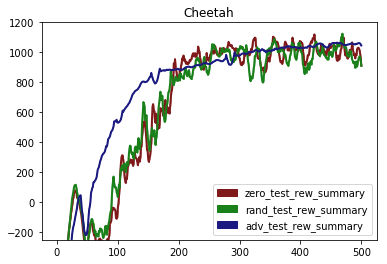

In [14]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,1200])
plt.title("Cheetah")
plt.show()